Import libraries

In [1]:
# Import the required libraries and open the connection to Mongo

import collections
import datetime
import matplotlib as mpl
import json
import numpy as np
import seaborn as sns

import pandas as pd
import geopandas as gpd
import folium

import pymongo
import re

from sklearn import cluster

Setup Functions

In [7]:
def results_to_table(results, index_name, column_name, results_name, 
                     fillna=None,
                     relabel_index=False, relabel_columns=False,
                     index_label=None, column_label=None):
    
    # Move items in dicts-of-dicts to the top level.
    def flatten(d):
        new_d = {}
        for k in d:
            if isinstance(d[k], dict):
                new_d.update(flatten(d[k]))
            else:
                new_d[k] = d[k]
        return new_d

    df = pd.DataFrame([flatten(r) for r in results])
    df = df.pivot(index=index_name, columns=column_name, values=results_name)
    
    # Optionally, fiddle with names and labels to make the DataFrame pretty.
    if not fillna is None:
        df.fillna(fillna, inplace=True)
    if relabel_columns:
        df.columns = [label_of[column_name, c] for c in df.columns]
    if relabel_index:
        df.index = [label_of[index_name, r] for r in df.index]
    if column_label:
        df.columns.name = column_label
    else:
        df.columns.name = column_name
    if index_label:
        df.index.name = index_label
    else:
        df.index.name = index_name
    return df

In [5]:
## drop the table if needed
##census.people.drop()

Data import pipleine

The data was originally found within 2 CSV file one for males and one for females rather than use the all people file as it could also be used to show gender differences or balances if needed

In [6]:
## find files to check location
!find ../2018J_TMA02_data/census-report -name '*csv'

../2018J_TMA02_data/census-report/16-24 Asian-Asian_British Female.csv
../2018J_TMA02_data/census-report/16-24 Asian-Asian_British Male.csv
../2018J_TMA02_data/census-report/16-24 Black-African-Caribbean-Black_British Female.csv
../2018J_TMA02_data/census-report/16-24 Black-African-Caribbean-Black_British Male.csv
../2018J_TMA02_data/census-report/16-24 Mixed Female.csv
../2018J_TMA02_data/census-report/16-24 Mixed Male.csv
../2018J_TMA02_data/census-report/16-24 Other Female.csv
../2018J_TMA02_data/census-report/16-24 Other Male.csv
../2018J_TMA02_data/census-report/16-24 White Female.csv
../2018J_TMA02_data/census-report/16-24 White Male.csv
../2018J_TMA02_data/census-report/25-49 Asian-Asian_British Female.csv
../2018J_TMA02_data/census-report/25-49 Asian-Asian_British Male.csv
../2018J_TMA02_data/census-report/25-49 Black-African-Caribbean-Black_British Female.csv
../2018J_TMA02_data/census-report/25-49 Black-African-Caribbean-Black_British Male.csv
../2018J_TMA02_data/census-repor

import the CSV files

In [7]:
##!find ../2018J_TMA02_data/census-report -name '*csv' \
##  -exec mongoimport --port 27351 --db census --collection people \
##    --type csv --headerline --ignoreBlanks \
##    --file {} \;

2019-05-17T16:46:02.554+0000	connected to: localhost:27351
2019-05-17T16:46:03.062+0000	imported 7201 documents
2019-05-17T16:46:03.085+0000	connected to: localhost:27351
2019-05-17T16:46:03.522+0000	imported 7201 documents
2019-05-17T16:46:03.545+0000	connected to: localhost:27351
2019-05-17T16:46:03.997+0000	imported 7201 documents
2019-05-17T16:46:04.017+0000	connected to: localhost:27351
2019-05-17T16:46:04.472+0000	imported 7201 documents
2019-05-17T16:46:04.494+0000	connected to: localhost:27351
2019-05-17T16:46:04.993+0000	imported 7201 documents
2019-05-17T16:46:05.017+0000	connected to: localhost:27351
2019-05-17T16:46:05.471+0000	imported 7201 documents
2019-05-17T16:46:05.490+0000	connected to: localhost:27351
2019-05-17T16:46:05.958+0000	imported 7201 documents
2019-05-17T16:46:05.989+0000	connected to: localhost:27351
2019-05-17T16:46:06.505+0000	imported 7201 documents
2019-05-17T16:46:06.530+0000	connected to: localhost:27351
2019-05-17T16:46:07.014+0000	imported 7201 do

In [20]:
# Open a connection to the Mongo server
client = pymongo.MongoClient('mongodb://localhost:27351/')

# Connect to the crimes database
census = client.census
people = census.people

In [21]:
people

Collection(Database(MongoClient(host=['localhost:27351'], document_class=dict, tz_aware=False, connect=True), 'census'), 'people')

perform count should be 288040

In [22]:
people.estimated_document_count()

288040

In [23]:
type(people.find_one())

dict

In [24]:
people.find_one()

{'1HMAPO': 0,
 '2LMAPO': 0,
 '3IO': 1,
 '4SEOAW': 0,
 '5LSTO': 0,
 '6SRO': 3,
 '7RO': 0,
 '8NWLTUE': 0,
 '9NC': 5,
 'Age': '16-24',
 'Ethnic_Group': 'Asian/Asian British: Total',
 'Region': 'Darlington 001',
 'SOAML': 'E02002559',
 'Sex': 'F',
 '_id': ObjectId('5cdee54a0d30d3b46e4960ac')}

Rename columns as the names are long and prone to error

In [12]:
census.people.update_many({},{'$rename':{"Not_classified" : "9NC"}});
census.people.update_many({},{'$rename':{"1_Higher_managerial_administrative_and_professional_occupations" : "1HMAPO"}});
census.people.update_many({},{'$rename':{"2_Lower_managerial_administrative_and_professional_occupations" : "2LMAPO"}});
census.people.update_many({},{'$rename':{"3_Intermediate_occupations" : "3IO"}});
census.people.update_many({},{'$rename':{"4_Small_employers_and_own_account_workers" : "4SEOAW"}});
census.people.update_many({},{'$rename':{"5_Lower_supervisory_and_technical_occupations" : "5LSTO"}});
census.people.update_many({},{'$rename':{"6_Semi-routine_occupations" : "6SRO"}});
census.people.update_many({},{'$rename':{"7_Routine_occupations" : "7RO"}});
census.people.update_many({},{'$rename':{"8_Never_worked_and _long-term_unemployed" : "8NWLTUE"}});
census.people.update_many({},{'$rename':{"2011 super output area - middle layer" : "SOAML"}});

In [25]:
people.find_one()

{'1HMAPO': 0,
 '2LMAPO': 0,
 '3IO': 1,
 '4SEOAW': 0,
 '5LSTO': 0,
 '6SRO': 3,
 '7RO': 0,
 '8NWLTUE': 0,
 '9NC': 5,
 'Age': '16-24',
 'Ethnic_Group': 'Asian/Asian British: Total',
 'Region': 'Darlington 001',
 'SOAML': 'E02002559',
 'Sex': 'F',
 '_id': ObjectId('5cdee54a0d30d3b46e4960ac')}

Import the shapefile for the Super Output Layers

In [26]:
shapefile = gpd.read_file("../2018j_TMA02_data/Middle_Layer_Super_Output_Areas_December_2011_Full_Clipped_Boundaries_in_England_and_Wales.shp")
print(shapefile)

      objectid   msoa11cd                  msoa11nm  \
0            1  E02000001        City of London 001   
1            2  E02000002  Barking and Dagenham 001   
2            3  E02000003  Barking and Dagenham 002   
3            4  E02000004  Barking and Dagenham 003   
4            5  E02000005  Barking and Dagenham 004   
5            6  E02000007  Barking and Dagenham 006   
6            7  E02000008  Barking and Dagenham 007   
7            8  E02000009  Barking and Dagenham 008   
8            9  E02000010  Barking and Dagenham 009   
9           10  E02000011  Barking and Dagenham 010   
10          11  E02000012  Barking and Dagenham 011   
11          12  E02000013  Barking and Dagenham 012   
12          13  E02000014  Barking and Dagenham 013   
13          14  E02000015  Barking and Dagenham 014   
14          15  E02000016  Barking and Dagenham 015   
15          16  E02000017  Barking and Dagenham 016   
16          17  E02000018  Barking and Dagenham 017   
17        

In [27]:
## transform shapefile to a dataframe
shapes = pd.DataFrame(shapefile)

In [28]:
shapes[:5]

,objectid,msoa11cd,msoa11nm,msoa11nmw,st_areasha,st_lengths,geometry
0,1,E02000001,City of London 001,City of London 001,2.8978374e+06,9297.7418271,"POLYGON ((532153.7029999997 182165.1554000005,..."
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,2.1615649e+06,8307.0718862,"POLYGON ((548877.6842999998 191097.2841999996,..."
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,2.1415160e+06,9359.9916376,"POLYGON ((548958.5547000002 189072.1767999995,..."
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,2.4929480e+06,8476.6169020,"POLYGON ((551549.9977000002 187364.6372999996,..."
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,1.1879530e+06,7322.4663195,"POLYGON ((549237.051 187627.9415000007, 549241..."


exploring the dataset

In [29]:
list(people.distinct('Ethnic_Group'))

['Asian/Asian British: Total',
 'Black/African/Caribbean/Black British: Total',
 'Mixed/multiple ethnic group: Total',
 'Other ethnic group: Total',
 'White: Total']

In [30]:
list(people.distinct('Age'))

['16-24', '25-49', '50-64', '65+']

In [31]:
list(people.distinct('Sex'))

['F', 'M']

In [32]:
pipeline = [{'$match' : 
             { 'Region' : {'$regex': 'Darlington'}}}]
results = list(people.aggregate(pipeline))
results[:1]

[{'1HMAPO': 0,
  '2LMAPO': 0,
  '3IO': 1,
  '4SEOAW': 0,
  '5LSTO': 0,
  '6SRO': 3,
  '7RO': 0,
  '8NWLTUE': 0,
  '9NC': 5,
  'Age': '16-24',
  'Ethnic_Group': 'Asian/Asian British: Total',
  'Region': 'Darlington 001',
  'SOAML': 'E02002559',
  'Sex': 'F',
  '_id': ObjectId('5cdee54a0d30d3b46e4960ac')}]

In [33]:
test = results_to_table(results, '_id', 'Sex', '9NC', fillna=0)
test

Sex,F,M
_id,,
5cdee54a0d30d3b46e4960ac,5.0,0.0
5cdee54a0d30d3b46e4960ad,0.0,0.0
5cdee54a0d30d3b46e4960ae,4.0,0.0
5cdee54a0d30d3b46e4960af,2.0,0.0
5cdee54a0d30d3b46e4960b0,3.0,0.0
5cdee54a0d30d3b46e4960b1,2.0,0.0
5cdee54a0d30d3b46e4960b2,3.0,0.0
5cdee54a0d30d3b46e4960b3,23.0,0.0
5cdee54a0d30d3b46e4960b4,4.0,0.0


In [34]:
test2 = pd.DataFrame(results)

In [35]:
test2

,1HMAPO,2LMAPO,3IO,4SEOAW,5LSTO,6SRO,7RO,8NWLTUE,9NC,Age,Ethnic_Group,Region,SOAML,Sex,_id
0,0,0,1,0,0,3,0,0,5,16-24,Asian/Asian British: Total,Darlington 001,E02002559,F,5cdee54a0d30d3b46e4960ac
1,0,0,0,0,0,1,0,0,0,16-24,Asian/Asian British: Total,Darlington 002,E02002560,F,5cdee54a0d30d3b46e4960ad
2,0,0,1,0,0,0,0,0,4,16-24,Asian/Asian British: Total,Darlington 003,E02002561,F,5cdee54a0d30d3b46e4960ae
3,0,0,1,0,0,1,0,0,2,16-24,Asian/Asian British: Total,Darlington 004,E02002562,F,5cdee54a0d30d3b46e4960af
4,0,0,0,0,0,0,0,0,3,16-24,Asian/Asian British: Total,Darlington 005,E02002563,F,5cdee54a0d30d3b46e4960b0
5,0,0,0,0,0,0,0,0,2,16-24,Asian/Asian British: Total,Darlington 006,E02002564,F,5cdee54a0d30d3b46e4960b1
6,0,0,0,0,0,0,0,0,3,16-24,Asian/Asian British: Total,Darlington 007,E02002565,F,5cdee54a0d30d3b46e4960b2
7,0,4,8,0,1,5,3,10,23,16-24,Asian/Asian British: Total,Darlington 008,E02002566,F,5cdee54a0d30d3b46e4960b3
8,2,0,1,0,0,0,0,1,4,16-24,Asian/Asian British: Total,Darlington 009,E02002567,F,5cdee54a0d30d3b46e4960b4
9,0,0,0,0,0,0,1,1,1,16-24,Asian/Asian British: Total,Darlington 010,E02002568,F,5cdee54a0d30d3b46e4960b5


In [ ]:
create darlington dataframe colapsing 

In [36]:
## strip the numbers from the end of the region
test2['Region']= test2['Region'].map(lambda x: str(x)[:-3])

In [37]:
df = test2.groupby(['Region','Sex','Ethnic_Group','Age']).sum()

In [38]:
df

1HMAPO  \
Region      Sex Ethnic_Group                                 Age             
Darlington  F   Asian/Asian British: Total                   16-24       4   
                                                             25-49      71   
                                                             50-64      11   
                                                             65+         4   
                Black/African/Caribbean/Black British: Total 16-24       1   
                                                             25-49      12   
                                                             50-64       3   
                                                             65+         0   
                Mixed/multiple ethnic group: Total           16-24       1   
                                                             25-49      12   
                                                             50-64       3   
                                                             65+         0   
                Other ethnic group: Total                    16-24       1   
                                                             25-49       6   
                                                             50-64       0   
                                                             65+         0   
                White: Total                                 16-24      64   
                                                             25-49    1283   
                                                             50-64     539   
                                                             65+       200   
            M   Asian/Asian British: Total                   16-24       4   
                                                             25-49     142   
                                                             50-64      25   
                                                             65+        17   
                Black/African/Caribbean/Black British: Total 16-24       1   
                                                             25-49      20   
                                                             50-64       3   
                                                             65+         2   
                Mixed/multiple ethnic group: Total           16-24       2   
                                                             25-49       9   
                                                             50-64       3   
                                                             65+         1   
                Other ethnic group: Total                    16-24       1   
                                                             25-49      13   
                                                             50-64       9   
                                                             65+         2   
                White: Total                                 16-24     134   
                                                             25-49    2092   
                                                             50-64    1295   
                                                             65+      1003   

                                                                    2LMAPO  \
Region      Sex Ethnic_Group                                 Age             
Darlington  F   Asian/Asian British: Total                   16-24       6   
                                                             25-49      72   
                                                             50-64      18   
                                                             65+         7   
                Black/African/Caribbean/Black British: Total 16-24       0   
                                                             25-49      17   
                                                             50-64       4   
                                                             65+         3   
           

In [39]:
regions = pd.DataFrame(people.distinct('Region'))
regions 

,0
0,Darlington 001
1,Darlington 002
2,Darlington 003
3,Darlington 004
4,Darlington 005
5,Darlington 006
6,Darlington 007
7,Darlington 008
8,Darlington 009
9,Darlington 010


In [40]:
 regions.rename(index=str, columns={0 : "Region"})

,Region
0,Darlington 001
1,Darlington 002
2,Darlington 003
3,Darlington 004
4,Darlington 005
5,Darlington 006
6,Darlington 007
7,Darlington 008
8,Darlington 009
9,Darlington 010


In [41]:
regions['Region']= regions[0].map(lambda x: str(x)[:-3])

In [42]:
colls = list(test2)


In [43]:
colls

['1HMAPO',
 '2LMAPO',
 '3IO',
 '4SEOAW',
 '5LSTO',
 '6SRO',
 '7RO',
 '8NWLTUE',
 '9NC',
 'Age',
 'Ethnic_Group',
 'Region',
 'SOAML',
 'Sex',
 '_id']

In [44]:
regions = regions.groupby(['Region']).sum()

In [45]:
regions

,0
Region,
Adur,Adur 002Adur 001Adur 003Adur 004Adur 005Adur 0...
Allerdale,Allerdale 001Allerdale 002Allerdale 003Allerda...
Amber Valley,Amber Valley 001Amber Valley 002Amber Valley 0...
Arun,Arun 001Arun 002Arun 004Arun 005Arun 006Arun 0...
Ashfield,Ashfield 002Ashfield 003Ashfield 004Ashfield 0...
Ashford,Ashford 001Ashford 002Ashford 003Ashford 004As...
Aylesbury Vale,Aylesbury Vale 001Aylesbury Vale 002Aylesbury ...
Babergh,Babergh 001Babergh 002Babergh 003Babergh 005Ba...
Barking and Dagenham,Barking and Dagenham 001Barking and Dagenham 0...


In [46]:
def create_dataframe(database, regions, cols):
    df = pd.DataFrame(columns=cols)
    for row in regions.itertuples():
        region = row.Index
        pipeline = [{'$match' : 
                     { 'Region' : {'$regex': region }}}]
        results = pd.DataFrame(list(people.aggregate(pipeline)))
        df= pd.concat([df,results])
    df['Region']= df['Region'].map(lambda x: str(x)[:-3])
    df = df.groupby(['Region','Sex','Ethnic_Group','Age']).sum()
    return df
        
        

In [47]:
def create_dataframe_nogender(database, regions, cols):
    df = pd.DataFrame(columns=cols)
    for row in regions.itertuples():
        region = row.Index
        pipeline = [{'$match' : 
                     { 'Region' : {'$regex': region }}}]
        results = pd.DataFrame(list(people.aggregate(pipeline)))
        df= pd.concat([df,results])
    df['Region']= df['Region'].map(lambda x: str(x)[:-3])
    df = df.groupby(['Region','Ethnic_Group','Age']).sum()
    return df

In [48]:
def create_dataframe_nogender_noage(database, regions, cols):
    df = pd.DataFrame(columns=cols)
    for row in regions.itertuples():
        region = row.Index
        pipeline = [{'$match' : 
                     { 'Region' : {'$regex': region }}}]
        results = pd.DataFrame(list(people.aggregate(pipeline)))
        df= pd.concat([df,results])
    df['Region']= df['Region'].map(lambda x: str(x)[:-3])
    df = df.groupby(['Region','Ethnic_Group']).sum()
    return df

In [49]:
def create_dataframe_regional(database, regions, cols):
    df = pd.DataFrame(columns=cols)
    for row in regions.itertuples():
        region = row.Index
        pipeline = [{'$match' : 
                     { 'Region' : {'$regex': region }}}]
        results = pd.DataFrame(list(people.aggregate(pipeline)))
        df= pd.concat([df,results])
    df['Region']= df['Region'].map(lambda x: str(x)[:-3])
    df = df.groupby(['Region']).sum()
    return df

In [50]:
census = create_dataframe(people,regions,colls)

In [51]:
censusng = create_dataframe_nogender(people,regions,colls)

In [52]:
censusngna = create_dataframe_nogender_noage(people,regions,colls)

In [53]:
censusrg = create_dataframe_regional(people,regions,colls)

In [54]:
census.head()

1HMAPO  2LMAPO  \
Region Sex Ethnic_Group                                 Age                     
Adur   F   Asian/Asian British: Total                   16-24       3       3   
                                                        25-49      26      54   
                                                        50-64       7      16   
                                                        65+         1      12   
           Black/African/Caribbean/Black British: Total 16-24       0       1   

                                                               3IO  4SEOAW  \
Region Sex Ethnic_Group                                 Age                  
Adur   F   Asian/Asian British: Total                   16-24    2       0   
                                                        25-49   40      33   
                                                        50-64    6       6   
                                                        65+      3       1   
           Black/African/Caribbean/Black British: Total 16-24    2       0   

                                                               5LSTO  6SRO  \
Region Sex Ethnic_Group                                 Age                  
Adur   F   Asian/Asian British: Total                   16-24      1    12   
                                                        25-49     11    36   
                                                        50-64      4    16   
                                                        65+        2     7   
           Black/African/Caribbean/Black British: Total 16-24      0     4   

                                                               7RO  8NWLTUE  \
Region Sex Ethnic_Group                                 Age                   
Adur   F   Asian/Asian British: Total                   16-24    3        2   
                                                        25-49   17       46   
                                                        50-64   10        8   
                                                        65+      1        6   
           Black/African/Caribbean/Black British: Total 16-24    0        0   

                                                               9NC  \
Region Sex Ethnic_Group                                 Age          
Adur   F   Asian/Asian British: Total                   16-24   51   
                                                        25-49    3   
                                                        50-64    0   
                                                        65+      0   
           Black/African/Caribbean/Black British: Total 16-24    4   

                                                                                                           SOAML  
Region Sex Ethnic_Group                                 Age                                                       
Adur   F   Asian/Asian British: Total                   16-24  E02006535E02006534E02006536E02006537E02006538E...  
                                                        25-49  E02006534E02006536E02006535E02006538E02006539E...  
                                                        50-64  E02006534E02006536E02006537E02006538E02006539E...  
                                                        65+    E02006534E02006535E02006536E02006537E02006538E...  
           Black/African/Caribbean/Black British: Total 16-24  E02006534E02006536E02006535E02006537E02006538E...

In [55]:
censusng.head()

1HMAPO  2LMAPO  \
Region Ethnic_Group                                 Age                     
Adur   Asian/Asian British: Total                   16-24       5       6   
                                                    25-49      46      87   
                                                    50-64      20      26   
                                                    65+         6      21   
       Black/African/Caribbean/Black British: Total 16-24       0       2   

                                                           3IO  4SEOAW  5LSTO  \
Region Ethnic_Group                                 Age                         
Adur   Asian/Asian British: Total                   16-24    7       1      4   
                                                    25-49   58      80     43   
                                                    50-64    8      30     13   
                                                    65+      4       7      7   
       Black/African/Caribbean/Black British: Total 16-24    2       0      0   

                                                           6SRO  7RO  8NWLTUE  \
Region Ethnic_Group                                 Age                         
Adur   Asian/Asian British: Total                   16-24    17    8        2   
                                                    25-49    56   31       51   
                                                    50-64    19   15       11   
                                                    65+       8    2        8   
       Black/African/Caribbean/Black British: Total 16-24     6    0        0   

                                                           9NC  \
Region Ethnic_Group                                 Age          
Adur   Asian/Asian British: Total                   16-24  103   
                                                    25-49   12   
                                                    50-64    0   
                                                    65+      0   
       Black/African/Caribbean/Black British: Total 16-24   24   

                                                                                                       SOAML  \
Region Ethnic_Group                                 Age                                                        
Adur   Asian/Asian British: Total                   16-24  E02006535E02006534E02006536E02006537E02006538E...   
                                                    25-49  E02006534E02006536E02006535E02006538E02006539E...   
                                                    50-64  E02006534E02006536E02006537E02006538E02006539E...   
                                                    65+    E02006534E02006535E02006536E02006537E02006538E...   
       Black/African/Caribbean/Black British: Total 16-24  E02006534E02006536E02006535E02006537E02006538E...   

                                                                        Sex  
Region Ethnic_Group                                 Age                      
Adur   Asian/Asian British: Total                   16-24  FFFFFFFFMMMMMMMM  
                                                    25-49  FFFFFFFFMMMMMMMM  
                                                    50-64  FFFFFFFFMMMMMMMM  
                                                    65+    FFFFFFFFMMMMMMMM  
       Black/African/Caribbean/Black British: Total 16-24  FFFFFFFFMMMMMMMM

In [56]:
Regional_Ethn_Age = censusng.drop(['Sex','SOAML'],axis=1)

In [57]:
Regional_Ethn_Age

1HMAPO  \
Region       Ethnic_Group                                 Age             
Adur         Asian/Asian British: Total                   16-24       5   
                                                          25-49      46   
                                                          50-64      20   
                                                          65+         6   
             Black/African/Caribbean/Black British: Total 16-24       0   
                                                          25-49      15   
                                                          50-64       7   
                                                          65+         1   
             Mixed/multiple ethnic group: Total           16-24       0   
                                                          25-49      39   
                                                          50-64       7   
                                                          65+         1   
             Other ethnic group: Total                    16-24       0   
                                                          25-49      14   
                                                          50-64       1   
                                                          65+         3   
             White: Total                                 16-24      81   
                                                          25-49    1987   
                                                          50-64    1074   
                                                          65+       887   
Allerdale    Asian/Asian British: Total                   16-24       0   
                                                          25-49      21   
                                                          50-64      14   
                                                          65+        11   
             Black/African/Caribbean/Black British: Total 16-24       0   
...                                                                 ...   
Wyre Forest  Other ethnic group: Total                    65+         0   
             White: Total                                 16-24     284   
                                                          25-49    6012   
                                                          50-64    3972   
                                                          65+      3108   
York         Asian/Asian British: Total                   16-24      31   
                                                          25-49     548   
                                                          50-64      60   
                                                          65+        19   
             Black/African/Caribbean/Black British: Total 16-24       1   
                                                          25-49      98   
                                                          50-64      13   
                                                          65+         8   
             Mixed/multiple ethnic group: Total           16-24       6   
                                                          25-49     109   
                                                          50-64      20   
                                                          65+         3   
             Other ethnic group: Total                    16-24       1   
                                                          25-49      65   
                                                          50-64      12   
                                                          65+         4   
             White: Total                                 16-24     485   
                                                          25-49   10150   
                                                          50-64    4313   
                                                          65+      2774   

                                                                 2LMAPO   3IO  \
Region  

In [58]:
censusngna.head()

1HMAPO  2LMAPO   3IO  \
Region Ethnic_Group                                                         
Adur   Asian/Asian British: Total                        77     140    77   
       Black/African/Caribbean/Black British: Total      23      58    24   
       Mixed/multiple ethnic group: Total                47     105    72   
       Other ethnic group: Total                         18      33    15   
       White: Total                                    4029   10606  7890   

                                                     4SEOAW  5LSTO  6SRO  \
Region Ethnic_Group                                                        
Adur   Asian/Asian British: Total                       118     67   100   
       Black/African/Caribbean/Black British: Total      23     12    59   
       Mixed/multiple ethnic group: Total                44     21    60   
       Other ethnic group: Total                         39     11    21   
       White: Total                                    5558   3894  7941   

                                                      7RO  8NWLTUE   9NC  \
Region Ethnic_Group                                                        
Adur   Asian/Asian British: Total                      56       72   115   
       Black/African/Caribbean/Black British: Total     8       12    35   
       Mixed/multiple ethnic group: Total              41       42    69   
       Other ethnic group: Total                        9       22    30   
       White: Total                                  4994     1642  2250   

                                                                                                   Age  \
Region Ethnic_Group                                                                                      
Adur   Asian/Asian British: Total                    16-2416-2416-2416-2416-2416-2416-2416-2416-241...   
       Black/African/Caribbean/Black British: Total  16-2416-2416-2416-2416-2416-2416-2416-2416-241...   
       Mixed/multiple ethnic group: Total            16-2416-2416-2416-2416-2416-2416-2416-2416-241...   
       Other ethnic group: Total                     16-2416-2416-2416-2416-2416-2416-2416-2416-241...   
       White: Total                                  16-2416-2416-2416-2416-2416-2416-2416-2416-241...   

                                                                                                 SOAML  \
Region Ethnic_Group                                                                                      
Adur   Asian/Asian British: Total                    E02006535E02006534E02006536E02006537E02006538E...   
       Black/African/Caribbean/Black British: Total  E02006534E02006536E02006535E02006537E02006538E...   
       Mixed/multiple ethnic group: Total            E02006534E02006535E02006536E02006537E02006538E...   
       Other ethnic group: Total                     E02006534E02006536E02006537E02006538E02006535E...   
       White: Total                                  E02006534E02006535E02006536E02006537E02006538E...   

                                                                                                   Sex  
Region Ethnic_Group                                                                                     
Adur   Asian/Asian British: Total                    FFFFFFFFMMMMMMMMFFFFFFFFMMMMMMMMFFFFFFFFMMMMMM...  
       Black/African/Caribbean/Black British: Total  FFFFFFFFMMMMMMMMFFFFFFFFMMMMMMMMFFFFFFFFMMMMMM...  
       Mixed/multiple ethnic group: Total            FFFFFFFFMMMMMMMMFFFFFFFFMMMMMMMMFFFFFFFFMMMMMM...  
       Other ethnic group: Total                     FFFFFFFFMMMMMMMMFFFFFFFFMMMMMMMMFFFFFFFFMMMMMM...  
       White: Total                                  FFFFFFFFMMMMMMMMFFFFFFFFMMMMMMMMFFFFFFFFMMMMMM...

In [59]:
Regional_Ethn = censusngna.drop(['Age','SOAML','Sex'],axis =1)

In [60]:
Regional_Ethn

1HMAPO  2LMAPO  \
Region        Ethnic_Group                                                   
Adur          Asian/Asian British: Total                        77     140   
              Black/African/Caribbean/Black British: Total      23      58   
              Mixed/multiple ethnic group: Total                47     105   
              Other ethnic group: Total                         18      33   
              White: Total                                    4029   10606   
Allerdale     Asian/Asian British: Total                        46      41   
              Black/African/Caribbean/Black British: Total       7      16   
              Mixed/multiple ethnic group: Total                15      42   
              Other ethnic group: Total                         10      13   
              White: Total                                    6021   14703   
Amber Valley  Asian/Asian British: Total                        88     122   
              Black/African/Caribbean/Black British: Total      21      55   
              Mixed/multiple ethnic group: Total                50     111   
              Other ethnic group: Total                         11      21   
              White: Total                                    8924   19103   
Arun          Asian/Asian British: Total                       124     258   
              Black/African/Caribbean/Black British: Total      35     116   
              Mixed/multiple ethnic group: Total                72     156   
              Other ethnic group: Total                         18      31   
              White: Total                                   10900   26390   
Ashfield      Asian/Asian British: Total                       111     162   
              Black/African/Caribbean/Black British: Total      38      98   
              Mixed/multiple ethnic group: Total                25      83   
              Other ethnic group: Total                          8       9   
              White: Total                                    5324   14997   
...                                                            ...     ...   
Wychavon      Asian/Asian British: Total                       111     156   
              Black/African/Caribbean/Black British: Total      17      53   
              Mixed/multiple ethnic group: Total                46     104   
              Other ethnic group: Total                         27      20   
              White: Total                                   11148   21486   
Wycombe       Asian/Asian British: Total                      1497    1920   
              Black/African/Caribbean/Black British: Total     352     908   
              Mixed/multiple ethnic group: Total               257     501   
              Other ethnic group: Total                        111     133   
              White: Total                                   17226   29492   
Wyre          Asian/Asian British: Total                        97      92   
              Black/African/Caribbean/Black British: Total      16      19   
              Mixed/multiple ethnic group: Total                27      59   
              Other ethnic group: Total                         16      15   
              White: Total                                    7269   18590   
Wyre Forest   Asian/Asian British: Total                       136     264   
              Black/African/Caribbean/Black British: Total      22      98   
              Mixed/multiple ethnic group: Total                90     172   
              Other ethnic group: Total                         18      28   
              White: Total                                   13376   31532   
York          Asian/Asian British: Total                       658     647   
              Black/African/Caribbean/Black British: Total     120     187   
              Mixed/multiple ethnic group: Total               138     239   
              Other ethnic group: Total                         82      84   
    

In [61]:
Regional_pop = censusrg.drop(['Age','Ethnic_Group','SOAML','Sex'], axis=1)

In [62]:
Regional_pop

,1HMAPO,2LMAPO,3IO,4SEOAW,5LSTO,6SRO,7RO,8NWLTUE,9NC
Region,,,,,,,,,
Adur,4194,10942,8078,5782,4005,8181,5108,1790,2499
Allerdale,6099,14815,8239,9094,7774,14432,12397,3721,3584
Amber Valley,9094,19412,11814,9423,9315,16089,16425,4288,4981
Arun,11149,26951,18858,14968,9608,20238,13146,5195,6051
Ashfield,5506,15349,11661,7766,9721,17108,19562,5284,4741
Ashford,9313,20269,12751,10859,7541,13769,9851,3834,5224
Aylesbury Vale,18120,34449,19822,15149,8665,16485,12311,5221,8345
Babergh,7354,16098,9560,8888,5360,10590,7935,2545,3491
Barking and Dagenham,6686,20407,17873,12484,9636,22490,17969,15566,14502


In [63]:
test.head()

Sex,F,M
_id,,
5cdee54a0d30d3b46e4960ac,5.0,0.0
5cdee54a0d30d3b46e4960ad,0.0,0.0
5cdee54a0d30d3b46e4960ae,4.0,0.0
5cdee54a0d30d3b46e4960af,2.0,0.0
5cdee54a0d30d3b46e4960b0,3.0,0.0


In [64]:
regions.head()

,0
Region,
Adur,Adur 002Adur 001Adur 003Adur 004Adur 005Adur 0...
Allerdale,Allerdale 001Allerdale 002Allerdale 003Allerda...
Amber Valley,Amber Valley 001Amber Valley 002Amber Valley 0...
Arun,Arun 001Arun 002Arun 004Arun 005Arun 006Arun 0...
Ashfield,Ashfield 002Ashfield 003Ashfield 004Ashfield 0...


In [42]:
shapes.head()

NameError: name 'shapes' is not defined

In [65]:
census.head()

1HMAPO  2LMAPO  \
Region Sex Ethnic_Group                                 Age                     
Adur   F   Asian/Asian British: Total                   16-24       3       3   
                                                        25-49      26      54   
                                                        50-64       7      16   
                                                        65+         1      12   
           Black/African/Caribbean/Black British: Total 16-24       0       1   

                                                               3IO  4SEOAW  \
Region Sex Ethnic_Group                                 Age                  
Adur   F   Asian/Asian British: Total                   16-24    2       0   
                                                        25-49   40      33   
                                                        50-64    6       6   
                                                        65+      3       1   
           Black/African/Caribbean/Black British: Total 16-24    2       0   

                                                               5LSTO  6SRO  \
Region Sex Ethnic_Group                                 Age                  
Adur   F   Asian/Asian British: Total                   16-24      1    12   
                                                        25-49     11    36   
                                                        50-64      4    16   
                                                        65+        2     7   
           Black/African/Caribbean/Black British: Total 16-24      0     4   

                                                               7RO  8NWLTUE  \
Region Sex Ethnic_Group                                 Age                   
Adur   F   Asian/Asian British: Total                   16-24    3        2   
                                                        25-49   17       46   
                                                        50-64   10        8   
                                                        65+      1        6   
           Black/African/Caribbean/Black British: Total 16-24    0        0   

                                                               9NC  \
Region Sex Ethnic_Group                                 Age          
Adur   F   Asian/Asian British: Total                   16-24   51   
                                                        25-49    3   
                                                        50-64    0   
                                                        65+      0   
           Black/African/Caribbean/Black British: Total 16-24    4   

                                                                                                           SOAML  
Region Sex Ethnic_Group                                 Age                                                       
Adur   F   Asian/Asian British: Total                   16-24  E02006535E02006534E02006536E02006537E02006538E...  
                                                        25-49  E02006534E02006536E02006535E02006538E02006539E...  
                                                        50-64  E02006534E02006536E02006537E02006538E02006539E...  
                                                        65+    E02006534E02006535E02006536E02006537E02006538E...  
           Black/African/Caribbean/Black British: Total 16-24  E02006534E02006536E02006535E02006537E02006538E...

In [66]:
print(census.query('Region == "Adur"'))

Empty DataFrame
Columns: [1HMAPO, 2LMAPO, 3IO, 4SEOAW, 5LSTO, 6SRO, 7RO, 8NWLTUE, 9NC, SOAML]
Index: []


In [67]:
censusng.head()

1HMAPO  2LMAPO  \
Region Ethnic_Group                                 Age                     
Adur   Asian/Asian British: Total                   16-24       5       6   
                                                    25-49      46      87   
                                                    50-64      20      26   
                                                    65+         6      21   
       Black/African/Caribbean/Black British: Total 16-24       0       2   

                                                           3IO  4SEOAW  5LSTO  \
Region Ethnic_Group                                 Age                         
Adur   Asian/Asian British: Total                   16-24    7       1      4   
                                                    25-49   58      80     43   
                                                    50-64    8      30     13   
                                                    65+      4       7      7   
       Black/African/Caribbean/Black British: Total 16-24    2       0      0   

                                                           6SRO  7RO  8NWLTUE  \
Region Ethnic_Group                                 Age                         
Adur   Asian/Asian British: Total                   16-24    17    8        2   
                                                    25-49    56   31       51   
                                                    50-64    19   15       11   
                                                    65+       8    2        8   
       Black/African/Caribbean/Black British: Total 16-24     6    0        0   

                                                           9NC  \
Region Ethnic_Group                                 Age          
Adur   Asian/Asian British: Total                   16-24  103   
                                                    25-49   12   
                                                    50-64    0   
                                                    65+      0   
       Black/African/Caribbean/Black British: Total 16-24   24   

                                                                                                       SOAML  \
Region Ethnic_Group                                 Age                                                        
Adur   Asian/Asian British: Total                   16-24  E02006535E02006534E02006536E02006537E02006538E...   
                                                    25-49  E02006534E02006536E02006535E02006538E02006539E...   
                                                    50-64  E02006534E02006536E02006537E02006538E02006539E...   
                                                    65+    E02006534E02006535E02006536E02006537E02006538E...   
       Black/African/Caribbean/Black British: Total 16-24  E02006534E02006536E02006535E02006537E02006538E...   

                                                                        Sex  
Region Ethnic_Group                                 Age                      
Adur   Asian/Asian British: Total                   16-24  FFFFFFFFMMMMMMMM  
                                                    25-49  FFFFFFFFMMMMMMMM  
                                                    50-64  FFFFFFFFMMMMMMMM  
                                                    65+    FFFFFFFFMMMMMMMM  
       Black/African/Caribbean/Black British: Total 16-24  FFFFFFFFMMMMMMMM

In [68]:
census.keys()


Index(['1HMAPO', '2LMAPO', '3IO', '4SEOAW', '5LSTO', '6SRO', '7RO', '8NWLTUE',
       '9NC', 'SOAML'],
      dtype='object')

In [69]:
 indexes = census.index.values.tolist()

In [70]:
indexes

[('Adur ', 'F', 'Asian/Asian British: Total', '16-24'),
 ('Adur ', 'F', 'Asian/Asian British: Total', '25-49'),
 ('Adur ', 'F', 'Asian/Asian British: Total', '50-64'),
 ('Adur ', 'F', 'Asian/Asian British: Total', '65+'),
 ('Adur ', 'F', 'Black/African/Caribbean/Black British: Total', '16-24'),
 ('Adur ', 'F', 'Black/African/Caribbean/Black British: Total', '25-49'),
 ('Adur ', 'F', 'Black/African/Caribbean/Black British: Total', '50-64'),
 ('Adur ', 'F', 'Black/African/Caribbean/Black British: Total', '65+'),
 ('Adur ', 'F', 'Mixed/multiple ethnic group: Total', '16-24'),
 ('Adur ', 'F', 'Mixed/multiple ethnic group: Total', '25-49'),
 ('Adur ', 'F', 'Mixed/multiple ethnic group: Total', '50-64'),
 ('Adur ', 'F', 'Mixed/multiple ethnic group: Total', '65+'),
 ('Adur ', 'F', 'Other ethnic group: Total', '16-24'),
 ('Adur ', 'F', 'Other ethnic group: Total', '25-49'),
 ('Adur ', 'F', 'Other ethnic group: Total', '50-64'),
 ('Adur ', 'F', 'Other ethnic group: Total', '65+'),
 ('Adur ', '

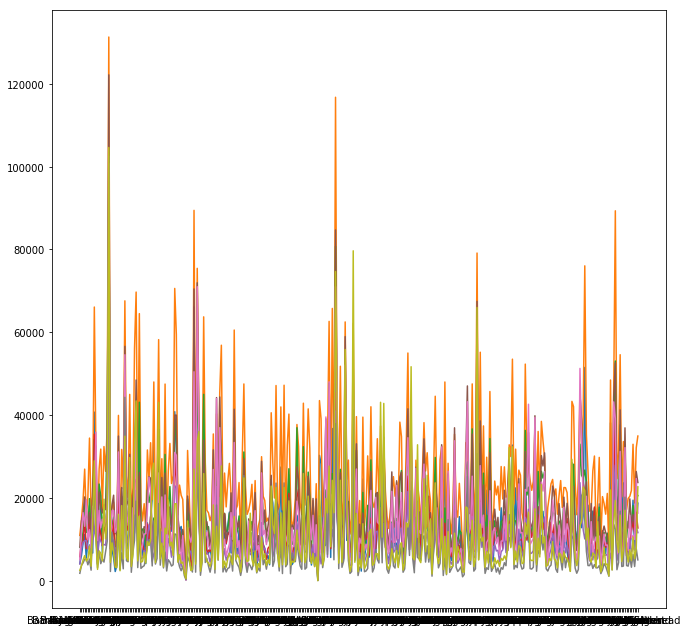

In [71]:
fig = plt.figure(figsize=[11,11])
plt.plot(Regional_pop)

In [72]:
census.index('Basingstoke and Deane ',
  'F',
  'Black/African/Caribbean/Black British: Total',
  '25-49')

TypeError: 'MultiIndex' object is not callable

In [73]:
census.loc[('Basingstoke and Deane ','M'),:]

1HMAPO  2LMAPO   3IO  \
Ethnic_Group                                 Age                           
Asian/Asian British: Total                   16-24      18      17    10   
                                             25-49     605     402   116   
                                             50-64      66      48    21   
                                             65+        23      32    10   
Black/African/Caribbean/Black British: Total 16-24       3       4     4   
                                             25-49     112     123    53   
                                             50-64      19      21    14   
                                             65+         5       9     4   
Mixed/multiple ethnic group: Total           16-24       9      19    13   
                                             25-49      72     104    32   
                                             50-64      21      23     5   
                                             65+         1       6     3   
Other ethnic group: Total                    16-24       0       3     0   
                                             25-49      29      24    12   
                                             50-64       6       9     2   
                                             65+         3       4     2   
White: Total                                 16-24     298     847   583   
                                             25-49    6424    7662  2165   
                                             50-64    3433    3637   971   
                                             65+      1838    2217   781   

                                                    4SEOAW  5LSTO  6SRO   7RO  \
Ethnic_Group                                 Age                                
Asian/Asian British: Total                   16-24       4      9    26    26   
                                             25-49      96    129   207   119   
                                             50-64      35     34    39    32   
                                             65+        23      8    17    12   
Black/African/Caribbean/Black British: Total 16-24       1      5     6     6   
                                             25-49      36     35    62    59   
                                             50-64      10      8    16    13   
                                             65+         4      8    12    11   
Mixed/multiple ethnic group: Total           16-24       3     18    26    15   
                                             25-49      41     22    35    45   
                                             50-64      12      6     9    10   
                                             65+         5      6     4     5   
Other ethnic group: Total                    16-24       0      1     2     1   
                                             25-49      13      8    12    11   
                                             50-64       2      1     1     6   
                                             65+         2      2     0     2   
White: Total                                 16-24     310    710  1002   827   
                                             25-49    3315   2767  2143  2798   
                                             50-64    2276   1455  1251  1790   
                                             65+      1516   1529  1218  1546   

                                                    8NWLTUE   9NC  \
Ethnic_Group                                 Age                    
Asian/Asian British: Total                   16-24       10   182   
                                             25-49       30    42   
                                             50-64       11     2   
                                             65+         26     0   
Black/African/Caribbean/Black British: Total 16-24        1    51   
                                             25-49       26    22   
                                            

In [74]:
 index1 = census.loc[('Basingstoke and Deane ','M'),:].index.values.tolist()

In [75]:
index1

[('Asian/Asian British: Total', '16-24'),
 ('Asian/Asian British: Total', '25-49'),
 ('Asian/Asian British: Total', '50-64'),
 ('Asian/Asian British: Total', '65+'),
 ('Black/African/Caribbean/Black British: Total', '16-24'),
 ('Black/African/Caribbean/Black British: Total', '25-49'),
 ('Black/African/Caribbean/Black British: Total', '50-64'),
 ('Black/African/Caribbean/Black British: Total', '65+'),
 ('Mixed/multiple ethnic group: Total', '16-24'),
 ('Mixed/multiple ethnic group: Total', '25-49'),
 ('Mixed/multiple ethnic group: Total', '50-64'),
 ('Mixed/multiple ethnic group: Total', '65+'),
 ('Other ethnic group: Total', '16-24'),
 ('Other ethnic group: Total', '25-49'),
 ('Other ethnic group: Total', '50-64'),
 ('Other ethnic group: Total', '65+'),
 ('White: Total', '16-24'),
 ('White: Total', '25-49'),
 ('White: Total', '50-64'),
 ('White: Total', '65+')]

In [76]:
## split off employed and unemplyed into a dataframe totals for each area

In [77]:
Regional_pop[:5]

,1HMAPO,2LMAPO,3IO,4SEOAW,5LSTO,6SRO,7RO,8NWLTUE,9NC
Region,,,,,,,,,
Adur,4194,10942,8078,5782,4005,8181,5108,1790,2499
Allerdale,6099,14815,8239,9094,7774,14432,12397,3721,3584
Amber Valley,9094,19412,11814,9423,9315,16089,16425,4288,4981
Arun,11149,26951,18858,14968,9608,20238,13146,5195,6051
Ashfield,5506,15349,11661,7766,9721,17108,19562,5284,4741


In [78]:
## create totals columns
regional_pop_unemployed = Regional_pop
regional_pop_unemployed['total_population'] = regional_pop_unemployed.apply(lambda row: row['1HMAPO']+row['2LMAPO']+row['3IO']+row['4SEOAW']+row['5LSTO']+row['6SRO']+row['7RO']+row['8NWLTUE']+row['9NC'], axis=1)
regional_pop_unemployed['unemployed_population'] = regional_pop_unemployed.apply(lambda row: row['8NWLTUE'], axis=1)
regional_pop_unemployed['employed_population'] = regional_pop_unemployed.apply(lambda row: row['1HMAPO']+row['2LMAPO']+row['3IO']+row['4SEOAW']+row['5LSTO']+row['6SRO']+row['7RO'], axis=1)

In [79]:
regional_pop_unemployed.head()

,1HMAPO,2LMAPO,3IO,4SEOAW,5LSTO,6SRO,7RO,8NWLTUE,9NC,total_population,unemployed_population,employed_population
Region,,,,,,,,,,,,
Adur,4194,10942,8078,5782,4005,8181,5108,1790,2499,50579,1790,46290
Allerdale,6099,14815,8239,9094,7774,14432,12397,3721,3584,80155,3721,72850
Amber Valley,9094,19412,11814,9423,9315,16089,16425,4288,4981,100841,4288,91572
Arun,11149,26951,18858,14968,9608,20238,13146,5195,6051,126164,5195,114918
Ashfield,5506,15349,11661,7766,9721,17108,19562,5284,4741,96698,5284,86673


In [80]:
regional_pop_unemployed = regional_pop_unemployed[['total_population','unemployed_population','employed_population']]

In [82]:
def calculate_percentage(row):
    return row['unemployed_population'] / row['total_population'] * 100
regional_pop_unemployed['unemployed_percentage'] = regional_pop_unemployed.apply(calculate_percentage, axis =1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
def calculate_percentage(row):
    return row['employed_population'] / row['total_population'] * 100
regional_pop_unemployed['employed_percentage'] = regional_pop_unemployed.apply(calculate_percentage, axis =1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [84]:
regional_pop_unemployed.head()

,total_population,unemployed_population,employed_population,unemployed_percentage,employed_percentage
Region,,,,,
Adur,50579,1790,46290,3.5390182,91.5201961
Allerdale,80155,3721,72850,4.6422556,90.8864076
Amber Valley,100841,4288,91572,4.2522387,90.8083022
Arun,126164,5195,114918,4.1176564,91.0862053
Ashfield,96698,5284,86673,5.4644357,89.6326708


In [85]:
## split off high paid and low paid profesions and total for each area

In [86]:
regional_pop_employed = Regional_pop
regional_pop_employed['total_population'] = regional_pop_employed.apply(lambda row: row['1HMAPO']+row['2LMAPO']+row['3IO']+row['4SEOAW']+row['5LSTO']+row['6SRO']+row['7RO']+row['8NWLTUE']+row['9NC'], axis=1)
regional_pop_employed['gainful_population'] = regional_pop_employed.apply(lambda row: row['1HMAPO']+row['2LMAPO']+row['3IO']+row['4SEOAW'], axis=1)
regional_pop_employed['subsitance_population'] = regional_pop_employed.apply(lambda row: row['5LSTO']+row['6SRO']+row['7RO']+row['8NWLTUE'], axis=1)

In [87]:
regional_pop_employed.head()

,1HMAPO,2LMAPO,3IO,4SEOAW,5LSTO,6SRO,7RO,8NWLTUE,9NC,total_population,unemployed_population,employed_population,gainful_population,subsitance_population
Region,,,,,,,,,,,,,,
Adur,4194,10942,8078,5782,4005,8181,5108,1790,2499,50579,1790,46290,28996,19084
Allerdale,6099,14815,8239,9094,7774,14432,12397,3721,3584,80155,3721,72850,38247,38324
Amber Valley,9094,19412,11814,9423,9315,16089,16425,4288,4981,100841,4288,91572,49743,46117
Arun,11149,26951,18858,14968,9608,20238,13146,5195,6051,126164,5195,114918,71926,48187
Ashfield,5506,15349,11661,7766,9721,17108,19562,5284,4741,96698,5284,86673,40282,51675


In [88]:
regional_pop_employed = regional_pop_employed[['total_population','gainful_population','subsitance_population']]

In [89]:
regional_pop_employed.head()

,total_population,gainful_population,subsitance_population
Region,,,
Adur,50579,28996,19084
Allerdale,80155,38247,38324
Amber Valley,100841,49743,46117
Arun,126164,71926,48187
Ashfield,96698,40282,51675


In [90]:
## datamine both tables into 4 groups

Text(0.5,1,'Regional employment and unemployment rates')

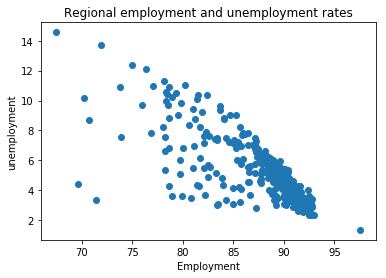

In [91]:
plt.scatter(regional_pop_unemployed['employed_population']/regional_pop_unemployed['total_population']*100,
           regional_pop_unemployed['unemployed_population']/regional_pop_unemployed['total_population']*100)
plt.xlabel('Employment')
plt.ylabel('unemployment')

plt.title('Regional employment and unemployment rates')

In [92]:
# Create an instance of the clusterer with k=2
kmeans2 = cluster.KMeans(n_clusters=2)

In [93]:
clusteringData_df = regional_pop_unemployed[['total_population', 'unemployed_percentage']]
clusteringData_df.head()

,total_population,unemployed_percentage
Region,,
Adur,50579,3.5390182
Allerdale,80155,4.6422556
Amber Valley,100841,4.2522387
Arun,126164,4.1176564
Ashfield,96698,5.4644357


In [94]:
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_clust = kmeans2.fit(clusteringData_df)

In [95]:
assignedClusters_clust.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[]

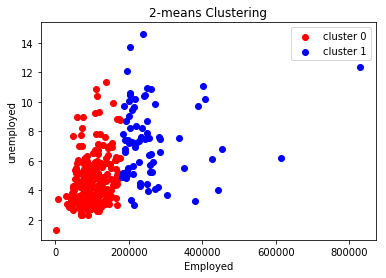

In [96]:
# Plot the data points which in the cluster labelled '0'
plt.scatter(regional_pop_unemployed['total_population'][assignedClusters_clust.labels_==0],
            regional_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(regional_pop_unemployed['total_population'][assignedClusters_clust.labels_==1],
            regional_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

plt.legend()

plt.xlabel('Employed')
plt.ylabel('unemployed')

plt.title('2-means Clustering')

plt.plot()

In [97]:
# First, create an instance of the clusterer with k=3
kmeans3 = cluster.KMeans(n_clusters=3)

# Then call the fit function on the clusterer to fit the data to the 3 means.
assignedClusters_clust = kmeans3.fit(clusteringData_df)

# And see how the data points have been assigned to clusters:
assignedClusters_clust.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 2, 1, 1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 1, 2, 0, 1, 0, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

[]

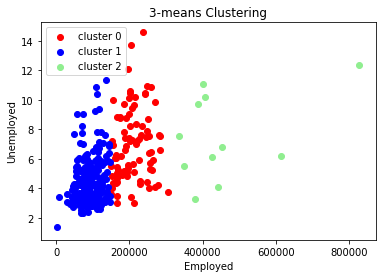

In [98]:
# Plot the data points which in the cluster labelled '0'
plt.scatter(regional_pop_unemployed['total_population'][assignedClusters_clust.labels_==0],
            regional_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(regional_pop_unemployed['total_population'][assignedClusters_clust.labels_==1],
            regional_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(regional_pop_unemployed['total_population'][assignedClusters_clust.labels_==2],
            regional_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==2],
            color='lightGreen', marker='o', label='cluster 2')

plt.legend()

plt.xlabel('Employed')
plt.ylabel('Unemployed')

plt.title('3-means Clustering')

plt.plot()

In [99]:
kmeans3.cluster_centers_

array([[2.08821570e+05, 6.91401956e+00],
       [9.00288287e+04, 4.40192684e+00],
       [4.56552636e+05, 7.51967347e+00]])

[]

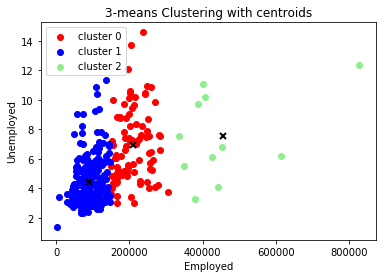

In [100]:
# Plot the data points which in the cluster labelled '0'
plt.scatter(regional_pop_unemployed['total_population'][assignedClusters_clust.labels_==0],
            regional_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(regional_pop_unemployed['total_population'][assignedClusters_clust.labels_==1],
            regional_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(regional_pop_unemployed['total_population'][assignedClusters_clust.labels_==2],
            regional_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==2],
            color='lightGreen', marker='o', label='cluster 2')

# Plot each of the centroids:
for (cx, cy) in assignedClusters_clust.cluster_centers_:
    plt.plot(cx, cy, color='black', marker='x', mew=2)

plt.legend()

plt.xlabel('Employed')
plt.ylabel('Unemployed')

plt.title('3-means Clustering with centroids')

plt.plot()

In [101]:
# First, create an instance of the clusterer with k=4
kmeans3 = cluster.KMeans(n_clusters=4)

# Then call the fit function on the clusterer to fit the data to the 3 means.
assignedClusters_clust = kmeans3.fit(clusteringData_df)

# And see how the data points have been assigned to clusters:
assignedClusters_clust.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 2, 1, 1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 1, 3, 0, 1, 0, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

[]

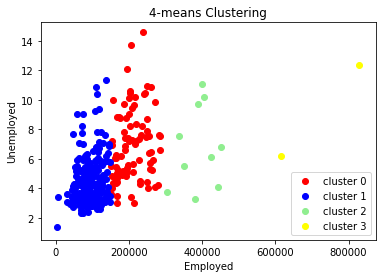

In [102]:
# Plot the data points which in the cluster labelled '0'
plt.scatter(regional_pop_unemployed['total_population'][assignedClusters_clust.labels_==0],
            regional_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(regional_pop_unemployed['total_population'][assignedClusters_clust.labels_==1],
            regional_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(regional_pop_unemployed['total_population'][assignedClusters_clust.labels_==2],
            regional_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==2],
            color='lightGreen', marker='o', label='cluster 2')

# Plot the data points which in the cluster labelled '2'
plt.scatter(regional_pop_unemployed['total_population'][assignedClusters_clust.labels_==3],
            regional_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==3],
            color='Yellow', marker='o', label='cluster 3')

plt.legend()

plt.xlabel('Employed')
plt.ylabel('Unemployed')

plt.title('4-means Clustering')

plt.plot()

In [103]:
regional_pop_employed.index

Index(['Adur ', 'Allerdale ', 'Amber Valley ', 'Arun ', 'Ashfield ',
       'Ashford ', 'Aylesbury Vale ', 'Babergh ', 'Barking and Dagenham ',
       'Barnet ',
       ...
       'Wokingham ', 'Wolverhampton ', 'Worcester ', 'Worthing ', 'Wrexham ',
       'Wychavon ', 'Wycombe ', 'Wyre ', 'Wyre Forest ', 'York '],
      dtype='object', name='Region', length=348)

Text(0.5,1,'Regional employment rates')

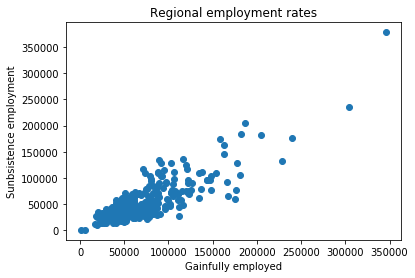

In [104]:
plt.scatter(regional_pop_employed['gainful_population'],
           regional_pop_employed['subsitance_population'])
plt.xlabel('Gainfully employed')
plt.ylabel('Sunbsistence employment')

plt.title('Regional employment rates')


In [105]:
## visualise as scatter charts

In [106]:
## if time permits do country wide heat maps

In [107]:
## import crime data

In [108]:
## merge area populations into constabulary populations and merge on name

In [109]:
Regional_pop = censusrg.drop(['Age','Ethnic_Group','SOAML','Sex'], axis=1)

In [110]:
Counties = Regional_pop

In [111]:
Counties.head()

,1HMAPO,2LMAPO,3IO,4SEOAW,5LSTO,6SRO,7RO,8NWLTUE,9NC
Region,,,,,,,,,
Adur,4194,10942,8078,5782,4005,8181,5108,1790,2499
Allerdale,6099,14815,8239,9094,7774,14432,12397,3721,3584
Amber Valley,9094,19412,11814,9423,9315,16089,16425,4288,4981
Arun,11149,26951,18858,14968,9608,20238,13146,5195,6051
Ashfield,5506,15349,11661,7766,9721,17108,19562,5284,4741


In [112]:
Counties.index = Counties.index.str.strip()

In [113]:
Counties.index

Index(['Adur', 'Allerdale', 'Amber Valley', 'Arun', 'Ashfield', 'Ashford',
       'Aylesbury Vale', 'Babergh', 'Barking and Dagenham', 'Barnet',
       ...
       'Wokingham', 'Wolverhampton', 'Worcester', 'Worthing', 'Wrexham',
       'Wychavon', 'Wycombe', 'Wyre', 'Wyre Forest', 'York'],
      dtype='object', name='Region', length=348)

In [114]:
## build county areas
## Somerset
Counties.loc['Bath and North East Somerset'] += Counties.loc['South Somerset']
Counties.loc['Bath and North East Somerset'] += Counties.loc['West Somerset']
Counties.loc['Bath and North East Somerset'] += Counties.loc['Sedgemoor']
Counties.loc['Bath and North East Somerset'] += Counties.loc['Mendip']
Counties.loc['Bath and North East Somerset'] += Counties.loc['North Somerset']
Counties.loc['Bath and North East Somerset'] += Counties.loc['Taunton Deane']
Counties.drop(['South Somerset'], inplace=True)
Counties.drop(['West Somerset'], inplace=True)
Counties.drop(['Sedgemoor'], inplace=True)
Counties.drop(['Mendip'], inplace=True)
Counties.drop(['North Somerset'], inplace=True)
Counties.drop(['Taunton Deane'], inplace=True)
Counties.rename(index={'Bath and North East Somerset':'Somerset'},inplace=True)

In [115]:
Counties[:20]

,1HMAPO,2LMAPO,3IO,4SEOAW,5LSTO,6SRO,7RO,8NWLTUE,9NC
Region,,,,,,,,,
Adur,4194,10942,8078,5782,4005,8181,5108,1790,2499
Allerdale,6099,14815,8239,9094,7774,14432,12397,3721,3584
Amber Valley,9094,19412,11814,9423,9315,16089,16425,4288,4981
Arun,11149,26951,18858,14968,9608,20238,13146,5195,6051
Ashfield,5506,15349,11661,7766,9721,17108,19562,5284,4741
Ashford,9313,20269,12751,10859,7541,13769,9851,3834,5224
Aylesbury Vale,18120,34449,19822,15149,8665,16485,12311,5221,8345
Babergh,7354,16098,9560,8888,5360,10590,7935,2545,3491
Barking and Dagenham,6686,20407,17873,12484,9636,22490,17969,15566,14502


The following cells contain large amount of code desinged to group the areas into counties

In [116]:
## Bedfordshire
Counties.loc['Bedford'] += Counties.loc['Central Bedfordshire']
Counties.loc['Bedford'] += Counties.loc['Luton']
Counties.drop(['Central Bedfordshire'], inplace=True)
Counties.drop(['Luton'], inplace=True)
Counties.rename(index={'Bedford':'Bedfordshire'},inplace=True)

## Berkshire
Counties.loc['West Berkshire'] += Counties.loc['Reading']
Counties.loc['West Berkshire'] += Counties.loc['Wokingham']
Counties.loc['West Berkshire'] += Counties.loc['Bracknell Forest']
Counties.loc['West Berkshire'] += Counties.loc['Windsor and Maidenhead']
Counties.loc['West Berkshire'] += Counties.loc['Slough']
Counties.drop(['Reading'], inplace=True)
Counties.drop(['Wokingham'], inplace=True)
Counties.drop(['Bracknell Forest'], inplace=True)
Counties.drop(['Windsor and Maidenhead'], inplace=True)
Counties.drop(['Slough'], inplace=True)
Counties.rename(index={'West Berkshire':'Berkshire'},inplace=True)

## City of Bristol
Counties.rename(index={'Bristol':'City of Bristol'},inplace=True)


## Buckinghamshire
Counties.loc['South Bucks'] += Counties.loc['Chiltern']
Counties.loc['South Bucks'] += Counties.loc['Wycombe']
Counties.loc['South Bucks'] += Counties.loc['Aylesbury Vale']
Counties.loc['South Bucks'] += Counties.loc['Milton Keynes']
Counties.drop(['Chiltern'], inplace=True)
Counties.drop(['Wycombe'], inplace=True)
Counties.drop(['Aylesbury Vale'], inplace=True)
Counties.drop(['Milton Keynes'], inplace=True)
Counties.rename(index={'South Bucks':'Buckinghamshire'},inplace=True)

## Cambridgeshire
Counties.loc['Cambridge'] += Counties.loc['South Cambridgeshire']
Counties.loc['Cambridge'] += Counties.loc['East Cambridgeshire']
Counties.loc['Cambridge'] += Counties.loc['Huntingdonshire']
Counties.loc['Cambridge'] += Counties.loc['Fenland']
Counties.loc['Cambridge'] += Counties.loc['Peterborough']
Counties.drop(['South Cambridgeshire'], inplace=True)
Counties.drop(['East Cambridgeshire'], inplace=True)
Counties.drop(['Huntingdonshire'], inplace=True)
Counties.drop(['Fenland'], inplace=True)
Counties.drop(['Peterborough'], inplace=True)
Counties.rename(index={'Cambridge':'Combridgeshire'},inplace=True)

## Cheshire
Counties.loc['Cheshire West and Chester'] += Counties.loc['Cheshire East']
Counties.loc['Cheshire West and Chester'] += Counties.loc['Warrington']
Counties.loc['Cheshire West and Chester'] += Counties.loc['Halton']
Counties.drop(['Cheshire East'], inplace=True)
Counties.drop(['Warrington'], inplace=True)
Counties.drop(['Halton'], inplace=True)
Counties.rename(index={'Cheshire West and Chester':'Cheshire'},inplace=True)

## Cornwal is Cornwal
Counties.loc['Cornwall'] += Counties.loc['Isles of Scilly']
Counties.drop(['Isles of Scilly'], inplace=True)

## Cumbria
Counties.loc['Eden'] += Counties.loc['Barrow-in-Furness']
Counties.loc['Eden'] += Counties.loc['South Lakeland']
Counties.loc['Eden'] += Counties.loc['Copeland']
Counties.loc['Eden'] += Counties.loc['Allerdale']
Counties.loc['Eden'] += Counties.loc['Carlisle']
Counties.drop(['Barrow-in-Furness'], inplace=True)
Counties.drop(['South Lakeland'], inplace=True)
Counties.drop(['Copeland'], inplace=True)
Counties.drop(['Allerdale'], inplace=True)
Counties.drop(['Carlisle'], inplace=True)
Counties.rename(index={'Eden':'Cumbria'},inplace=True)

## Derbyshire
Counties.loc['Derby'] += Counties.loc['High Peak']
Counties.loc['Derby'] += Counties.loc['Derbyshire Dales']
Counties.loc['Derby'] += Counties.loc['South Derbyshire']
Counties.loc['Derby'] += Counties.loc['Erewash']
Counties.loc['Derby'] += Counties.loc['Amber Valley']
Counties.loc['Derby'] += Counties.loc['North East Derbyshire']
Counties.loc['Derby'] += Counties.loc['Chesterfield']
Counties.loc['Derby'] += Counties.loc['Bolsover']
Counties.drop(['High Peak'], inplace=True)
Counties.drop(['Derbyshire Dales'], inplace=True)
Counties.drop(['South Derbyshire'], inplace=True)
Counties.drop(['Erewash'], inplace=True)
Counties.drop(['Amber Valley'], inplace=True)
Counties.drop(['North East Derbyshire'], inplace=True)
Counties.drop(['Chesterfield'], inplace=True)
Counties.drop(['Bolsover'], inplace=True)
Counties.rename(index={'Derby':'Derbyshire'},inplace=True)

## Devon
Counties.loc['Torbay'] += Counties.loc['Exeter']
Counties.loc['Torbay'] += Counties.loc['East Devon']
Counties.loc['Torbay'] += Counties.loc['Mid Devon']
Counties.loc['Torbay'] += Counties.loc['North Devon']
Counties.loc['Torbay'] += Counties.loc['Torridge']
Counties.loc['Torbay'] += Counties.loc['West Devon']
Counties.loc['Torbay'] += Counties.loc['South Hams']
Counties.loc['Torbay'] += Counties.loc['Teignbridge']
Counties.loc['Torbay'] += Counties.loc['Plymouth']
Counties.drop(['Exeter'], inplace=True)
Counties.drop(['East Devon'], inplace=True)
Counties.drop(['Mid Devon'], inplace=True)
Counties.drop(['North Devon'], inplace=True)
Counties.drop(['Torridge'], inplace=True)
Counties.drop(['West Devon'], inplace=True)
Counties.drop(['South Hams'], inplace=True)
Counties.drop(['Teignbridge'], inplace=True)
Counties.drop(['Plymouth'], inplace=True)
Counties.rename(index={'Torbay':'Devon'},inplace=True)

## Dorset
Counties.loc['Poole'] += Counties.loc['Christchurch']
Counties.loc['Poole'] += Counties.loc['Bournemouth']
Counties.loc['Poole'] += Counties.loc['Weymouth and Portland']
Counties.loc['Poole'] += Counties.loc['West Dorset']
Counties.loc['Poole'] += Counties.loc['North Dorset']
Counties.loc['Poole'] += Counties.loc['East Dorset']
Counties.loc['Poole'] += Counties.loc['Purbeck']
Counties.drop(['Christchurch'], inplace=True)
Counties.drop(['Bournemouth'], inplace=True)
Counties.drop(['Weymouth and Portland'], inplace=True)
Counties.drop(['West Dorset'], inplace=True)
Counties.drop(['North Dorset'], inplace=True)
Counties.drop(['East Dorset'], inplace=True)
Counties.drop(['Purbeck'], inplace=True)
Counties.rename(index={'Poole':'Dorset'},inplace=True)

## County Durham
Counties.loc['County Durham'] += Counties.loc['Hartlepool']
Counties.loc['County Durham'] += Counties.loc['Darlington']
Counties.loc['County Durham'] += Counties.loc['Stockton-on-Tees']
Counties.drop(['Hartlepool'], inplace=True)
Counties.drop(['Darlington'], inplace=True)
Counties.drop(['Stockton-on-Tees'], inplace=True)

In [117]:
## East Sussex
Counties.loc['Hastings'] += Counties.loc['Rother']
Counties.loc['Hastings'] += Counties.loc['Wealden']
Counties.loc['Hastings'] += Counties.loc['Eastbourne']
Counties.loc['Hastings'] += Counties.loc['Lewes']
Counties.loc['Hastings'] += Counties.loc['Brighton and Hove']
Counties.drop(['Rother'], inplace=True)
Counties.drop(['Wealden'], inplace=True)
Counties.drop(['Eastbourne'], inplace=True)
Counties.drop(['Lewes'], inplace=True)
Counties.drop(['Brighton and Hove'], inplace=True)
Counties.rename(index={'Hastings':'East Sussex'},inplace=True)

## Essex
Counties.loc['Harlow'] += Counties.loc['Epping Forest']
Counties.loc['Harlow'] += Counties.loc['Brentwood']
Counties.loc['Harlow'] += Counties.loc['Basildon']
Counties.loc['Harlow'] += Counties.loc['Castle Point']
Counties.loc['Harlow'] += Counties.loc['Rochford']
Counties.loc['Harlow'] += Counties.loc['Maldon']
Counties.loc['Harlow'] += Counties.loc['Chelmsford']
Counties.loc['Harlow'] += Counties.loc['Uttlesford']
Counties.loc['Harlow'] += Counties.loc['Braintree']
Counties.loc['Harlow'] += Counties.loc['Colchester']
Counties.loc['Harlow'] += Counties.loc['Tendring']
Counties.loc['Harlow'] += Counties.loc['Thurrock']
Counties.loc['Harlow'] += Counties.loc['Southend-on-Sea']
Counties.drop(['Epping Forest'], inplace=True)
Counties.drop(['Brentwood'], inplace=True)
Counties.drop(['Basildon'], inplace=True)
Counties.drop(['Castle Point'], inplace=True)
Counties.drop(['Rochford'], inplace=True)
Counties.drop(['Maldon'], inplace=True)
Counties.drop(['Chelmsford'], inplace=True)
Counties.drop(['Uttlesford'], inplace=True)
Counties.drop(['Braintree'], inplace=True)
Counties.drop(['Colchester'], inplace=True)
Counties.drop(['Tendring'], inplace=True)
Counties.drop(['Thurrock'], inplace=True)
Counties.drop(['Southend-on-Sea'], inplace=True)
Counties.rename(index={'Harlow':'Essex'},inplace=True)

## Gloucestershire
Counties.loc['Gloucester'] += Counties.loc['Tewkesbury']
Counties.loc['Gloucester'] += Counties.loc['Cheltenham']
Counties.loc['Gloucester'] += Counties.loc['Cotswold']
Counties.loc['Gloucester'] += Counties.loc['Stroud']
Counties.loc['Gloucester'] += Counties.loc['Forest of Dean']
Counties.loc['Gloucester'] += Counties.loc['South Gloucestershire']
Counties.drop(['Tewkesbury'], inplace=True)
Counties.drop(['Cheltenham'], inplace=True)
Counties.drop(['Cotswold'], inplace=True)
Counties.drop(['Stroud'], inplace=True)
Counties.drop(['Forest of Dean'], inplace=True)
Counties.drop(['South Gloucestershire'], inplace=True)
Counties.rename(index={'Gloucester':'Gloucestershire'},inplace=True)

## Greater London
Counties.loc['City of London'] += Counties.loc['Greenwich']
Counties.loc['City of London'] += Counties.loc['Hackney']
Counties.loc['City of London'] += Counties.loc['Hammersmith and Fulham']
Counties.loc['City of London'] += Counties.loc['Islington']
Counties.loc['City of London'] += Counties.loc['Kensington and Chelsea']
Counties.loc['City of London'] += Counties.loc['Lambeth']
Counties.loc['City of London'] += Counties.loc['Lewisham']
Counties.loc['City of London'] += Counties.loc['Southwark']
Counties.loc['City of London'] += Counties.loc['Tower Hamlets']
Counties.loc['City of London'] += Counties.loc['Wandsworth']
Counties.loc['City of London'] += Counties.loc['Westminster']
Counties.loc['City of London'] += Counties.loc['Barking and Dagenham']
Counties.loc['City of London'] += Counties.loc['Barnet']
Counties.loc['City of London'] += Counties.loc['Bexley']
Counties.loc['City of London'] += Counties.loc['Brent']
Counties.loc['City of London'] += Counties.loc['Bromley']
Counties.loc['City of London'] += Counties.loc['Croydon']
Counties.loc['City of London'] += Counties.loc['Ealing']
Counties.loc['City of London'] += Counties.loc['Enfield']
Counties.loc['City of London'] += Counties.loc['Haringey']
Counties.loc['City of London'] += Counties.loc['Harrow']
Counties.loc['City of London'] += Counties.loc['Havering']
Counties.loc['City of London'] += Counties.loc['Hillingdon']
Counties.loc['City of London'] += Counties.loc['Hounslow']
Counties.loc['City of London'] += Counties.loc['Kingston upon Thames']
Counties.loc['City of London'] += Counties.loc['Merton']
Counties.loc['City of London'] += Counties.loc['Newham']
Counties.loc['City of London'] += Counties.loc['Redbridge']
Counties.loc['City of London'] += Counties.loc['Richmond upon Thames']
Counties.loc['City of London'] += Counties.loc['Sutton']
Counties.loc['City of London'] += Counties.loc['Camden']
Counties.loc['City of London'] += Counties.loc['Waltham Forest']
Counties.drop(['Greenwich'], inplace=True)
Counties.drop(['Hackney'], inplace=True)
Counties.drop(['Hammersmith and Fulham'], inplace=True)
Counties.drop(['Islington'], inplace=True)
Counties.drop(['Kensington and Chelsea'], inplace=True)
Counties.drop(['Lambeth'], inplace=True)
Counties.drop(['Lewisham'], inplace=True)
Counties.drop(['Southwark'], inplace=True)
Counties.drop(['Tower Hamlets'], inplace=True)
Counties.drop(['Wandsworth'], inplace=True)
Counties.drop(['Westminster'], inplace=True)
Counties.drop(['Barking and Dagenham'], inplace=True)
Counties.drop(['Barnet'], inplace=True)
Counties.drop(['Bexley'], inplace=True)
Counties.drop(['Brent'], inplace=True)
Counties.drop(['Bromley'], inplace=True)
Counties.drop(['Croydon'], inplace=True)
Counties.drop(['Ealing'], inplace=True)
Counties.drop(['Enfield'], inplace=True)
Counties.drop(['Haringey'], inplace=True)
Counties.drop(['Harrow'], inplace=True)
Counties.drop(['Havering'], inplace=True)
Counties.drop(['Hillingdon'], inplace=True)
Counties.drop(['Hounslow'], inplace=True)
Counties.drop(['Kingston upon Thames'], inplace=True)
Counties.drop(['Merton'], inplace=True)
Counties.drop(['Newham'], inplace=True)
Counties.drop(['Redbridge'], inplace=True)
Counties.drop(['Richmond upon Thames'], inplace=True)
Counties.drop(['Sutton'], inplace=True)
Counties.drop(['Camden'], inplace=True)
Counties.drop(['Waltham Forest'], inplace=True)
Counties.rename(index={'City of London':'Greater London'},inplace=True)


## Greater Manchester
Counties.loc['Manchester'] += Counties.loc['Stockport']
Counties.loc['Manchester'] += Counties.loc['Tameside']
Counties.loc['Manchester'] += Counties.loc['Oldham']
Counties.loc['Manchester'] += Counties.loc['Rochdale']
Counties.loc['Manchester'] += Counties.loc['Bury']
Counties.loc['Manchester'] += Counties.loc['Bolton']
Counties.loc['Manchester'] += Counties.loc['Wigan']
Counties.loc['Manchester'] += Counties.loc['Salford']
Counties.loc['Manchester'] += Counties.loc['Trafford']
Counties.drop(['Stockport'], inplace=True)
Counties.drop(['Tameside'], inplace=True)
Counties.drop(['Oldham'], inplace=True)
Counties.drop(['Rochdale'], inplace=True)
Counties.drop(['Bury'], inplace=True)
Counties.drop(['Bolton'], inplace=True)
Counties.drop(['Wigan'], inplace=True)
Counties.drop(['Salford'], inplace=True)
Counties.drop(['Trafford'], inplace=True)
Counties.rename(index={'Manchester':'Greater Manchester'},inplace=True)

## Hampshire
Counties.loc['Gosport'] += Counties.loc['Fareham']
Counties.loc['Gosport'] += Counties.loc['Winchester']
Counties.loc['Gosport'] += Counties.loc['Havant']
Counties.loc['Gosport'] += Counties.loc['East Hampshire']
Counties.loc['Gosport'] += Counties.loc['Hart']
Counties.loc['Gosport'] += Counties.loc['Rushmoor']
Counties.loc['Gosport'] += Counties.loc['Basingstoke and Deane']
Counties.loc['Gosport'] += Counties.loc['Test Valley']
Counties.loc['Gosport'] += Counties.loc['Eastleigh']
Counties.loc['Gosport'] += Counties.loc['New Forest']
Counties.loc['Gosport'] += Counties.loc['Southampton']
Counties.loc['Gosport'] += Counties.loc['Portsmouth']
Counties.drop(['Fareham'], inplace=True)
Counties.drop(['Winchester'], inplace=True)
Counties.drop(['Havant'], inplace=True)
Counties.drop(['Hart'], inplace=True)
Counties.drop(['Rushmoor'], inplace=True)
Counties.drop(['Basingstoke and Deane'], inplace=True)
Counties.drop(['Test Valley'], inplace=True)
Counties.drop(['Eastleigh'], inplace=True)
Counties.drop(['New Forest'], inplace=True)
Counties.drop(['Southampton'], inplace=True)
Counties.drop(['Portsmouth'], inplace=True)
Counties.drop(['East Hampshire'], inplace=True)
Counties.rename(index={'Gosport':'Hampshire'},inplace=True)
                                 
                                        

## herefordshire is herefordshire

## Hertfordshire
Counties.loc['Three Rivers'] += Counties.loc['Watford']
Counties.loc['Three Rivers'] += Counties.loc['Hertsmere']
Counties.loc['Three Rivers'] += Counties.loc['Welwyn Hatfield']
Counties.loc['Three Rivers'] += Counties.loc['Broxbourne']
Counties.loc['Three Rivers'] += Counties.loc['East Hertfordshire']
Counties.loc['Three Rivers'] += Counties.loc['Stevenage']
Counties.loc['Three Rivers'] += Counties.loc['North Hertfordshire']
Counties.loc['Three Rivers'] += Counties.loc['St Albans']
Counties.loc['Three Rivers'] += Counties.loc['Dacorum']
Counties.drop(['Watford'], inplace=True)
Counties.drop(['Hertsmere'], inplace=True)
Counties.drop(['Welwyn Hatfield'], inplace=True)
Counties.drop(['Broxbourne'], inplace=True)
Counties.drop(['East Hertfordshire'], inplace=True)
Counties.drop(['Stevenage'], inplace=True)
Counties.drop(['North Hertfordshire'], inplace=True)
Counties.drop(['St Albans'], inplace=True)
Counties.drop(['Dacorum'], inplace=True)
Counties.rename(index={'Three Rivers':'Hertfordshire'},inplace=True)
                                        
## isle of white is isle of whight                               
  
## Kent
Counties.loc['Sevenoaks'] += Counties.loc['Dartford']
Counties.loc['Sevenoaks'] += Counties.loc['Gravesham']
Counties.loc['Sevenoaks'] += Counties.loc['Tonbridge and Malling']
Counties.loc['Sevenoaks'] += Counties.loc['Medway']
Counties.loc['Sevenoaks'] += Counties.loc['Maidstone']
Counties.loc['Sevenoaks'] += Counties.loc['Tunbridge Wells']
Counties.loc['Sevenoaks'] += Counties.loc['Swale']
Counties.loc['Sevenoaks'] += Counties.loc['Ashford']
Counties.loc['Sevenoaks'] += Counties.loc['Canterbury']
Counties.loc['Sevenoaks'] += Counties.loc['Thanet']
Counties.loc['Sevenoaks'] += Counties.loc['Dover']
Counties.loc['Sevenoaks'] += Counties.loc['Shepway']
Counties.drop(['Dartford'], inplace=True)
Counties.drop(['Gravesham'], inplace=True)
Counties.drop(['Tonbridge and Malling'], inplace=True)
Counties.drop(['Medway'], inplace=True)
Counties.drop(['Maidstone'], inplace=True)
Counties.drop(['Tunbridge Wells'], inplace=True)
Counties.drop(['Swale'], inplace=True)
Counties.drop(['Ashford'], inplace=True)
Counties.drop(['Canterbury'], inplace=True)
Counties.drop(['Thanet'], inplace=True)
Counties.drop(['Dover'], inplace=True)
Counties.drop(['Shepway'], inplace=True)
Counties.rename(index={'Sevenoaks':'Kent'},inplace=True)
                                        
## Lancashire
Counties.loc['West Lancashire'] += Counties.loc['Chorley']
Counties.loc['West Lancashire'] += Counties.loc['South Ribble']
Counties.loc['West Lancashire'] += Counties.loc['Fylde']
Counties.loc['West Lancashire'] += Counties.loc['Preston']
Counties.loc['West Lancashire'] += Counties.loc['Wyre']
Counties.loc['West Lancashire'] += Counties.loc['Lancaster']
Counties.loc['West Lancashire'] += Counties.loc['Ribble Valley']
Counties.loc['West Lancashire'] += Counties.loc['Pendle']
Counties.loc['West Lancashire'] += Counties.loc['Burnley']
Counties.loc['West Lancashire'] += Counties.loc['Rossendale']
Counties.loc['West Lancashire'] += Counties.loc['Hyndburn']
Counties.loc['West Lancashire'] += Counties.loc['Blackpool']
Counties.loc['West Lancashire'] += Counties.loc['Blackburn with Darwen']
Counties.drop(['Chorley'], inplace=True)
Counties.drop(['South Ribble'], inplace=True)
Counties.drop(['Fylde'], inplace=True)
Counties.drop(['Preston'], inplace=True)
Counties.drop(['Wyre'], inplace=True)
Counties.drop(['Lancaster'], inplace=True)
Counties.drop(['Ribble Valley'], inplace=True)
Counties.drop(['Pendle'], inplace=True)
Counties.drop(['Burnley'], inplace=True)
Counties.drop(['Rossendale'], inplace=True)
Counties.drop(['Hyndburn'], inplace=True)
Counties.drop(['Blackpool'], inplace=True)
Counties.drop(['Blackburn with Darwen'], inplace=True)
Counties.rename(index={'West Lancashire':'Lancashire'},inplace=True)
                                        
## Leicestershire
Counties.loc['Charnwood'] += Counties.loc['Melton']
Counties.loc['Charnwood'] += Counties.loc['Harborough']
Counties.loc['Charnwood'] += Counties.loc['Oadby and Wigston']
Counties.loc['Charnwood'] += Counties.loc['Blaby']
Counties.loc['Charnwood'] += Counties.loc['Hinckley and Bosworth']
Counties.loc['Charnwood'] += Counties.loc['North West Leicestershire']
Counties.loc['Charnwood'] += Counties.loc['Leicester']
Counties.drop(['Melton'], inplace=True)
Counties.drop(['Harborough'], inplace=True)
Counties.drop(['Oadby and Wigston'], inplace=True)
Counties.drop(['Blaby'], inplace=True)
Counties.drop(['Hinckley and Bosworth'], inplace=True)
Counties.drop(['North West Leicestershire'], inplace=True)
Counties.drop(['Leicester'], inplace=True)
Counties.rename(index={'Charnwood':'Leicestershire'},inplace=True)

In [118]:
## lincolnshire
Counties.loc['Lincoln'] += Counties.loc['North Kesteven']
Counties.loc['Lincoln'] += Counties.loc['South Kesteven']
Counties.loc['Lincoln'] += Counties.loc['South Holland']
Counties.loc['Lincoln'] += Counties.loc['Boston']
Counties.loc['Lincoln'] += Counties.loc['East Lindsey']
Counties.loc['Lincoln'] += Counties.loc['West Lindsey']
Counties.loc['Lincoln'] += Counties.loc['North Lincolnshire']
Counties.drop(['North Kesteven'], inplace=True)
Counties.drop(['South Kesteven'], inplace=True)
Counties.drop(['South Holland'], inplace=True)
Counties.drop(['Boston'], inplace=True)
Counties.drop(['East Lindsey'], inplace=True)
Counties.drop(['West Lindsey'], inplace=True)
Counties.drop(['North Lincolnshire'], inplace=True)
Counties.drop(['North East Lincolnshire'], inplace=True)
Counties.rename(index={'Lincoln':'Lincolnshire'},inplace=True)

## Merseyside
Counties.loc['Liverpool'] += Counties.loc['Sefton']
Counties.loc['Liverpool'] += Counties.loc['Knowsley']
Counties.loc['Liverpool'] += Counties.loc['St. Helens']
Counties.loc['Liverpool'] += Counties.loc['Wirral']
Counties.drop(['Sefton'], inplace=True)
Counties.drop(['Knowsley'], inplace=True)
Counties.drop(['St. Helens'], inplace=True)
Counties.drop(['Wirral'], inplace=True)
Counties.rename(index={'Liverpool':'Merseyside'},inplace=True)

##Norfolk
Counties.loc['Norwich'] += Counties.loc['South Norfolk']
Counties.loc['Norwich'] += Counties.loc['Great Yarmouth']
Counties.loc['Norwich'] += Counties.loc['Broadland']
Counties.loc['Norwich'] += Counties.loc['North Norfolk']
Counties.loc['Norwich'] += Counties.loc["King's Lynn and West Norfolk"]
Counties.loc['Norwich'] += Counties.loc['Breckland']
Counties.drop(['South Norfolk'], inplace=True)
Counties.drop(['Great Yarmouth'], inplace=True)
Counties.drop(['Broadland'], inplace=True)
Counties.drop(['North Norfolk'], inplace=True)
Counties.drop(["King's Lynn and West Norfolk"], inplace=True)
Counties.drop(['Breckland'], inplace=True)
Counties.rename(index={'Norwich':'Norfolk'},inplace=True)

## Northhamptonshire
Counties.loc['Northampton'] += Counties.loc['South Northamptonshire']
Counties.loc['Northampton'] += Counties.loc['Daventry']
Counties.loc['Northampton'] += Counties.loc['Wellingborough']
Counties.loc['Northampton'] += Counties.loc['Kettering']
Counties.loc['Northampton'] += Counties.loc['Corby']
Counties.loc['Northampton'] += Counties.loc['East Northamptonshire']
Counties.drop(['South Northamptonshire'], inplace=True)
Counties.drop(['Daventry'], inplace=True)
Counties.drop(['Wellingborough'], inplace=True)
Counties.drop(['Kettering'], inplace=True)
Counties.drop(['Corby'], inplace=True)
Counties.drop(['East Northamptonshire'], inplace=True)
Counties.rename(index={'Northampton':'Northamptonshire'},inplace=True)

## northumberland stays

## North Yorkshire
Counties.loc['Selby'] += Counties.loc['Harrogate']
Counties.loc['Selby'] += Counties.loc['Craven']
Counties.loc['Selby'] += Counties.loc['Richmondshire']
Counties.loc['Selby'] += Counties.loc['Hambleton']
Counties.loc['Selby'] += Counties.loc['Ryedale']
Counties.loc['Selby'] += Counties.loc['Scarborough']
Counties.loc['Selby'] += Counties.loc['York']
Counties.loc['Selby'] += Counties.loc['Redcar and Cleveland']
Counties.loc['Selby'] += Counties.loc['Middlesbrough']
Counties.drop(['Harrogate'], inplace=True)
Counties.drop(['Craven'], inplace=True)
Counties.drop(['Richmondshire'], inplace=True)
Counties.drop(['Hambleton'], inplace=True)
Counties.drop(['Ryedale'], inplace=True)
Counties.drop(['Scarborough'], inplace=True)
Counties.drop(['York'], inplace=True)
Counties.drop(['Redcar and Cleveland'], inplace=True)
Counties.drop(['Middlesbrough'], inplace=True)
Counties.rename(index={'Selby':'North Yorkshire'},inplace=True)

## Notinghamshire
Counties.loc['Rushcliffe'] += Counties.loc['Broxtowe']
Counties.loc['Rushcliffe'] += Counties.loc['Ashfield']
Counties.loc['Rushcliffe'] += Counties.loc['Gedling']
Counties.loc['Rushcliffe'] += Counties.loc['Newark and Sherwood']
Counties.loc['Rushcliffe'] += Counties.loc['Mansfield']
Counties.loc['Rushcliffe'] += Counties.loc['Bassetlaw']
Counties.loc['Rushcliffe'] += Counties.loc['Nottingham']
Counties.drop(['Broxtowe'], inplace=True)
Counties.drop(['Ashfield'], inplace=True)
Counties.drop(['Gedling'], inplace=True)
Counties.drop(['Newark and Sherwood'], inplace=True)
Counties.drop(['Mansfield'], inplace=True)
Counties.drop(['Bassetlaw'], inplace=True)
Counties.drop(['Nottingham'], inplace=True)
Counties.rename(index={'Rushcliffe':'Nottinghamshire'},inplace=True)


## Oxfordshire 
Counties.loc['Oxford'] += Counties.loc['Cherwell']
Counties.loc['Oxford'] += Counties.loc['South Oxfordshire']
Counties.loc['Oxford'] += Counties.loc['Vale of White Horse']
Counties.loc['Oxford'] += Counties.loc['West Oxfordshire']
Counties.drop(['Cherwell'], inplace=True)
Counties.drop(['South Oxfordshire'], inplace=True)
Counties.drop(['Vale of White Horse'], inplace=True)
Counties.drop(['West Oxfordshire'], inplace=True)
Counties.rename(index={'Oxford':'Oxfordshire'},inplace=True)

## Rutland stands alone

## shropshire
Counties.loc['Shropshire'] += Counties.loc['Telford and Wrekin']
Counties.drop(['Telford and Wrekin'], inplace=True)


## South Yorkshire
Counties.loc['Sheffield'] += Counties.loc['Rotherham']
Counties.loc['Sheffield'] += Counties.loc['Doncaster']
Counties.loc['Sheffield'] += Counties.loc['Barnsley']
Counties.drop(['Rotherham'], inplace=True)
Counties.drop(['Doncaster'], inplace=True)
Counties.drop(['Barnsley'], inplace=True)
Counties.rename(index={'Sheffield':'South Yorkshire'},inplace=True)

##Staffordshire
Counties.loc['Tamworth'] += Counties.loc['Lichfield']
Counties.loc['Tamworth'] += Counties.loc['Cannock Chase']
Counties.loc['Tamworth'] += Counties.loc['South Staffordshire']
Counties.loc['Tamworth'] += Counties.loc['Stafford']
Counties.loc['Tamworth'] += Counties.loc['Newcastle-under-Lyme']
Counties.loc['Tamworth'] += Counties.loc['Staffordshire Moorlands']
Counties.loc['Tamworth'] += Counties.loc['East Staffordshire']
Counties.loc['Tamworth'] += Counties.loc['Stoke-on-Trent']
Counties.drop(['Lichfield'], inplace=True)
Counties.drop(['Cannock Chase'], inplace=True)
Counties.drop(['South Staffordshire'], inplace=True)
Counties.drop(['Stafford'], inplace=True)
Counties.drop(['Newcastle-under-Lyme'], inplace=True)
Counties.drop(['Staffordshire Moorlands'], inplace=True)
Counties.drop(['East Staffordshire'], inplace=True)
Counties.drop(['Stoke-on-Trent'], inplace=True)
Counties.rename(index={'Tamworth':'Staffordshire'},inplace=True)

## Suffolk
Counties.loc['Ipswich'] += Counties.loc['Suffolk Coastal']
Counties.loc['Ipswich'] += Counties.loc['Mid Suffolk']
Counties.loc['Ipswich'] += Counties.loc['Babergh']
Counties.loc['Ipswich'] += Counties.loc['Waveney']
Counties.loc['Ipswich'] += Counties.loc['Forest Heath']
Counties.loc['Ipswich'] += Counties.loc['St Edmundsbury']
Counties.drop(['Suffolk Coastal'], inplace=True)
Counties.drop(['Mid Suffolk'], inplace=True)
Counties.drop(['Babergh'], inplace=True)
Counties.drop(['Waveney'], inplace=True)
Counties.drop(['Forest Heath'], inplace=True)
Counties.drop(['St Edmundsbury'], inplace=True)
Counties.rename(index={'Ipswich':'Suffolk'},inplace=True)

##Surrey
Counties.loc['Spelthorne'] += Counties.loc['Runnymede']
Counties.loc['Spelthorne'] += Counties.loc['Surrey Heath']
Counties.loc['Spelthorne'] += Counties.loc['Woking']
Counties.loc['Spelthorne'] += Counties.loc['Elmbridge']
Counties.loc['Spelthorne'] += Counties.loc['Guildford']
Counties.loc['Spelthorne'] += Counties.loc['Waverley']
Counties.loc['Spelthorne'] += Counties.loc['Mole Valley']
Counties.loc['Spelthorne'] += Counties.loc['Epsom and Ewell']
Counties.loc['Spelthorne'] += Counties.loc['Reigate and Banstead']
Counties.loc['Spelthorne'] += Counties.loc['Tandridge']
Counties.drop(['Runnymede'], inplace=True)
Counties.drop(['Surrey Heath'], inplace=True)
Counties.drop(['Woking'], inplace=True)
Counties.drop(['Elmbridge'], inplace=True)
Counties.drop(['Guildford'], inplace=True)
Counties.drop(['Waverley'], inplace=True)
Counties.drop(['Mole Valley'], inplace=True)
Counties.drop(['Epsom and Ewell'], inplace=True)
Counties.drop(['Reigate and Banstead'], inplace=True)
Counties.drop(['Tandridge'], inplace=True)
Counties.rename(index={'Spelthorne':'Surrey'},inplace=True)

##Tyne and Wear
Counties.loc['Gateshead'] += Counties.loc['Newcastle upon Tyne']
Counties.loc['Gateshead'] += Counties.loc['North Tyneside']
Counties.loc['Gateshead'] += Counties.loc['South Tyneside']
Counties.loc['Gateshead'] += Counties.loc['Sunderland']
Counties.drop(['Newcastle upon Tyne'], inplace=True)
Counties.drop(['North Tyneside'], inplace=True)
Counties.drop(['South Tyneside'], inplace=True)
Counties.drop(['Sunderland'], inplace=True)
Counties.rename(index={'Gateshead':'Tyne and Wear'},inplace=True)

##Warwickshire
Counties.loc['Warwick'] += Counties.loc['North Warwickshire']
Counties.loc['Warwick'] += Counties.loc['Nuneaton and Bedworth']
Counties.loc['Warwick'] += Counties.loc['Rugby']
Counties.loc['Warwick'] += Counties.loc['Stratford-on-Avon']
Counties.drop(['North Warwickshire'], inplace=True)
Counties.drop(['Nuneaton and Bedworth'], inplace=True)
Counties.drop(['Rugby'], inplace=True)
Counties.drop(['Stratford-on-Avon'], inplace=True)
Counties.rename(index={'Warwick':'Warwickshire'},inplace=True)

##West Midlands
Counties.loc['Wolverhampton'] += Counties.loc['Dudley']
Counties.loc['Wolverhampton'] += Counties.loc['Walsall']
Counties.loc['Wolverhampton'] += Counties.loc['Sandwell']
Counties.loc['Wolverhampton'] += Counties.loc['Birmingham']
Counties.loc['Wolverhampton'] += Counties.loc['Solihull']
Counties.loc['Wolverhampton'] += Counties.loc['Coventry']
Counties.drop(['Dudley'], inplace=True)
Counties.drop(['Walsall'], inplace=True)
Counties.drop(['Sandwell'], inplace=True)
Counties.drop(['Birmingham'], inplace=True)
Counties.drop(['Solihull'], inplace=True)
Counties.drop(['Coventry'], inplace=True)
Counties.rename(index={'Wolverhampton':'West Midlands'},inplace=True)

##West Sussex
Counties.loc['Worthing'] += Counties.loc['Arun']
Counties.loc['Worthing'] += Counties.loc['Chichester']
Counties.loc['Worthing'] += Counties.loc['Horsham']
Counties.loc['Worthing'] += Counties.loc['Crawley']
Counties.loc['Worthing'] += Counties.loc['Mid Sussex']
Counties.loc['Worthing'] += Counties.loc['Adur']
Counties.drop(['Arun'], inplace=True)
Counties.drop(['Chichester'], inplace=True)
Counties.drop(['Horsham'], inplace=True)
Counties.drop(['Crawley'], inplace=True)
Counties.drop(['Mid Sussex'], inplace=True)
Counties.drop(['Adur'], inplace=True)
Counties.rename(index={'Worthing':'West Sussex'},inplace=True)

##west Yorkshire
Counties.loc['Leeds'] += Counties.loc['Wakefield']
Counties.loc['Leeds'] += Counties.loc['Kirklees']
Counties.loc['Leeds'] += Counties.loc['Calderdale']
Counties.loc['Leeds'] += Counties.loc['Bradford']
Counties.drop(['Wakefield'], inplace=True)
Counties.drop(['Kirklees'], inplace=True)
Counties.drop(['Calderdale'], inplace=True)
Counties.drop(['Bradford'], inplace=True)
Counties.rename(index={'Leeds':'West Yorkshire'},inplace=True)

##Wiltshire
Counties.loc['Wiltshire'] += Counties.loc['Swindon']
Counties.drop(['Swindon'], inplace=True)

##Worcestershire
Counties.loc['Worcester'] += Counties.loc['Malvern Hills']
Counties.loc['Worcester'] += Counties.loc['Wyre Forest']
Counties.loc['Worcester'] += Counties.loc['Bromsgrove']
Counties.loc['Worcester'] += Counties.loc['Redditch']
Counties.loc['Worcester'] += Counties.loc['Wychavon']
Counties.drop(['Malvern Hills'], inplace=True)
Counties.drop(['Wyre Forest'], inplace=True)
Counties.drop(['Bromsgrove'], inplace=True)
Counties.drop(['Redditch'], inplace=True)
Counties.drop(['Wychavon'], inplace=True)
Counties.rename(index={'Worcester':'Worcestershire'},inplace=True)

## East Riding of Yorkshire
Counties.loc['East Riding of Yorkshire'] += Counties.loc['Kingston upon Hull']
Counties.drop(['Kingston upon Hull'], inplace=True)




In [119]:
##South Wales
Counties.loc['Blaenau Gwent'] += Counties.loc['Caerphilly']
Counties.loc['Blaenau Gwent'] += Counties.loc['Newport']
Counties.loc['Blaenau Gwent'] += Counties.loc['Torfaen']
Counties.loc['Blaenau Gwent'] += Counties.loc['Bridgend']
Counties.loc['Blaenau Gwent'] += Counties.loc['Cardiff']
Counties.loc['Blaenau Gwent'] += Counties.loc['Merthyr Tydfil']
Counties.loc['Blaenau Gwent'] += Counties.loc['Neath Port Talbot']
Counties.loc['Blaenau Gwent'] += Counties.loc['Rhondda Cynon Taf']
Counties.loc['Blaenau Gwent'] += Counties.loc['Swansea']
Counties.loc['Blaenau Gwent'] += Counties.loc['The Vale of Glamorgan']
Counties.drop(['Caerphilly'], inplace=True)
Counties.drop(['Newport'], inplace=True)
Counties.drop(['Torfaen'], inplace=True)
Counties.drop(['Bridgend'], inplace=True)
Counties.drop(['Cardiff'], inplace=True)
Counties.drop(['Merthyr Tydfil'], inplace=True)
Counties.drop(['Neath Port Talbot'], inplace=True)
Counties.drop(['Rhondda Cynon Taf'], inplace=True)
Counties.drop(['Swansea'], inplace=True)
Counties.drop(['The Vale of Glamorgan'], inplace=True)
Counties.rename(index={'Blaenau Gwent':'South Wales'},inplace=True)

##North East Wales
Counties.loc['Denbighshire'] += Counties.loc['Flintshire']
Counties.loc['Denbighshire'] += Counties.loc['Wrexham']
Counties.loc['Denbighshire'] += Counties.loc['Conwy']
Counties.drop(['Flintshire'], inplace=True)
Counties.drop(['Wrexham'], inplace=True)
Counties.drop(['Conwy'], inplace=True)
Counties.rename(index={'Denbighshire':'North West Wales'},inplace=True)

##North West Wales
Counties.loc['Gwynedd'] += Counties.loc['Isle of Anglesey']
Counties.loc['Gwynedd'] += Counties.loc['Isle of Anglesey']
Counties.drop(['Isle of Anglesey'], inplace=True)
Counties.rename(index={'Gwynedd':'North West Wales'},inplace=True)

## Mid Wales
Counties.loc['Monmouthshire'] += Counties.loc['Powys']
Counties.drop(['Powys'], inplace=True)
Counties.rename(index={'Monmouthshire':'Mid Wales'},inplace=True)

##West Wales
Counties.loc['Carmarthenshire'] += Counties.loc['Ceredigion']
Counties.loc['Carmarthenshire'] += Counties.loc['Pembrokeshire']
Counties.drop(['Ceredigion'], inplace=True)
Counties.drop(['Pembrokeshire'], inplace=True)
Counties.rename(index={'Carmarthenshire':'West Wales'},inplace=True)


In [120]:
Counties[:40]

,1HMAPO,2LMAPO,3IO,4SEOAW,5LSTO,6SRO,7RO,8NWLTUE,9NC
Region,,,,,,,,,
Somerset,76752,162361,96228,85151,55351,114170,80665,26191,50866
Bedfordshire,46864,98408,66919,46050,35508,66335,56191,29480,41163
South Wales,109482,271067,183940,100746,119141,231341,203650,93324,128905
City of Bristol,41255,69717,42237,24540,21860,48480,38928,19216,43420
Combridgeshire,82584,135038,84214,57511,46169,90118,73299,27896,56135
West Wales,21731,61387,33967,45306,24666,49509,37715,16001,25535
Leicestershire,72438,144647,98696,67569,57453,112759,110260,46168,83678
Cheshire,97230,182365,111467,72356,67795,122154,97410,36125,53241
Greater London,838783,1485859,800898,609674,339945,700758,516885,554819,701552


In [121]:
Counties[40:]

,1HMAPO,2LMAPO,3IO,4SEOAW,5LSTO,6SRO,7RO,8NWLTUE,9NC
Region,,,,,,,,,
Buckinghamshire,82855,144420,85015,59427,36899,70817,52891,25579,38760
Surrey,144486,239538,135980,94419,50938,93855,58538,31206,64939
Staffordshire,73371,169375,113786,81211,73924,143420,137805,44283,61890
Hertfordshire,120814,214006,130995,88238,55476,106748,76783,34171,65307
Devon,80181,193984,121517,119266,69586,145018,105895,38480,70090
Warwickshire,52417,95669,58283,41762,33711,63176,54213,17231,30613
Berkshire,101678,161660,95076,60189,42780,82619,57696,31410,50503
Lancashire,97145,227948,154832,118223,92643,181915,153340,68501,92230
Wiltshire,62908,123157,77840,52350,42127,80351,60804,19818,28432


In [122]:
Counties

,1HMAPO,2LMAPO,3IO,4SEOAW,5LSTO,6SRO,7RO,8NWLTUE,9NC
Region,,,,,,,,,
Somerset,76752,162361,96228,85151,55351,114170,80665,26191,50866
Bedfordshire,46864,98408,66919,46050,35508,66335,56191,29480,41163
South Wales,109482,271067,183940,100746,119141,231341,203650,93324,128905
City of Bristol,41255,69717,42237,24540,21860,48480,38928,19216,43420
Combridgeshire,82584,135038,84214,57511,46169,90118,73299,27896,56135
West Wales,21731,61387,33967,45306,24666,49509,37715,16001,25535
Leicestershire,72438,144647,98696,67569,57453,112759,110260,46168,83678
Cheshire,97230,182365,111467,72356,67795,122154,97410,36125,53241
Greater London,838783,1485859,800898,609674,339945,700758,516885,554819,701552


In [123]:
Counties_pop_unemployed = Counties
Counties_pop_unemployed['total_population'] = Counties_pop_unemployed.apply(lambda row: row['1HMAPO']+row['2LMAPO']+row['3IO']+row['4SEOAW']+row['5LSTO']+row['6SRO']+row['7RO']+row['8NWLTUE']+row['9NC'], axis=1)
Counties_pop_unemployed['unemployed_population'] = Counties_pop_unemployed.apply(lambda row: row['8NWLTUE'], axis=1)
Counties_pop_unemployed['employed_population'] = Counties_pop_unemployed.apply(lambda row: row['1HMAPO']+row['2LMAPO']+row['3IO']+row['4SEOAW']+row['5LSTO']+row['6SRO']+row['7RO'], axis=1)

In [124]:
Counties_pop_employed = Counties
Counties_pop_employed['total_population'] = Counties_pop_employed.apply(lambda row: row['1HMAPO']+row['2LMAPO']+row['3IO']+row['4SEOAW']+row['5LSTO']+row['6SRO']+row['7RO']+row['8NWLTUE']+row['9NC'], axis=1)
Counties_pop_employed['gainful_population'] = Counties_pop_employed.apply(lambda row: row['1HMAPO']+row['2LMAPO']+row['3IO']+row['4SEOAW'], axis=1)
Counties_pop_employed['subsistence_population'] = Counties_pop_employed.apply(lambda row: row['5LSTO']+row['6SRO']+row['7RO']+row['8NWLTUE'], axis=1)

In [125]:
Counties_pop_unemployed = Counties_pop_unemployed[['total_population','unemployed_population','employed_population']]

In [126]:
Counties_pop_employed = Counties_pop_employed[['total_population','gainful_population','subsistence_population']]

In [129]:
def calculate_percentage(row):
    return row['unemployed_population'] / row['total_population'] * 100
Counties_pop_unemployed['unemployed_percentage'] = Counties_pop_unemployed.apply(calculate_percentage, axis =1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [130]:
def calculate_percentage(row):
    return row['employed_population'] / row['total_population'] * 100
Counties_pop_unemployed['employed_percentage'] = Counties_pop_unemployed.apply(calculate_percentage, axis =1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [131]:
def calculate_percentage(row):
    return row['gainful_population'] / row['total_population'] * 100
Counties_pop_employed['gainful_percentage'] = Counties_pop_employed.apply(calculate_percentage, axis =1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [132]:
def calculate_percentage(row):
    return row['subsistence_population'] / row['total_population'] * 100
Counties_pop_employed['subsistence_percentage'] = Counties_pop_employed.apply(calculate_percentage, axis =1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [133]:
Counties_pop_unemployed.head()

,total_population,unemployed_population,employed_population,unemployed_percentage,employed_percentage
Region,,,,,
Somerset,747735,26191,670678,3.5027115,89.6946111
Bedfordshire,486918,29480,416275,6.0544075,85.4918077
South Wales,1441596,93324,1219367,6.4736584,84.5845161
City of Bristol,349653,19216,287017,5.4957343,82.0862398
Combridgeshire,652964,27896,568933,4.2722110,87.1308372


In [153]:
Counties_pop_employed[:40]

,total_population,gainful_population,subsistence_population,gainful_percentage,subsistence_percentage
Region,,,,,
Somerset,747735,420492,276377,56.2354310,36.9618916
Bedfordshire,486918,258241,187514,53.0358294,38.5103857
South Wales,1441596,665235,647456,46.1457301,44.9124443
City of Bristol,349653,177749,128484,50.8358287,36.7461455
Combridgeshire,652964,359347,237482,55.0332024,36.3698458
West Wales,315817,162391,127891,51.4193346,40.4952868
Leicestershire,793668,383350,326640,48.3010528,41.1557477
Cheshire,840143,463418,323484,55.1594193,38.5034452
Greater London,6549173,3735214,2112407,57.0333689,32.2545610


In [154]:
Counties_pop_employed[40:]

,total_population,gainful_population,subsistence_population,gainful_percentage,subsistence_percentage
Region,,,,,
Buckinghamshire,596663,371717,186186,62.2993214,31.2045493
Surrey,913899,614423,234537,67.2309522,25.6633392
Staffordshire,899065,437743,399432,48.6886933,44.4274886
Hertfordshire,892538,554053,273178,62.0761245,30.6068761
Devon,944017,514948,358979,54.5485939,38.0267516
Warwickshire,447075,248131,168331,55.5009786,37.6516244
Berkshire,683611,418603,214505,61.2340937,31.3782253
Lancashire,1186777,598148,496399,50.4010442,41.8274874
Wiltshire,547787,316255,203100,57.7332065,37.0764549


In [135]:
clusteringData_df = Counties_pop_unemployed[['total_population', 'unemployed_percentage']]
clusteringData_df.head()

,total_population,unemployed_percentage
Region,,
Somerset,747735,3.5027115
Bedfordshire,486918,6.0544075
South Wales,1441596,6.4736584
City of Bristol,349653,5.4957343
Combridgeshire,652964,4.2722110


In [136]:
# First, create an instance of the clusterer with k=4
kmeans3 = cluster.KMeans(n_clusters=4)

# Then call the fit function on the clusterer to fit the data to the 3 means.
assignedClusters_clust = kmeans3.fit(clusteringData_df)

# And see how the data points have been assigned to clusters:
assignedClusters_clust.labels_

array([3, 0, 2, 0, 3, 0, 3, 3, 1, 0, 3, 0, 3, 0, 0, 3, 3, 2, 0, 2, 3, 0,
       0, 0, 2, 3, 3, 2, 0, 0, 0, 3, 0, 3, 3, 0, 3, 2, 3, 0, 0, 3, 3, 3,
       3, 0, 3, 3, 0, 2, 0, 3], dtype=int32)

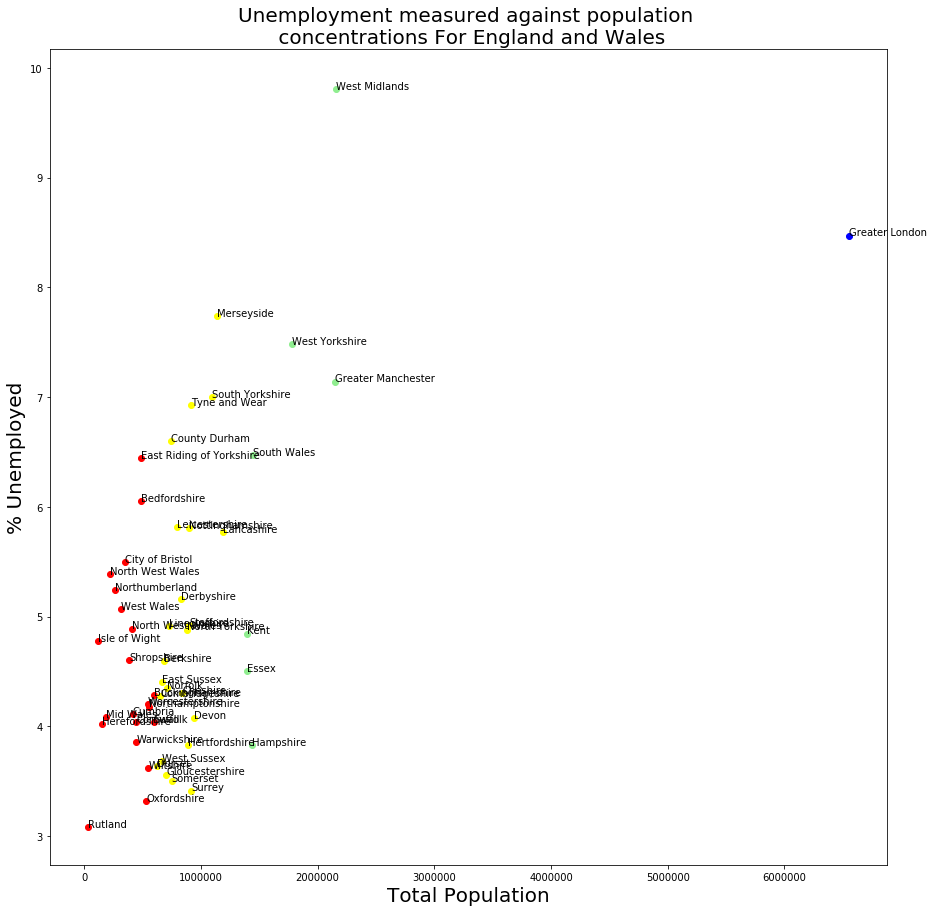

In [137]:
fig = plt.figure(figsize=[15,15])
# Plot the data points which in the cluster labelled '0'
plt.scatter(Counties_pop_unemployed['total_population'][assignedClusters_clust.labels_==0],
            Counties_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(Counties_pop_unemployed['total_population'][assignedClusters_clust.labels_==1],
            Counties_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(Counties_pop_unemployed['total_population'][assignedClusters_clust.labels_==2],
            Counties_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==2],
            color='lightGreen', marker='o', label='cluster 2')

# Plot the data points which in the cluster labelled '2'
plt.scatter(Counties_pop_unemployed['total_population'][assignedClusters_clust.labels_==3],
            Counties_pop_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==3],
            color='Yellow', marker='o', label='cluster 3')

##plt.legend()
## label datapoints
labels = list(Counties_pop_unemployed.index)
for i in range(0,len(labels)):
    xy=(Counties_pop_unemployed['total_population'][i], Counties_pop_unemployed['unemployed_percentage'][i])
    plt.annotate(labels[i],xy)
    
plt.xlabel('Total Population').set_fontsize(20)
plt.ylabel('% Unemployed').set_fontsize(20)
plt.title('Unemployment measured against population \n concentrations For England and Wales').set_fontsize(20)


plt.savefig('Unemployment_Levels.png')

In [138]:
clusteringData_df1 = Counties_pop_employed[['total_population', 'gainful_percentage']]
clusteringData_df1.head()

,total_population,gainful_percentage
Region,,
Somerset,747735,56.2354310
Bedfordshire,486918,53.0358294
South Wales,1441596,46.1457301
City of Bristol,349653,50.8358287
Combridgeshire,652964,55.0332024


In [139]:
# First, create an instance of the clusterer with k=4
kmeans3 = cluster.KMeans(n_clusters=4)

# Then call the fit function on the clusterer to fit the data to the 3 means.
assignedClusters_clust = kmeans3.fit(clusteringData_df1)

# And see how the data points have been assigned to clusters:
assignedClusters_clust.labels_

array([3, 0, 2, 0, 3, 0, 3, 3, 1, 0, 3, 0, 3, 0, 0, 3, 3, 2, 0, 2, 3, 0,
       0, 0, 2, 3, 3, 2, 0, 0, 0, 3, 0, 3, 3, 0, 3, 2, 3, 0, 0, 3, 3, 3,
       3, 0, 3, 3, 0, 2, 0, 3], dtype=int32)

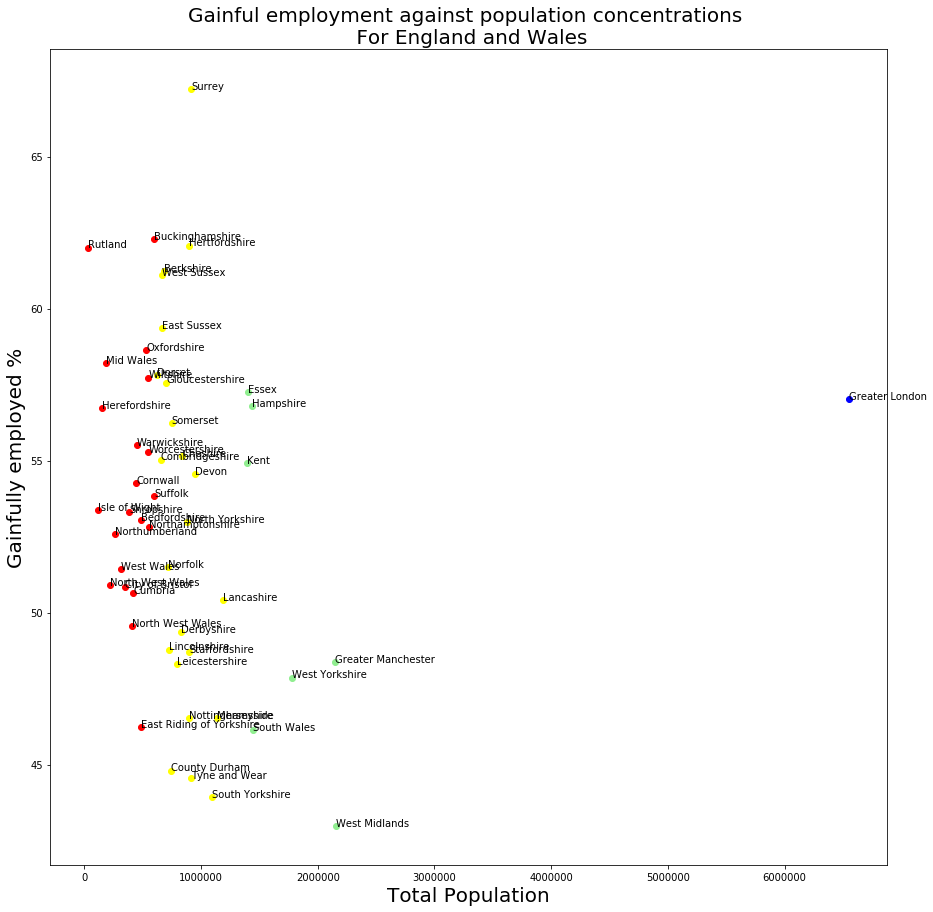

In [140]:
fig = plt.figure(figsize=[15,15])
# Plot the data points which in the cluster labelled '0'
plt.scatter(Counties_pop_employed['total_population'][assignedClusters_clust.labels_==0],
            Counties_pop_employed['gainful_percentage'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(Counties_pop_employed['total_population'][assignedClusters_clust.labels_==1],
            Counties_pop_employed['gainful_percentage'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(Counties_pop_employed['total_population'][assignedClusters_clust.labels_==2],
            Counties_pop_employed['gainful_percentage'][assignedClusters_clust.labels_==2],
            color='lightGreen', marker='o', label='cluster 2')

# Plot the data points which in the cluster labelled '2'
plt.scatter(Counties_pop_employed['total_population'][assignedClusters_clust.labels_==3],
            Counties_pop_employed['gainful_percentage'][assignedClusters_clust.labels_==3],
            color='Yellow', marker='o', label='cluster 3')

##plt.legend()
## label datapoints
labels = list(Counties_pop_unemployed.index)
for i in range(0,len(labels)):
    xy=(Counties_pop_employed['total_population'][i], Counties_pop_employed['gainful_percentage'][i])
    plt.annotate(labels[i],xy)
    
plt.xlabel('Total Population').set_fontsize(20)
plt.ylabel('Gainfully employed %').set_fontsize(20)
plt.title('Gainful employment against population concentrations \n For England and Wales').set_fontsize(20)


plt.savefig('Gainful_employment.png')

In [141]:
clusteringData_df2 = Counties_pop_employed[['total_population', 'subsistence_percentage']]
clusteringData_df2.head()

,total_population,subsistence_percentage
Region,,
Somerset,747735,36.9618916
Bedfordshire,486918,38.5103857
South Wales,1441596,44.9124443
City of Bristol,349653,36.7461455
Combridgeshire,652964,36.3698458


In [142]:
# First, create an instance of the clusterer with k=4
kmeans3 = cluster.KMeans(n_clusters=4)

# Then call the fit function on the clusterer to fit the data to the 3 means.
assignedClusters_clust = kmeans3.fit(clusteringData_df2)

# And see how the data points have been assigned to clusters:
assignedClusters_clust.labels_

array([0, 2, 3, 2, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 0, 3, 2, 3, 0, 2,
       2, 2, 3, 0, 0, 3, 2, 2, 2, 0, 2, 0, 0, 2, 0, 3, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 0, 2, 3, 2, 0], dtype=int32)

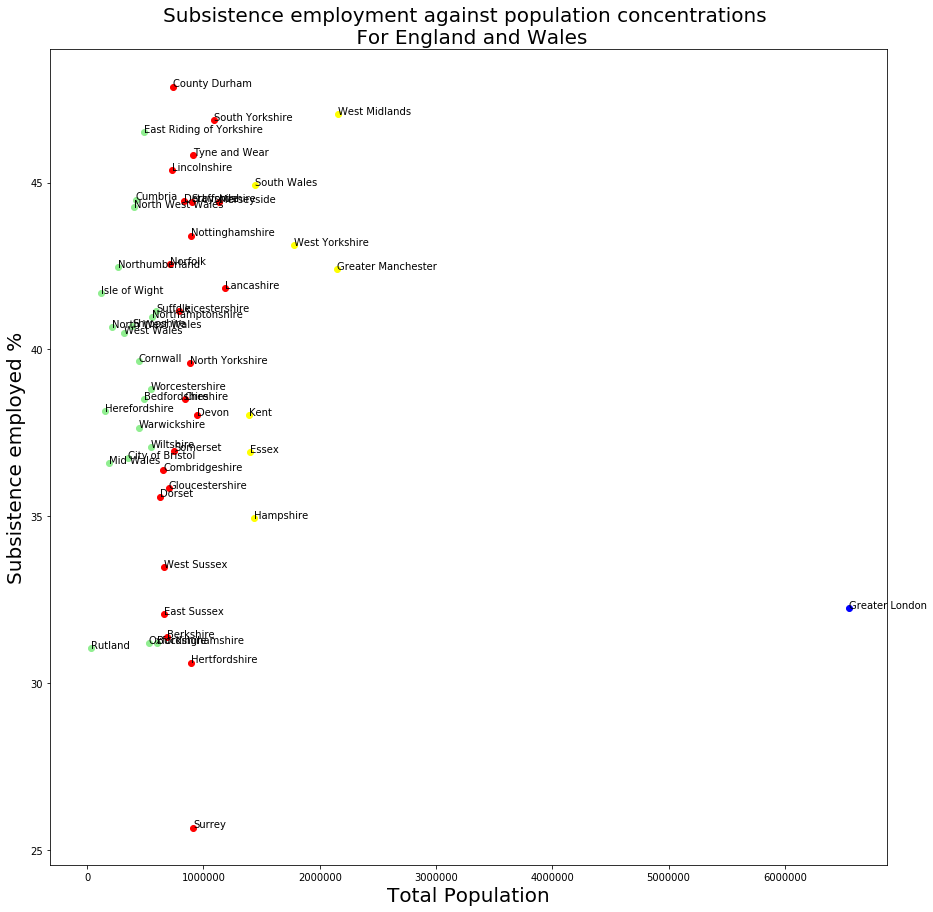

In [143]:
fig = plt.figure(figsize=[15,15])
# Plot the data points which in the cluster labelled '0'
plt.scatter(Counties_pop_employed['total_population'][assignedClusters_clust.labels_==0],
            Counties_pop_employed['subsistence_percentage'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(Counties_pop_employed['total_population'][assignedClusters_clust.labels_==1],
            Counties_pop_employed['subsistence_percentage'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(Counties_pop_employed['total_population'][assignedClusters_clust.labels_==2],
            Counties_pop_employed['subsistence_percentage'][assignedClusters_clust.labels_==2],
            color='lightGreen', marker='o', label='cluster 2')

# Plot the data points which in the cluster labelled '2'
plt.scatter(Counties_pop_employed['total_population'][assignedClusters_clust.labels_==3],
            Counties_pop_employed['subsistence_percentage'][assignedClusters_clust.labels_==3],
            color='Yellow', marker='o', label='cluster 3')

##plt.legend()
## label datapoints
labels = list(Counties_pop_unemployed.index)
for i in range(0,len(labels)):
    xy=(Counties_pop_employed['total_population'][i], Counties_pop_employed['subsistence_percentage'][i])
    plt.annotate(labels[i],xy)
    
plt.xlabel('Total Population').set_fontsize(20)
plt.ylabel('Subsistence employed %').set_fontsize(20)
plt.title('Subsistence employment against population concentrations \n For England and Wales').set_fontsize(20)


plt.savefig('Subsistence_employment.png')

In [144]:
clusteringData_df3 = Counties_pop_employed[['gainful_percentage', 'subsistence_percentage']]
clusteringData_df3.head()

,gainful_percentage,subsistence_percentage
Region,,
Somerset,56.2354310,36.9618916
Bedfordshire,53.0358294,38.5103857
South Wales,46.1457301,44.9124443
City of Bristol,50.8358287,36.7461455
Combridgeshire,55.0332024,36.3698458


In [145]:
# First, create an instance of the clusterer with k=4
kmeans3 = cluster.KMeans(n_clusters=4)

# Then call the fit function on the clusterer to fit the data to the 3 means.
assignedClusters_clust = kmeans3.fit(clusteringData_df3)

# And see how the data points have been assigned to clusters:
assignedClusters_clust.labels_

array([2, 3, 0, 3, 2, 3, 0, 2, 1, 3, 0, 0, 0, 0, 0, 0, 2, 2, 3, 2, 1, 2,
       3, 3, 0, 0, 0, 0, 2, 3, 3, 3, 1, 2, 0, 1, 3, 2, 0, 3, 1, 1, 0, 1,
       2, 2, 1, 3, 2, 0, 2, 1], dtype=int32)

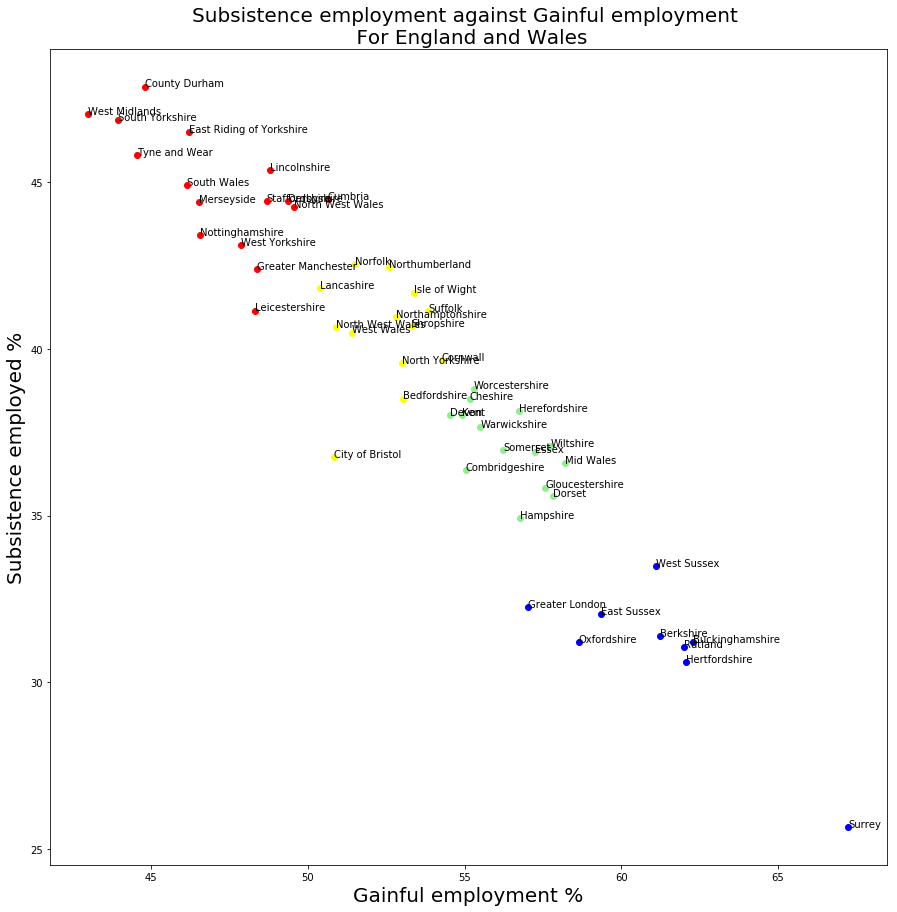

In [146]:
fig = plt.figure(figsize=[15,15])
# Plot the data points which in the cluster labelled '0'
plt.scatter(Counties_pop_employed['gainful_percentage'][assignedClusters_clust.labels_==0],
            Counties_pop_employed['subsistence_percentage'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(Counties_pop_employed['gainful_percentage'][assignedClusters_clust.labels_==1],
            Counties_pop_employed['subsistence_percentage'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(Counties_pop_employed['gainful_percentage'][assignedClusters_clust.labels_==2],
            Counties_pop_employed['subsistence_percentage'][assignedClusters_clust.labels_==2],
            color='lightGreen', marker='o', label='cluster 2')

# Plot the data points which in the cluster labelled '2'
plt.scatter(Counties_pop_employed['gainful_percentage'][assignedClusters_clust.labels_==3],
            Counties_pop_employed['subsistence_percentage'][assignedClusters_clust.labels_==3],
            color='Yellow', marker='o', label='cluster 3')

##plt.legend()
## label datapoints
labels = list(Counties_pop_unemployed.index)
for i in range(0,len(labels)):
    xy=(Counties_pop_employed['gainful_percentage'][i], Counties_pop_employed['subsistence_percentage'][i])
    plt.annotate(labels[i],xy)
    
plt.xlabel('Gainful employment %').set_fontsize(20)
plt.ylabel('Subsistence employed %').set_fontsize(20)
plt.title('Subsistence employment against Gainful employment \n For England and Wales').set_fontsize(20)


plt.savefig('Subsistence_Gainful.png')

In [147]:
## find total crimes per constabulary

In [148]:
# Connect to the crimes database
crimes_db = client.crimes
street = crimes_db.street

In [5]:
street.find_one()

{'Crime type': 'Anti-social behaviour',
 'Falls within': 'Avon and Somerset Constabulary',
 'LSOA code': 'E01014399',
 'LSOA name': 'Bath and North East Somerset 001A',
 'Latitude': 51.416137,
 'Location': 'On or near St Francis Road',
 'Longitude': -2.509126,
 'Month': '2017-06',
 'Reported by': 'Avon and Somerset Constabulary',
 '_id': ObjectId('5c87bb1670b03fd7e8fb47b7'),
 'date': datetime.datetime(2017, 6, 30, 0, 0),
 'loc': {'coordinates': [-2.509126, 51.416137], 'type': 'Point'}}

In [6]:
pipeline = [{'$group': {'_id': {'Crime type': '$Crime type', 
                                'Reported by': '$Reported by'},
                        'Number of crimes': {'$sum': 1}}}]
resultsoffavg = list(street.aggregate(pipeline))
resultsoffavg[:5]

[{'Number of crimes': 421,
  '_id': {'Crime type': 'Theft from the person',
   'Reported by': 'Wiltshire Police'}},
 {'Number of crimes': 890,
  '_id': {'Crime type': 'Bicycle theft', 'Reported by': 'Wiltshire Police'}},
 {'Number of crimes': 277,
  '_id': {'Crime type': 'Robbery', 'Reported by': 'Wiltshire Police'}},
 {'Number of crimes': 4278,
  '_id': {'Crime type': 'Shoplifting', 'Reported by': 'Wiltshire Police'}},
 {'Number of crimes': 297,
  '_id': {'Crime type': 'Possession of weapons',
   'Reported by': 'Wiltshire Police'}}]

In [14]:
ukcrimes = results_to_table(resultsoffavg, 'Reported by', 'Crime type', 'Number of crimes', fillna=0)

In [15]:
ukcrimes.head()

Crime type,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences
Reported by,,,,,,,,,,,,,,
Avon and Somerset Constabulary,36902.0,3463.0,11281.0,16068.0,2699.0,1874.0,14325.0,805.0,18460.0,1448.0,11351.0,1116.0,12004.0,48006.0
Bedfordshire Police,20381.0,1014.0,5874.0,5840.0,799.0,532.0,5034.0,339.0,2556.0,722.0,3767.0,694.0,6081.0,12613.0
British Transport Police,0.0,6021.0,258.0,3996.0,1427.0,672.0,8409.0,601.0,10373.0,522.0,2279.0,5449.0,1112.0,12195.0
Cambridgeshire Constabulary,17230.0,3813.0,5597.0,7318.0,1221.0,903.0,7351.0,456.0,3693.0,584.0,4937.0,945.0,6059.0,16623.0
Cheshire Constabulary,21479.0,1297.0,4492.0,9667.0,2103.0,1609.0,6869.0,450.0,15523.0,352.0,7198.0,545.0,3446.0,28724.0


In [16]:
ukcrimes['uk sum'] = ukcrimes.sum(axis=1)

In [149]:
ukcrimes.head()

Crime type,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences,uk sum
Reported by,,,,,,,,,,,,,,,
Avon and Somerset Constabulary,36902.0,3463.0,11281.0,16068.0,2699.0,1874.0,14325.0,805.0,18460.0,1448.0,11351.0,1116.0,12004.0,48006.0,179802.0
Bedfordshire Police,20381.0,1014.0,5874.0,5840.0,799.0,532.0,5034.0,339.0,2556.0,722.0,3767.0,694.0,6081.0,12613.0,66246.0
British Transport Police,0.0,6021.0,258.0,3996.0,1427.0,672.0,8409.0,601.0,10373.0,522.0,2279.0,5449.0,1112.0,12195.0,53314.0
Cambridgeshire Constabulary,17230.0,3813.0,5597.0,7318.0,1221.0,903.0,7351.0,456.0,3693.0,584.0,4937.0,945.0,6059.0,16623.0,76730.0
Cheshire Constabulary,21479.0,1297.0,4492.0,9667.0,2103.0,1609.0,6869.0,450.0,15523.0,352.0,7198.0,545.0,3446.0,28724.0,103754.0


In [150]:
Counties_pop_employed.head()

,total_population,gainful_population,subsistence_population,gainful_percentage,subsistence_percentage
Region,,,,,
Somerset,747735,420492,276377,56.2354310,36.9618916
Bedfordshire,486918,258241,187514,53.0358294,38.5103857
South Wales,1441596,665235,647456,46.1457301,44.9124443
City of Bristol,349653,177749,128484,50.8358287,36.7461455
Combridgeshire,652964,359347,237482,55.0332024,36.3698458


In [151]:
Counties_pop_unemployed.head()

,total_population,unemployed_population,employed_population,unemployed_percentage,employed_percentage
Region,,,,,
Somerset,747735,26191,670678,3.5027115,89.6946111
Bedfordshire,486918,29480,416275,6.0544075,85.4918077
South Wales,1441596,93324,1219367,6.4736584,84.5845161
City of Bristol,349653,19216,287017,5.4957343,82.0862398
Combridgeshire,652964,27896,568933,4.2722110,87.1308372


In [256]:
Regional_pop = censusrg.drop(['Age','Ethnic_Group','SOAML','Sex'], axis=1)

In [257]:
Constabularies = Regional_pop

In [258]:
Constabularies.head()

,1HMAPO,2LMAPO,3IO,4SEOAW,5LSTO,6SRO,7RO,8NWLTUE,9NC
Region,,,,,,,,,
Adur,4194,10942,8078,5782,4005,8181,5108,1790,2499
Allerdale,6099,14815,8239,9094,7774,14432,12397,3721,3584
Amber Valley,9094,19412,11814,9423,9315,16089,16425,4288,4981
Arun,11149,26951,18858,14968,9608,20238,13146,5195,6051
Ashfield,5506,15349,11661,7766,9721,17108,19562,5284,4741


In [259]:
Constabularies.index = Constabularies.index.str.strip()

In [260]:
## Avon and somerset constabulary
Constabularies.loc['Bath and North East Somerset'] += Constabularies.loc['South Somerset']
Constabularies.loc['Bath and North East Somerset'] += Constabularies.loc['West Somerset']
Constabularies.loc['Bath and North East Somerset'] += Constabularies.loc['Sedgemoor']
Constabularies.loc['Bath and North East Somerset'] += Constabularies.loc['Mendip']
Constabularies.loc['Bath and North East Somerset'] += Constabularies.loc['North Somerset']
Constabularies.loc['Bath and North East Somerset'] += Constabularies.loc['Taunton Deane']
Constabularies.loc['Bath and North East Somerset'] += Constabularies.loc['South Gloucestershire']
Constabularies.loc['Bath and North East Somerset'] += Constabularies.loc['Bristol']
Constabularies.drop(['South Somerset'], inplace=True)
Constabularies.drop(['West Somerset'], inplace=True)
Constabularies.drop(['Sedgemoor'], inplace=True)
Constabularies.drop(['Mendip'], inplace=True)
Constabularies.drop(['North Somerset'], inplace=True)
Constabularies.drop(['Taunton Deane'], inplace=True)
Constabularies.drop(['South Gloucestershire'], inplace=True)
Constabularies.drop(['Bristol'], inplace=True)
Constabularies.rename(index={'Bath and North East Somerset':'Avon and Somerset Constabulary'},inplace=True)
## Bedfordshire Police
Constabularies.loc['Bedford'] += Constabularies.loc['Central Bedfordshire']
Constabularies.loc['Bedford'] += Constabularies.loc['Luton']
Constabularies.drop(['Central Bedfordshire'], inplace=True)
Constabularies.drop(['Luton'], inplace=True)
Constabularies.rename(index={'Bedford':'Bedfordshire Police'},inplace=True)
## Thames Valley Police
Constabularies.loc['South Bucks'] += Constabularies.loc['Chiltern']
Constabularies.loc['South Bucks'] += Constabularies.loc['Wycombe']
Constabularies.loc['South Bucks'] += Constabularies.loc['Aylesbury Vale']
Constabularies.loc['South Bucks'] += Constabularies.loc['Milton Keynes']
Constabularies.loc['South Bucks'] += Constabularies.loc['West Berkshire']
Constabularies.loc['South Bucks'] += Constabularies.loc['Reading']
Constabularies.loc['South Bucks'] += Constabularies.loc['Wokingham']
Constabularies.loc['South Bucks'] += Constabularies.loc['Bracknell Forest']
Constabularies.loc['South Bucks'] += Constabularies.loc['Windsor and Maidenhead']
Constabularies.loc['South Bucks'] += Constabularies.loc['Slough']
Constabularies.loc['South Bucks'] += Constabularies.loc['Oxford']
Constabularies.loc['South Bucks'] += Constabularies.loc['Cherwell']
Constabularies.loc['South Bucks'] += Constabularies.loc['South Oxfordshire']
Constabularies.loc['South Bucks'] += Constabularies.loc['Vale of White Horse']
Constabularies.loc['South Bucks'] += Constabularies.loc['West Oxfordshire']
Constabularies.drop(['Chiltern'], inplace=True)
Constabularies.drop(['Wycombe'], inplace=True)
Constabularies.drop(['Aylesbury Vale'], inplace=True)
Constabularies.drop(['Milton Keynes'], inplace=True)
Constabularies.drop(['West Berkshire'], inplace=True)
Constabularies.drop(['Reading'], inplace=True)
Constabularies.drop(['Wokingham'], inplace=True)
Constabularies.drop(['Bracknell Forest'], inplace=True)
Constabularies.drop(['Windsor and Maidenhead'], inplace=True)
Constabularies.drop(['Slough'], inplace=True)
Constabularies.drop(['Oxford'], inplace=True)
Constabularies.drop(['Cherwell'], inplace=True)
Constabularies.drop(['South Oxfordshire'], inplace=True)
Constabularies.drop(['Vale of White Horse'], inplace=True)
Constabularies.drop(['West Oxfordshire'], inplace=True)
Constabularies.rename(index={'South Bucks':'Thames Valley Police'},inplace=True)
## Cambridgeshire Constabulary
Constabularies.loc['Cambridge'] += Constabularies.loc['South Cambridgeshire']
Constabularies.loc['Cambridge'] += Constabularies.loc['East Cambridgeshire']
Constabularies.loc['Cambridge'] += Constabularies.loc['Huntingdonshire']
Constabularies.loc['Cambridge'] += Constabularies.loc['Fenland']
Constabularies.loc['Cambridge'] += Constabularies.loc['Peterborough']
Constabularies.drop(['South Cambridgeshire'], inplace=True)
Constabularies.drop(['East Cambridgeshire'], inplace=True)
Constabularies.drop(['Huntingdonshire'], inplace=True)
Constabularies.drop(['Fenland'], inplace=True)
Constabularies.drop(['Peterborough'], inplace=True)
Constabularies.rename(index={'Cambridge':'Cambridgeshire Constabulary'},inplace=True)
## Cheshire Constabulary
Constabularies.loc['Cheshire West and Chester'] += Constabularies.loc['Cheshire East']
Constabularies.loc['Cheshire West and Chester'] += Constabularies.loc['Warrington']
Constabularies.loc['Cheshire West and Chester'] += Constabularies.loc['Halton']
Constabularies.drop(['Cheshire East'], inplace=True)
Constabularies.drop(['Warrington'], inplace=True)
Constabularies.drop(['Halton'], inplace=True)
Constabularies.rename(index={'Cheshire West and Chester':'Cheshire Constabulary'},inplace=True)
## Devon and Cornwal police
Constabularies.loc['Cornwall'] += Constabularies.loc['Isles of Scilly']
Constabularies.loc['Torbay'] += Constabularies.loc['Cornwall']
Constabularies.loc['Torbay'] += Constabularies.loc['Isles of Scilly']
Constabularies.loc['Torbay'] += Constabularies.loc['Exeter']
Constabularies.loc['Torbay'] += Constabularies.loc['East Devon']
Constabularies.loc['Torbay'] += Constabularies.loc['Mid Devon']
Constabularies.loc['Torbay'] += Constabularies.loc['North Devon']
Constabularies.loc['Torbay'] += Constabularies.loc['Torridge']
Constabularies.loc['Torbay'] += Constabularies.loc['West Devon']
Constabularies.loc['Torbay'] += Constabularies.loc['South Hams']
Constabularies.loc['Torbay'] += Constabularies.loc['Teignbridge']
Constabularies.loc['Torbay'] += Constabularies.loc['Plymouth']
Constabularies.drop(['Cornwall'], inplace=True)
Constabularies.drop(['Isles of Scilly'], inplace=True)
Constabularies.drop(['Exeter'], inplace=True)
Constabularies.drop(['East Devon'], inplace=True)
Constabularies.drop(['Mid Devon'], inplace=True)
Constabularies.drop(['North Devon'], inplace=True)
Constabularies.drop(['Torridge'], inplace=True)
Constabularies.drop(['West Devon'], inplace=True)
Constabularies.drop(['South Hams'], inplace=True)
Constabularies.drop(['Teignbridge'], inplace=True)
Constabularies.drop(['Plymouth'], inplace=True)
Constabularies.rename(index={'Torbay':'Devon & Cornwall Police'},inplace=True)
## Cumbria Constabulary
Constabularies.loc['Eden'] += Constabularies.loc['Barrow-in-Furness']
Constabularies.loc['Eden'] += Constabularies.loc['South Lakeland']
Constabularies.loc['Eden'] += Constabularies.loc['Copeland']
Constabularies.loc['Eden'] += Constabularies.loc['Allerdale']
Constabularies.loc['Eden'] += Constabularies.loc['Carlisle']
Constabularies.drop(['Barrow-in-Furness'], inplace=True)
Constabularies.drop(['South Lakeland'], inplace=True)
Constabularies.drop(['Copeland'], inplace=True)
Constabularies.drop(['Allerdale'], inplace=True)
Constabularies.drop(['Carlisle'], inplace=True)
Constabularies.rename(index={'Eden':'Cumbria Constabulary'},inplace=True)
## Derbyshire COnstabulary
Constabularies.loc['Derby'] += Constabularies.loc['High Peak']
Constabularies.loc['Derby'] += Constabularies.loc['Derbyshire Dales']
Constabularies.loc['Derby'] += Constabularies.loc['South Derbyshire']
Constabularies.loc['Derby'] += Constabularies.loc['Erewash']
Constabularies.loc['Derby'] += Constabularies.loc['Amber Valley']
Constabularies.loc['Derby'] += Constabularies.loc['North East Derbyshire']
Constabularies.loc['Derby'] += Constabularies.loc['Chesterfield']
Constabularies.loc['Derby'] += Constabularies.loc['Bolsover']
Constabularies.drop(['High Peak'], inplace=True)
Constabularies.drop(['Derbyshire Dales'], inplace=True)
Constabularies.drop(['South Derbyshire'], inplace=True)
Constabularies.drop(['Erewash'], inplace=True)
Constabularies.drop(['Amber Valley'], inplace=True)
Constabularies.drop(['North East Derbyshire'], inplace=True)
Constabularies.drop(['Chesterfield'], inplace=True)
Constabularies.drop(['Bolsover'], inplace=True)
Constabularies.rename(index={'Derby':'Derbyshire Constabulary'},inplace=True)
## Dorset Police
Constabularies.loc['Poole'] += Constabularies.loc['Christchurch']
Constabularies.loc['Poole'] += Constabularies.loc['Bournemouth']
Constabularies.loc['Poole'] += Constabularies.loc['Weymouth and Portland']
Constabularies.loc['Poole'] += Constabularies.loc['West Dorset']
Constabularies.loc['Poole'] += Constabularies.loc['North Dorset']
Constabularies.loc['Poole'] += Constabularies.loc['East Dorset']
Constabularies.loc['Poole'] += Constabularies.loc['Purbeck']
Constabularies.drop(['Christchurch'], inplace=True)
Constabularies.drop(['Bournemouth'], inplace=True)
Constabularies.drop(['Weymouth and Portland'], inplace=True)
Constabularies.drop(['West Dorset'], inplace=True)
Constabularies.drop(['North Dorset'], inplace=True)
Constabularies.drop(['East Dorset'], inplace=True)
Constabularies.drop(['Purbeck'], inplace=True)
Constabularies.rename(index={'Poole':'Dorset Police'},inplace=True)
## Cleveland Police
Constabularies.loc['Redcar and Cleveland'] += Constabularies.loc['Middlesbrough']
Constabularies.loc['Redcar and Cleveland'] += Constabularies.loc['Hartlepool']
Constabularies.loc['Redcar and Cleveland'] += Constabularies.loc['Stockton-on-Tees']
Constabularies.drop(['Hartlepool'], inplace=True)
Constabularies.drop(['Middlesbrough'], inplace=True)
Constabularies.drop(['Stockton-on-Tees'], inplace=True)
Constabularies.rename(index={'Redcar and Cleveland':'Cleveland Police'},inplace=True)
##Durham Constabulary
Constabularies.loc['County Durham'] += Constabularies.loc['Darlington']
Constabularies.drop(['Darlington'], inplace=True)
Constabularies.rename(index={'County Durham':'Durham Constabulary'},inplace=True)
## Essex Police
Constabularies.loc['Harlow'] += Constabularies.loc['Epping Forest']
Constabularies.loc['Harlow'] += Constabularies.loc['Brentwood']
Constabularies.loc['Harlow'] += Constabularies.loc['Basildon']
Constabularies.loc['Harlow'] += Constabularies.loc['Castle Point']
Constabularies.loc['Harlow'] += Constabularies.loc['Rochford']
Constabularies.loc['Harlow'] += Constabularies.loc['Maldon']
Constabularies.loc['Harlow'] += Constabularies.loc['Chelmsford']
Constabularies.loc['Harlow'] += Constabularies.loc['Uttlesford']
Constabularies.loc['Harlow'] += Constabularies.loc['Braintree']
Constabularies.loc['Harlow'] += Constabularies.loc['Colchester']
Constabularies.loc['Harlow'] += Constabularies.loc['Tendring']
Constabularies.loc['Harlow'] += Constabularies.loc['Thurrock']
Constabularies.loc['Harlow'] += Constabularies.loc['Southend-on-Sea']
Constabularies.drop(['Epping Forest'], inplace=True)
Constabularies.drop(['Brentwood'], inplace=True)
Constabularies.drop(['Basildon'], inplace=True)
Constabularies.drop(['Castle Point'], inplace=True)
Constabularies.drop(['Rochford'], inplace=True)
Constabularies.drop(['Maldon'], inplace=True)
Constabularies.drop(['Chelmsford'], inplace=True)
Constabularies.drop(['Uttlesford'], inplace=True)
Constabularies.drop(['Braintree'], inplace=True)
Constabularies.drop(['Colchester'], inplace=True)
Constabularies.drop(['Tendring'], inplace=True)
Constabularies.drop(['Thurrock'], inplace=True)
Constabularies.drop(['Southend-on-Sea'], inplace=True)
Constabularies.rename(index={'Harlow':'Essex Police'},inplace=True)
## Gloucestershire Constabulary
Constabularies.loc['Gloucester'] += Constabularies.loc['Tewkesbury']
Constabularies.loc['Gloucester'] += Constabularies.loc['Cheltenham']
Constabularies.loc['Gloucester'] += Constabularies.loc['Cotswold']
Constabularies.loc['Gloucester'] += Constabularies.loc['Stroud']
Constabularies.loc['Gloucester'] += Constabularies.loc['Forest of Dean']
Constabularies.drop(['Tewkesbury'], inplace=True)
Constabularies.drop(['Cheltenham'], inplace=True)
Constabularies.drop(['Cotswold'], inplace=True)
Constabularies.drop(['Stroud'], inplace=True)
Constabularies.drop(['Forest of Dean'], inplace=True)
Constabularies.rename(index={'Gloucester':'Gloucestershire Constabulary'},inplace=True)
## Metropolitan Police
Constabularies.loc['Greenwich'] += Constabularies.loc['Hackney']
Constabularies.loc['Greenwich'] += Constabularies.loc['Hammersmith and Fulham']
Constabularies.loc['Greenwich'] += Constabularies.loc['Islington']
Constabularies.loc['Greenwich'] += Constabularies.loc['Kensington and Chelsea']
Constabularies.loc['Greenwich'] += Constabularies.loc['Lambeth']
Constabularies.loc['Greenwich'] += Constabularies.loc['Lewisham']
Constabularies.loc['Greenwich'] += Constabularies.loc['Southwark']
Constabularies.loc['Greenwich'] += Constabularies.loc['Tower Hamlets']
Constabularies.loc['Greenwich'] += Constabularies.loc['Wandsworth']
Constabularies.loc['Greenwich'] += Constabularies.loc['Westminster']
Constabularies.loc['Greenwich'] += Constabularies.loc['Barking and Dagenham']
Constabularies.loc['Greenwich'] += Constabularies.loc['Barnet']
Constabularies.loc['Greenwich'] += Constabularies.loc['Bexley']
Constabularies.loc['Greenwich'] += Constabularies.loc['Brent']
Constabularies.loc['Greenwich'] += Constabularies.loc['Bromley']
Constabularies.loc['Greenwich'] += Constabularies.loc['Croydon']
Constabularies.loc['Greenwich'] += Constabularies.loc['Ealing']
Constabularies.loc['Greenwich'] += Constabularies.loc['Enfield']
Constabularies.loc['Greenwich'] += Constabularies.loc['Haringey']
Constabularies.loc['Greenwich'] += Constabularies.loc['Harrow']
Constabularies.loc['Greenwich'] += Constabularies.loc['Havering']
Constabularies.loc['Greenwich'] += Constabularies.loc['Hillingdon']
Constabularies.loc['Greenwich'] += Constabularies.loc['Hounslow']
Constabularies.loc['Greenwich'] += Constabularies.loc['Kingston upon Thames']
Constabularies.loc['Greenwich'] += Constabularies.loc['Merton']
Constabularies.loc['Greenwich'] += Constabularies.loc['Newham']
Constabularies.loc['Greenwich'] += Constabularies.loc['Redbridge']
Constabularies.loc['Greenwich'] += Constabularies.loc['Richmond upon Thames']
Constabularies.loc['Greenwich'] += Constabularies.loc['Sutton']
Constabularies.loc['Greenwich'] += Constabularies.loc['Camden']
Constabularies.loc['Greenwich'] += Constabularies.loc['Waltham Forest']
Constabularies.drop(['Hackney'], inplace=True)
Constabularies.drop(['Hammersmith and Fulham'], inplace=True)
Constabularies.drop(['Islington'], inplace=True)
Constabularies.drop(['Kensington and Chelsea'], inplace=True)
Constabularies.drop(['Lambeth'], inplace=True)
Constabularies.drop(['Lewisham'], inplace=True)
Constabularies.drop(['Southwark'], inplace=True)
Constabularies.drop(['Tower Hamlets'], inplace=True)
Constabularies.drop(['Wandsworth'], inplace=True)
Constabularies.drop(['Westminster'], inplace=True)
Constabularies.drop(['Barking and Dagenham'], inplace=True)
Constabularies.drop(['Barnet'], inplace=True)
Constabularies.drop(['Bexley'], inplace=True)
Constabularies.drop(['Brent'], inplace=True)
Constabularies.drop(['Bromley'], inplace=True)
Constabularies.drop(['Croydon'], inplace=True)
Constabularies.drop(['Ealing'], inplace=True)
Constabularies.drop(['Enfield'], inplace=True)
Constabularies.drop(['Haringey'], inplace=True)
Constabularies.drop(['Harrow'], inplace=True)
Constabularies.drop(['Havering'], inplace=True)
Constabularies.drop(['Hillingdon'], inplace=True)
Constabularies.drop(['Hounslow'], inplace=True)
Constabularies.drop(['Kingston upon Thames'], inplace=True)
Constabularies.drop(['Merton'], inplace=True)
Constabularies.drop(['Newham'], inplace=True)
Constabularies.drop(['Redbridge'], inplace=True)
Constabularies.drop(['Richmond upon Thames'], inplace=True)
Constabularies.drop(['Sutton'], inplace=True)
Constabularies.drop(['Camden'], inplace=True)
Constabularies.drop(['Waltham Forest'], inplace=True)
Constabularies.rename(index={'Greenwich':'Metropolitan Police Service'},inplace=True)
Constabularies.rename(index={'City of London':'City of London Police'},inplace=True)
## Greater Manchester Police
Constabularies.loc['Manchester'] += Constabularies.loc['Stockport']
Constabularies.loc['Manchester'] += Constabularies.loc['Tameside']
Constabularies.loc['Manchester'] += Constabularies.loc['Oldham']
Constabularies.loc['Manchester'] += Constabularies.loc['Rochdale']
Constabularies.loc['Manchester'] += Constabularies.loc['Bury']
Constabularies.loc['Manchester'] += Constabularies.loc['Bolton']
Constabularies.loc['Manchester'] += Constabularies.loc['Wigan']
Constabularies.loc['Manchester'] += Constabularies.loc['Salford']
Constabularies.loc['Manchester'] += Constabularies.loc['Trafford']
Constabularies.drop(['Stockport'], inplace=True)
Constabularies.drop(['Tameside'], inplace=True)
Constabularies.drop(['Oldham'], inplace=True)
Constabularies.drop(['Rochdale'], inplace=True)
Constabularies.drop(['Bury'], inplace=True)
Constabularies.drop(['Bolton'], inplace=True)
Constabularies.drop(['Wigan'], inplace=True)
Constabularies.drop(['Salford'], inplace=True)
Constabularies.drop(['Trafford'], inplace=True)
Constabularies.rename(index={'Manchester':'Greater Manchester Police'},inplace=True)
## Hampshire Constabulary
Constabularies.loc['Gosport'] += Constabularies.loc['Fareham']
Constabularies.loc['Gosport'] += Constabularies.loc['Winchester']
Constabularies.loc['Gosport'] += Constabularies.loc['Havant']
Constabularies.loc['Gosport'] += Constabularies.loc['East Hampshire']
Constabularies.loc['Gosport'] += Constabularies.loc['Hart']
Constabularies.loc['Gosport'] += Constabularies.loc['Rushmoor']
Constabularies.loc['Gosport'] += Constabularies.loc['Basingstoke and Deane']
Constabularies.loc['Gosport'] += Constabularies.loc['Test Valley']
Constabularies.loc['Gosport'] += Constabularies.loc['Eastleigh']
Constabularies.loc['Gosport'] += Constabularies.loc['New Forest']
Constabularies.loc['Gosport'] += Constabularies.loc['Southampton']
Constabularies.loc['Gosport'] += Constabularies.loc['Portsmouth']
Constabularies.loc['Gosport'] += Constabularies.loc['Isle of Wight']
Constabularies.drop(['Fareham'], inplace=True)
Constabularies.drop(['Winchester'], inplace=True)
Constabularies.drop(['Havant'], inplace=True)
Constabularies.drop(['Hart'], inplace=True)
Constabularies.drop(['Rushmoor'], inplace=True)
Constabularies.drop(['Basingstoke and Deane'], inplace=True)
Constabularies.drop(['Test Valley'], inplace=True)
Constabularies.drop(['Eastleigh'], inplace=True)
Constabularies.drop(['New Forest'], inplace=True)
Constabularies.drop(['Southampton'], inplace=True)
Constabularies.drop(['Portsmouth'], inplace=True)
Constabularies.drop(['East Hampshire'], inplace=True)
Constabularies.drop(['Isle of Wight'], inplace=True)
Constabularies.rename(index={'Gosport':'Hampshire Constabulary'},inplace=True)
## Hertfordshire Constabulary
Constabularies.loc['Three Rivers'] += Constabularies.loc['Watford']
Constabularies.loc['Three Rivers'] += Constabularies.loc['Hertsmere']
Constabularies.loc['Three Rivers'] += Constabularies.loc['Welwyn Hatfield']
Constabularies.loc['Three Rivers'] += Constabularies.loc['Broxbourne']
Constabularies.loc['Three Rivers'] += Constabularies.loc['East Hertfordshire']
Constabularies.loc['Three Rivers'] += Constabularies.loc['Stevenage']
Constabularies.loc['Three Rivers'] += Constabularies.loc['North Hertfordshire']
Constabularies.loc['Three Rivers'] += Constabularies.loc['St Albans']
Constabularies.loc['Three Rivers'] += Constabularies.loc['Dacorum']
Constabularies.drop(['Watford'], inplace=True)
Constabularies.drop(['Hertsmere'], inplace=True)
Constabularies.drop(['Welwyn Hatfield'], inplace=True)
Constabularies.drop(['Broxbourne'], inplace=True)
Constabularies.drop(['East Hertfordshire'], inplace=True)
Constabularies.drop(['Stevenage'], inplace=True)
Constabularies.drop(['North Hertfordshire'], inplace=True)
Constabularies.drop(['St Albans'], inplace=True)
Constabularies.drop(['Dacorum'], inplace=True)
Constabularies.rename(index={'Three Rivers':'Hertfordshire Constabulary'},inplace=True)
## Kent Police
Constabularies.loc['Sevenoaks'] += Constabularies.loc['Dartford']
Constabularies.loc['Sevenoaks'] += Constabularies.loc['Gravesham']
Constabularies.loc['Sevenoaks'] += Constabularies.loc['Tonbridge and Malling']
Constabularies.loc['Sevenoaks'] += Constabularies.loc['Medway']
Constabularies.loc['Sevenoaks'] += Constabularies.loc['Maidstone']
Constabularies.loc['Sevenoaks'] += Constabularies.loc['Tunbridge Wells']
Constabularies.loc['Sevenoaks'] += Constabularies.loc['Swale']
Constabularies.loc['Sevenoaks'] += Constabularies.loc['Ashford']
Constabularies.loc['Sevenoaks'] += Constabularies.loc['Canterbury']
Constabularies.loc['Sevenoaks'] += Constabularies.loc['Thanet']
Constabularies.loc['Sevenoaks'] += Constabularies.loc['Dover']
Constabularies.loc['Sevenoaks'] += Constabularies.loc['Shepway']
Constabularies.drop(['Dartford'], inplace=True)
Constabularies.drop(['Gravesham'], inplace=True)
Constabularies.drop(['Tonbridge and Malling'], inplace=True)
Constabularies.drop(['Medway'], inplace=True)
Constabularies.drop(['Maidstone'], inplace=True)
Constabularies.drop(['Tunbridge Wells'], inplace=True)
Constabularies.drop(['Swale'], inplace=True)
Constabularies.drop(['Ashford'], inplace=True)
Constabularies.drop(['Canterbury'], inplace=True)
Constabularies.drop(['Thanet'], inplace=True)
Constabularies.drop(['Dover'], inplace=True)
Constabularies.drop(['Shepway'], inplace=True)
Constabularies.rename(index={'Sevenoaks':'Kent Police'},inplace=True)
## Lancashire Constabulary
Constabularies.loc['West Lancashire'] += Constabularies.loc['Chorley']
Constabularies.loc['West Lancashire'] += Constabularies.loc['South Ribble']
Constabularies.loc['West Lancashire'] += Constabularies.loc['Fylde']
Constabularies.loc['West Lancashire'] += Constabularies.loc['Preston']
Constabularies.loc['West Lancashire'] += Constabularies.loc['Wyre']
Constabularies.loc['West Lancashire'] += Constabularies.loc['Lancaster']
Constabularies.loc['West Lancashire'] += Constabularies.loc['Ribble Valley']
Constabularies.loc['West Lancashire'] += Constabularies.loc['Pendle']
Constabularies.loc['West Lancashire'] += Constabularies.loc['Burnley']
Constabularies.loc['West Lancashire'] += Constabularies.loc['Rossendale']
Constabularies.loc['West Lancashire'] += Constabularies.loc['Hyndburn']
Constabularies.loc['West Lancashire'] += Constabularies.loc['Blackpool']
Constabularies.loc['West Lancashire'] += Constabularies.loc['Blackburn with Darwen']
Constabularies.drop(['Chorley'], inplace=True)
Constabularies.drop(['South Ribble'], inplace=True)
Constabularies.drop(['Fylde'], inplace=True)
Constabularies.drop(['Preston'], inplace=True)
Constabularies.drop(['Wyre'], inplace=True)
Constabularies.drop(['Lancaster'], inplace=True)
Constabularies.drop(['Ribble Valley'], inplace=True)
Constabularies.drop(['Pendle'], inplace=True)
Constabularies.drop(['Burnley'], inplace=True)
Constabularies.drop(['Rossendale'], inplace=True)
Constabularies.drop(['Hyndburn'], inplace=True)
Constabularies.drop(['Blackpool'], inplace=True)
Constabularies.drop(['Blackburn with Darwen'], inplace=True)
Constabularies.rename(index={'West Lancashire':'Lancashire Constabulary'},inplace=True)
## Leicestershire Police
Constabularies.loc['Charnwood'] += Constabularies.loc['Melton']
Constabularies.loc['Charnwood'] += Constabularies.loc['Harborough']
Constabularies.loc['Charnwood'] += Constabularies.loc['Oadby and Wigston']
Constabularies.loc['Charnwood'] += Constabularies.loc['Blaby']
Constabularies.loc['Charnwood'] += Constabularies.loc['Hinckley and Bosworth']
Constabularies.loc['Charnwood'] += Constabularies.loc['North West Leicestershire']
Constabularies.loc['Charnwood'] += Constabularies.loc['Leicester']
Constabularies.loc['Charnwood'] += Constabularies.loc['Rutland']
Constabularies.drop(['Melton'], inplace=True)
Constabularies.drop(['Harborough'], inplace=True)
Constabularies.drop(['Oadby and Wigston'], inplace=True)
Constabularies.drop(['Blaby'], inplace=True)
Constabularies.drop(['Hinckley and Bosworth'], inplace=True)
Constabularies.drop(['North West Leicestershire'], inplace=True)
Constabularies.drop(['Leicester'], inplace=True)
Constabularies.drop(['Rutland'], inplace=True)
Constabularies.rename(index={'Charnwood':'Leicestershire Police'},inplace=True)
## lincolnshire Police
Constabularies.loc['Lincoln'] += Constabularies.loc['North Kesteven']
Constabularies.loc['Lincoln'] += Constabularies.loc['South Kesteven']
Constabularies.loc['Lincoln'] += Constabularies.loc['South Holland']
Constabularies.loc['Lincoln'] += Constabularies.loc['Boston']
Constabularies.loc['Lincoln'] += Constabularies.loc['East Lindsey']
Constabularies.loc['Lincoln'] += Constabularies.loc['West Lindsey']
Constabularies.drop(['North Kesteven'], inplace=True)
Constabularies.drop(['South Kesteven'], inplace=True)
Constabularies.drop(['South Holland'], inplace=True)
Constabularies.drop(['Boston'], inplace=True)
Constabularies.drop(['East Lindsey'], inplace=True)
Constabularies.drop(['West Lindsey'], inplace=True)   
Constabularies.rename(index={'Lincoln':'Lincolnshire Police'},inplace=True)
## Merseyside Police
Constabularies.loc['Liverpool'] += Constabularies.loc['Sefton']
Constabularies.loc['Liverpool'] += Constabularies.loc['Knowsley']
Constabularies.loc['Liverpool'] += Constabularies.loc['St. Helens']
Constabularies.loc['Liverpool'] += Constabularies.loc['Wirral']
Constabularies.drop(['Sefton'], inplace=True)
Constabularies.drop(['Knowsley'], inplace=True)
Constabularies.drop(['St. Helens'], inplace=True)
Constabularies.drop(['Wirral'], inplace=True)
Constabularies.rename(index={'Liverpool':'Merseyside Police'},inplace=True)
##Norfolk Police
Constabularies.loc['Norwich'] += Constabularies.loc['South Norfolk']
Constabularies.loc['Norwich'] += Constabularies.loc['Great Yarmouth']
Constabularies.loc['Norwich'] += Constabularies.loc['Broadland']
Constabularies.loc['Norwich'] += Constabularies.loc['North Norfolk']
Constabularies.loc['Norwich'] += Constabularies.loc["King's Lynn and West Norfolk"]
Constabularies.loc['Norwich'] += Constabularies.loc['Breckland']
Constabularies.drop(['South Norfolk'], inplace=True)
Constabularies.drop(['Great Yarmouth'], inplace=True)
Constabularies.drop(['Broadland'], inplace=True)
Constabularies.drop(['North Norfolk'], inplace=True)
Constabularies.drop(["King's Lynn and West Norfolk"], inplace=True)
Constabularies.drop(['Breckland'], inplace=True)
Constabularies.rename(index={'Norwich':'Norfolk Constabulary'},inplace=True)
## Northhamptonshire Police
Constabularies.loc['Northampton'] += Constabularies.loc['South Northamptonshire']
Constabularies.loc['Northampton'] += Constabularies.loc['Daventry']
Constabularies.loc['Northampton'] += Constabularies.loc['Wellingborough']
Constabularies.loc['Northampton'] += Constabularies.loc['Kettering']
Constabularies.loc['Northampton'] += Constabularies.loc['Corby']
Constabularies.loc['Northampton'] += Constabularies.loc['East Northamptonshire']
Constabularies.drop(['South Northamptonshire'], inplace=True)
Constabularies.drop(['Daventry'], inplace=True)
Constabularies.drop(['Wellingborough'], inplace=True)
Constabularies.drop(['Kettering'], inplace=True)
Constabularies.drop(['Corby'], inplace=True)
Constabularies.drop(['East Northamptonshire'], inplace=True)
Constabularies.rename(index={'Northampton':'Northamptonshire Police'},inplace=True)
##Northumbria police
##Tyne and Wear
Constabularies.loc['Gateshead'] += Constabularies.loc['Newcastle upon Tyne']
Constabularies.loc['Gateshead'] += Constabularies.loc['North Tyneside']
Constabularies.loc['Gateshead'] += Constabularies.loc['South Tyneside']
Constabularies.loc['Gateshead'] += Constabularies.loc['Sunderland']
Constabularies.drop(['Newcastle upon Tyne'], inplace=True)
Constabularies.drop(['North Tyneside'], inplace=True)
Constabularies.drop(['South Tyneside'], inplace=True)
Constabularies.drop(['Sunderland'], inplace=True)
Constabularies.rename(index={'Gateshead':'Tyne and Wear'},inplace=True)
Constabularies.loc['Northumberland'] += Constabularies.loc['Tyne and Wear']
Constabularies.drop(['Tyne and Wear'], inplace=True)
Constabularies.rename(index={'Northumberland':'Northumbria Police'},inplace=True)
## North Yorkshire
Constabularies.loc['Selby'] += Constabularies.loc['Harrogate']
Constabularies.loc['Selby'] += Constabularies.loc['Craven']
Constabularies.loc['Selby'] += Constabularies.loc['Richmondshire']
Constabularies.loc['Selby'] += Constabularies.loc['Hambleton']
Constabularies.loc['Selby'] += Constabularies.loc['Ryedale']
Constabularies.loc['Selby'] += Constabularies.loc['Scarborough']
Constabularies.loc['Selby'] += Constabularies.loc['York']
Constabularies.drop(['Harrogate'], inplace=True)
Constabularies.drop(['Craven'], inplace=True)
Constabularies.drop(['Richmondshire'], inplace=True)
Constabularies.drop(['Hambleton'], inplace=True)
Constabularies.drop(['Ryedale'], inplace=True)
Constabularies.drop(['Scarborough'], inplace=True)
Constabularies.drop(['York'], inplace=True)
Constabularies.rename(index={'Selby':'North Yorkshire Police'},inplace=True)
## Notinghamshire Police
Constabularies.loc['Rushcliffe'] += Constabularies.loc['Broxtowe']
Constabularies.loc['Rushcliffe'] += Constabularies.loc['Ashfield']
Constabularies.loc['Rushcliffe'] += Constabularies.loc['Gedling']
Constabularies.loc['Rushcliffe'] += Constabularies.loc['Newark and Sherwood']
Constabularies.loc['Rushcliffe'] += Constabularies.loc['Mansfield']
Constabularies.loc['Rushcliffe'] += Constabularies.loc['Bassetlaw']
Constabularies.loc['Rushcliffe'] += Constabularies.loc['Nottingham']
Constabularies.drop(['Broxtowe'], inplace=True)
Constabularies.drop(['Ashfield'], inplace=True)
Constabularies.drop(['Gedling'], inplace=True)
Constabularies.drop(['Newark and Sherwood'], inplace=True)
Constabularies.drop(['Mansfield'], inplace=True)
Constabularies.drop(['Bassetlaw'], inplace=True)
Constabularies.drop(['Nottingham'], inplace=True)
Constabularies.rename(index={'Rushcliffe':'Nottinghamshire Police'},inplace=True)
##South Yorkshire Police
Constabularies.loc['Sheffield'] += Constabularies.loc['Rotherham']
Constabularies.loc['Sheffield'] += Constabularies.loc['Doncaster']
Constabularies.loc['Sheffield'] += Constabularies.loc['Barnsley']
Constabularies.drop(['Rotherham'], inplace=True)
Constabularies.drop(['Doncaster'], inplace=True)
Constabularies.drop(['Barnsley'], inplace=True)
Constabularies.rename(index={'Sheffield':'South Yorkshire Police'},inplace=True)
##Staffordshire Police
Constabularies.loc['Tamworth'] += Constabularies.loc['Lichfield']
Constabularies.loc['Tamworth'] += Constabularies.loc['Cannock Chase']
Constabularies.loc['Tamworth'] += Constabularies.loc['South Staffordshire']
Constabularies.loc['Tamworth'] += Constabularies.loc['Stafford']
Constabularies.loc['Tamworth'] += Constabularies.loc['Newcastle-under-Lyme']
Constabularies.loc['Tamworth'] += Constabularies.loc['Staffordshire Moorlands']
Constabularies.loc['Tamworth'] += Constabularies.loc['East Staffordshire']
Constabularies.loc['Tamworth'] += Constabularies.loc['Stoke-on-Trent']
Constabularies.drop(['Lichfield'], inplace=True)
Constabularies.drop(['Cannock Chase'], inplace=True)
Constabularies.drop(['South Staffordshire'], inplace=True)
Constabularies.drop(['Stafford'], inplace=True)
Constabularies.drop(['Newcastle-under-Lyme'], inplace=True)
Constabularies.drop(['Staffordshire Moorlands'], inplace=True)
Constabularies.drop(['East Staffordshire'], inplace=True)
Constabularies.drop(['Stoke-on-Trent'], inplace=True)
Constabularies.rename(index={'Tamworth':'Staffordshire Police'},inplace=True)
## Suffolk Constabulary
Constabularies.loc['Ipswich'] += Constabularies.loc['Suffolk Coastal']
Constabularies.loc['Ipswich'] += Constabularies.loc['Mid Suffolk']
Constabularies.loc['Ipswich'] += Constabularies.loc['Babergh']
Constabularies.loc['Ipswich'] += Constabularies.loc['Waveney']
Constabularies.loc['Ipswich'] += Constabularies.loc['Forest Heath']
Constabularies.loc['Ipswich'] += Constabularies.loc['St Edmundsbury']
Constabularies.drop(['Suffolk Coastal'], inplace=True)
Constabularies.drop(['Mid Suffolk'], inplace=True)
Constabularies.drop(['Babergh'], inplace=True)
Constabularies.drop(['Waveney'], inplace=True)
Constabularies.drop(['Forest Heath'], inplace=True)
Constabularies.drop(['St Edmundsbury'], inplace=True)
Constabularies.rename(index={'Ipswich':'Suffolk Constabulary'},inplace=True)
##Surrey Police
Constabularies.loc['Spelthorne'] += Constabularies.loc['Runnymede']
Constabularies.loc['Spelthorne'] += Constabularies.loc['Surrey Heath']
Constabularies.loc['Spelthorne'] += Constabularies.loc['Woking']
Constabularies.loc['Spelthorne'] += Constabularies.loc['Elmbridge']
Constabularies.loc['Spelthorne'] += Constabularies.loc['Guildford']
Constabularies.loc['Spelthorne'] += Constabularies.loc['Waverley']
Constabularies.loc['Spelthorne'] += Constabularies.loc['Mole Valley']
Constabularies.loc['Spelthorne'] += Constabularies.loc['Epsom and Ewell']
Constabularies.loc['Spelthorne'] += Constabularies.loc['Reigate and Banstead']
Constabularies.loc['Spelthorne'] += Constabularies.loc['Tandridge']
Constabularies.drop(['Runnymede'], inplace=True)
Constabularies.drop(['Surrey Heath'], inplace=True)
Constabularies.drop(['Woking'], inplace=True)
Constabularies.drop(['Elmbridge'], inplace=True)
Constabularies.drop(['Guildford'], inplace=True)
Constabularies.drop(['Waverley'], inplace=True)
Constabularies.drop(['Mole Valley'], inplace=True)
Constabularies.drop(['Epsom and Ewell'], inplace=True)
Constabularies.drop(['Reigate and Banstead'], inplace=True)
Constabularies.drop(['Tandridge'], inplace=True)
Constabularies.rename(index={'Spelthorne':'Surrey Police'},inplace=True)

##Warwickshire Police
Constabularies.loc['Warwick'] += Constabularies.loc['North Warwickshire']
Constabularies.loc['Warwick'] += Constabularies.loc['Nuneaton and Bedworth']
Constabularies.loc['Warwick'] += Constabularies.loc['Rugby']
Constabularies.loc['Warwick'] += Constabularies.loc['Stratford-on-Avon']
Constabularies.drop(['North Warwickshire'], inplace=True)
Constabularies.drop(['Nuneaton and Bedworth'], inplace=True)
Constabularies.drop(['Rugby'], inplace=True)
Constabularies.drop(['Stratford-on-Avon'], inplace=True)
Constabularies.rename(index={'Warwick':'Warwickshire Police'},inplace=True)
##West Midlands Police
Constabularies.loc['Wolverhampton'] += Constabularies.loc['Dudley']
Constabularies.loc['Wolverhampton'] += Constabularies.loc['Walsall']
Constabularies.loc['Wolverhampton'] += Constabularies.loc['Sandwell']
Constabularies.loc['Wolverhampton'] += Constabularies.loc['Birmingham']
Constabularies.loc['Wolverhampton'] += Constabularies.loc['Solihull']
Constabularies.loc['Wolverhampton'] += Constabularies.loc['Coventry']
Constabularies.drop(['Dudley'], inplace=True)
Constabularies.drop(['Walsall'], inplace=True)
Constabularies.drop(['Sandwell'], inplace=True)
Constabularies.drop(['Birmingham'], inplace=True)
Constabularies.drop(['Solihull'], inplace=True)
Constabularies.drop(['Coventry'], inplace=True)
Constabularies.rename(index={'Wolverhampton':'West Midlands Police'},inplace=True)
##Sussex Police
Constabularies.loc['Worthing'] += Constabularies.loc['Arun']
Constabularies.loc['Worthing'] += Constabularies.loc['Chichester']
Constabularies.loc['Worthing'] += Constabularies.loc['Horsham']
Constabularies.loc['Worthing'] += Constabularies.loc['Crawley']
Constabularies.loc['Worthing'] += Constabularies.loc['Mid Sussex']
Constabularies.loc['Worthing'] += Constabularies.loc['Adur']
Constabularies.loc['Worthing'] += Constabularies.loc['Hastings']
Constabularies.loc['Worthing'] += Constabularies.loc['Rother']
Constabularies.loc['Worthing'] += Constabularies.loc['Wealden']
Constabularies.loc['Worthing'] += Constabularies.loc['Eastbourne']
Constabularies.loc['Worthing'] += Constabularies.loc['Lewes']
Constabularies.loc['Worthing'] += Constabularies.loc['Brighton and Hove']
Constabularies.drop(['Arun'], inplace=True)
Constabularies.drop(['Chichester'], inplace=True)
Constabularies.drop(['Horsham'], inplace=True)
Constabularies.drop(['Crawley'], inplace=True)
Constabularies.drop(['Mid Sussex'], inplace=True)
Constabularies.drop(['Adur'], inplace=True)
Constabularies.drop(['Hastings'], inplace=True)
Constabularies.drop(['Rother'], inplace=True)
Constabularies.drop(['Wealden'], inplace=True)
Constabularies.drop(['Eastbourne'], inplace=True)
Constabularies.drop(['Lewes'], inplace=True)
Constabularies.drop(['Brighton and Hove'], inplace=True)
Constabularies.rename(index={'Worthing':'Sussex Police'},inplace=True)
##west Yorkshire Police
Constabularies.loc['Leeds'] += Constabularies.loc['Wakefield']
Constabularies.loc['Leeds'] += Constabularies.loc['Kirklees']
Constabularies.loc['Leeds'] += Constabularies.loc['Calderdale']
Constabularies.loc['Leeds'] += Constabularies.loc['Bradford']
Constabularies.drop(['Wakefield'], inplace=True)
Constabularies.drop(['Kirklees'], inplace=True)
Constabularies.drop(['Calderdale'], inplace=True)
Constabularies.drop(['Bradford'], inplace=True)
Constabularies.rename(index={'Leeds':'West Yorkshire Police'},inplace=True)
##Wiltshire Police
Constabularies.loc['Wiltshire'] += Constabularies.loc['Swindon']
Constabularies.drop(['Swindon'], inplace=True)
Constabularies.rename(index={'Wiltshire':'Wiltshire Police'},inplace=True)
##West Mercia Police
Constabularies.loc['Worcester'] += Constabularies.loc['Malvern Hills']
Constabularies.loc['Worcester'] += Constabularies.loc['Wyre Forest']
Constabularies.loc['Worcester'] += Constabularies.loc['Bromsgrove']
Constabularies.loc['Worcester'] += Constabularies.loc['Redditch']
Constabularies.loc['Worcester'] += Constabularies.loc['Wychavon']
Constabularies.loc['Worcester'] += Constabularies.loc['Herefordshire']
Constabularies.loc['Worcester'] += Constabularies.loc['Shropshire']
Constabularies.loc['Worcester'] += Constabularies.loc['Telford and Wrekin']
Constabularies.drop(['Malvern Hills'], inplace=True)
Constabularies.drop(['Wyre Forest'], inplace=True)
Constabularies.drop(['Bromsgrove'], inplace=True)
Constabularies.drop(['Redditch'], inplace=True)
Constabularies.drop(['Wychavon'], inplace=True)
Constabularies.drop(['Herefordshire'], inplace=True)
Constabularies.drop(['Shropshire'], inplace=True)
Constabularies.drop(['Telford and Wrekin'], inplace=True)
Constabularies.rename(index={'Worcester':'West Mercia Police'},inplace=True)
## East Riding of Yorkshire
Constabularies.loc['East Riding of Yorkshire'] += Constabularies.loc['Kingston upon Hull']
Constabularies.loc['East Riding of Yorkshire'] += Constabularies.loc['North Lincolnshire']
Constabularies.loc['East Riding of Yorkshire'] += Constabularies.loc['North East Lincolnshire']    
Constabularies.drop(['Kingston upon Hull'], inplace=True)
Constabularies.drop(['North Lincolnshire'], inplace=True)
Constabularies.drop(['North East Lincolnshire'], inplace=True)
Constabularies.rename(index={'East Riding of Yorkshire':'Humberside Police'},inplace=True)
##dyfed-Powys police
Constabularies.loc['Carmarthenshire'] += Constabularies.loc['Ceredigion']
Constabularies.loc['Carmarthenshire'] += Constabularies.loc['Pembrokeshire']
Constabularies.loc['Carmarthenshire'] += Constabularies.loc['Powys']
Constabularies.drop(['Ceredigion'], inplace=True)
Constabularies.drop(['Pembrokeshire'], inplace=True)
Constabularies.drop(['Powys'], inplace=True)
Constabularies.rename(index={'Carmarthenshire':'Dyfed-Powys Police'},inplace=True)
##Gwent Police
Constabularies.loc['Blaenau Gwent'] += Constabularies.loc['Caerphilly']
Constabularies.loc['Blaenau Gwent'] += Constabularies.loc['Newport']
Constabularies.loc['Blaenau Gwent'] += Constabularies.loc['Torfaen']
Constabularies.loc['Blaenau Gwent'] += Constabularies.loc['Monmouthshire']
Constabularies.drop(['Caerphilly'], inplace=True)
Constabularies.drop(['Newport'], inplace=True)
Constabularies.drop(['Torfaen'], inplace=True)
Constabularies.drop(['Monmouthshire'], inplace=True)
Constabularies.rename(index={'Blaenau Gwent':'Gwent Police'},inplace=True)
##South Wales Police
Constabularies.loc['Bridgend'] += Constabularies.loc['Cardiff']
Constabularies.loc['Bridgend'] += Constabularies.loc['Merthyr Tydfil']
Constabularies.loc['Bridgend'] += Constabularies.loc['Neath Port Talbot']
Constabularies.loc['Bridgend'] += Constabularies.loc['Rhondda Cynon Taf']
Constabularies.loc['Bridgend'] += Constabularies.loc['Swansea']
Constabularies.loc['Bridgend'] += Constabularies.loc['The Vale of Glamorgan']
Constabularies.drop(['Cardiff'], inplace=True)
Constabularies.drop(['Merthyr Tydfil'], inplace=True)
Constabularies.drop(['Neath Port Talbot'], inplace=True)
Constabularies.drop(['Rhondda Cynon Taf'], inplace=True)
Constabularies.drop(['Swansea'], inplace=True)
Constabularies.drop(['The Vale of Glamorgan'], inplace=True)
Constabularies.rename(index={'Bridgend':'South Wales Police'},inplace=True)
##North Wales Police
Constabularies.loc['Denbighshire'] += Constabularies.loc['Flintshire']
Constabularies.loc['Denbighshire'] += Constabularies.loc['Isle of Anglesey']
Constabularies.loc['Denbighshire'] += Constabularies.loc['Gwynedd']
Constabularies.loc['Denbighshire'] += Constabularies.loc['Wrexham']
Constabularies.loc['Denbighshire'] += Constabularies.loc['Conwy']
Constabularies.drop(['Isle of Anglesey'], inplace=True)
Constabularies.drop(['Flintshire'], inplace=True)
Constabularies.drop(['Gwynedd'], inplace=True)
Constabularies.drop(['Wrexham'], inplace=True)
Constabularies.drop(['Conwy'], inplace=True)
Constabularies.rename(index={'Denbighshire':'North Wales Police'},inplace=True)



In [261]:
Constabularies = Constabularies.sort_index()

In [262]:
Constabularies

,1HMAPO,2LMAPO,3IO,4SEOAW,5LSTO,6SRO,7RO,8NWLTUE,9NC
Region,,,,,,,,,
Avon and Somerset Constabulary,142643,277775,172794,128092,93536,193559,141319,51836,108671
Bedfordshire Police,46864,98408,66919,46050,35508,66335,56191,29480,41163
Cambridgeshire Constabulary,82584,135038,84214,57511,46169,90118,73299,27896,56135
Cheshire Constabulary,97230,182365,111467,72356,67795,122154,97410,36125,53241
City of London Police,2335,2109,544,418,166,293,169,230,491
Cleveland Police,27859,78579,55156,27795,41364,77527,69765,38106,34000
Cumbria Constabulary,34804,81712,46832,47468,38911,70872,58339,17111,20310
Derbyshire Constabulary,73856,159455,103023,73811,72584,132589,121282,42873,51503
Devon & Cornwall Police,113162,284298,173339,186423,106630,215930,156709,56460,97112


In [263]:
Constabularies_pop_unemployed = Constabularies
Constabularies_pop_unemployed['total_population'] = Constabularies_pop_unemployed.apply(lambda row: row['1HMAPO']+row['2LMAPO']+row['3IO']+row['4SEOAW']+row['5LSTO']+row['6SRO']+row['7RO']+row['8NWLTUE']+row['9NC'], axis=1)
Constabularies_pop_unemployed['unemployed_population'] = Constabularies_pop_unemployed.apply(lambda row: row['8NWLTUE'],axis=1)
Constabularies_pop_unemployed['employed_population'] = Constabularies_pop_unemployed.apply(lambda row: row['1HMAPO']+row['2LMAPO']+row['3IO']+row['4SEOAW']+row['5LSTO']+row['6SRO']+row['7RO'],axis=1)

In [264]:
Constabularies_pop_unemployed.head()

,1HMAPO,2LMAPO,3IO,4SEOAW,5LSTO,6SRO,7RO,8NWLTUE,9NC,total_population,unemployed_population,employed_population
Region,,,,,,,,,,,,
Avon and Somerset Constabulary,142643,277775,172794,128092,93536,193559,141319,51836,108671,1310225,51836,1149718
Bedfordshire Police,46864,98408,66919,46050,35508,66335,56191,29480,41163,486918,29480,416275
Cambridgeshire Constabulary,82584,135038,84214,57511,46169,90118,73299,27896,56135,652964,27896,568933
Cheshire Constabulary,97230,182365,111467,72356,67795,122154,97410,36125,53241,840143,36125,750777
City of London Police,2335,2109,544,418,166,293,169,230,491,6755,230,6034


In [265]:
Constabularies_pop_unemployed = Constabularies_pop_unemployed[['total_population','unemployed_population','employed_population']]

In [266]:
Constabularies_pop_unemployed.head()

,total_population,unemployed_population,employed_population
Region,,,
Avon and Somerset Constabulary,1310225,51836,1149718
Bedfordshire Police,486918,29480,416275
Cambridgeshire Constabulary,652964,27896,568933
Cheshire Constabulary,840143,36125,750777
City of London Police,6755,230,6034


In [267]:
Constabularies_pop_employed = Constabularies
Constabularies_pop_employed['total_population'] = Constabularies_pop_employed.apply(lambda row: row['1HMAPO']+row['2LMAPO']+row['3IO']+row['4SEOAW']+row['5LSTO']+row['6SRO']+row['7RO']+row['8NWLTUE']+row['9NC'], axis=1)
Constabularies_pop_employed['gainful_population'] = Constabularies_pop_employed.apply(lambda row: row['1HMAPO']+row['2LMAPO']+row['3IO']+row['4SEOAW'], axis=1)
Constabularies_pop_employed['subsistence_population'] = Constabularies_pop_employed.apply(lambda row: row['5LSTO']+row['6SRO']+row['7RO']+row['8NWLTUE'], axis=1)

In [268]:
Constabularies_pop_employed = Constabularies_pop_employed[['total_population','gainful_population','subsistence_population']]

In [269]:
Constabularies_pop_employed.head()

,total_population,gainful_population,subsistence_population
Region,,,
Avon and Somerset Constabulary,1310225,721304,480250
Bedfordshire Police,486918,258241,187514
Cambridgeshire Constabulary,652964,359347,237482
Cheshire Constabulary,840143,463418,323484
City of London Police,6755,5406,858


In [270]:
crimes_df = pd.DataFrame(ukcrimes['uk sum'])

In [271]:
crimes_df.head()

,uk sum
Reported by,
Avon and Somerset Constabulary,179802.0
Bedfordshire Police,66246.0
British Transport Police,53314.0
Cambridgeshire Constabulary,76730.0
Cheshire Constabulary,103754.0


In [274]:
crimes_df_employed = crimes_df.join(Constabularies_pop_employed)

In [275]:
crimes_df_unemployed = crimes_df.join(Constabularies_pop_unemployed)

In [277]:
## get rid of northern ireland and british transport police
crimes_df_unemployed.drop(['British Transport Police'], inplace=True)
crimes_df_unemployed.drop(['Police Service of Northern Ireland'], inplace=True)
crimes_df_employed.drop(['British Transport Police'], inplace=True)
crimes_df_employed.drop(['Police Service of Northern Ireland'], inplace=True)

In [278]:
crimes_df_unemployed

,uk sum,total_population,unemployed_population,employed_population
Reported by,,,,
Avon and Somerset Constabulary,179802.0,1310225.0,51836.0,1149718.0
Bedfordshire Police,66246.0,486918.0,29480.0,416275.0
Cambridgeshire Constabulary,76730.0,652964.0,27896.0,568933.0
Cheshire Constabulary,103754.0,840143.0,36125.0,750777.0
City of London Police,7111.0,6755.0,230.0,6034.0
Cleveland Police,99342.0,450151.0,38106.0,378045.0
Cumbria Constabulary,40778.0,416359.0,17111.0,378938.0
Derbyshire Constabulary,94755.0,830976.0,42873.0,736600.0
Devon & Cornwall Police,145784.0,1390063.0,56460.0,1236491.0


In [280]:
def calculate_percentage(row):
    return row['unemployed_population'] / row['total_population'] * 100
crimes_df_unemployed['unemployed_percentage'] = crimes_df_unemployed.apply(calculate_percentage, axis =1)

In [281]:
def calculate_percentage(row):
    return row['employed_population'] / row['total_population'] * 100
crimes_df_unemployed['employed_percentage'] = crimes_df_unemployed.apply(calculate_percentage, axis =1)

In [282]:
def calculate_percentage(row):
    return row['uk sum'] / row['total_population'] * 1000
crimes_df_unemployed['crimes per 1000'] = crimes_df_unemployed.apply(calculate_percentage, axis =1)

In [283]:
crimes_df_unemployed

,uk sum,total_population,unemployed_population,employed_population,unemployed_percentage,employed_percentage,crimes per 1000
Reported by,,,,,,,
Avon and Somerset Constabulary,179802.0,1310225.0,51836.0,1149718.0,3.9562671,87.7496613,137.2298651
Bedfordshire Police,66246.0,486918.0,29480.0,416275.0,6.0544075,85.4918077,136.0516555
Cambridgeshire Constabulary,76730.0,652964.0,27896.0,568933.0,4.2722110,87.1308372,117.5103068
Cheshire Constabulary,103754.0,840143.0,36125.0,750777.0,4.2998632,89.3630013,123.4956430
City of London Police,7111.0,6755.0,230.0,6034.0,3.4048853,89.3264249,1052.7017024
Cleveland Police,99342.0,450151.0,38106.0,378045.0,8.4651595,83.9818194,220.6859476
Cumbria Constabulary,40778.0,416359.0,17111.0,378938.0,4.1096746,91.0123235,97.9395185
Derbyshire Constabulary,94755.0,830976.0,42873.0,736600.0,5.1593548,88.6427526,114.0285640
Devon & Cornwall Police,145784.0,1390063.0,56460.0,1236491.0,4.0616864,88.9521554,104.8758222


In [292]:
## city of london is a red herring
crimes_df_unemployed.drop(['City of London Police'], inplace=True)
crimes_df_employed.drop(['City of London Police'], inplace=True)

In [293]:
crimes_df_employed

,uk sum,total_population,gainful_population,subsistence_population,subsistence_percentage,crimes per 1000,gainful_percentage
Reported by,,,,,,,
Avon and Somerset Constabulary,179802.0,1310225.0,721304.0,480250.0,36.6540098,137.2298651,55.0519186
Bedfordshire Police,66246.0,486918.0,258241.0,187514.0,38.5103857,136.0516555,53.0358294
Cambridgeshire Constabulary,76730.0,652964.0,359347.0,237482.0,36.3698458,117.5103068,55.0332024
Cheshire Constabulary,103754.0,840143.0,463418.0,323484.0,38.5034452,123.4956430,55.1594193
Cleveland Police,99342.0,450151.0,189389.0,226762.0,50.3746521,220.6859476,42.0723268
Cumbria Constabulary,40778.0,416359.0,210816.0,185233.0,44.4887705,97.9395185,50.6332276
Derbyshire Constabulary,94755.0,830976.0,410145.0,369328.0,44.4450863,114.0285640,49.3570211
Devon & Cornwall Police,145784.0,1390063.0,757222.0,535729.0,38.5399079,104.8758222,54.4739339
Dorset Police,76972.0,622806.0,360076.0,221621.0,35.5842750,123.5890470,57.8151142


In [294]:
def calculate_percentage(row):
    return row['subsistence_population'] / row['total_population'] * 100
crimes_df_employed['subsistence_percentage'] = crimes_df_employed.apply(calculate_percentage, axis =1)

In [295]:
def calculate_percentage(row):
    return row['gainful_population'] / row['total_population'] * 100
crimes_df_employed['gainful_percentage'] = crimes_df_employed.apply(calculate_percentage, axis =1)

In [296]:
def calculate_percentage(row):
    return row['uk sum'] / row['total_population'] * 1000
crimes_df_employed['crimes per 1000'] = crimes_df_unemployed.apply(calculate_percentage, axis =1)

In [297]:
crimes_df_employed

,uk sum,total_population,gainful_population,subsistence_population,subsistence_percentage,crimes per 1000,gainful_percentage
Reported by,,,,,,,
Avon and Somerset Constabulary,179802.0,1310225.0,721304.0,480250.0,36.6540098,137.2298651,55.0519186
Bedfordshire Police,66246.0,486918.0,258241.0,187514.0,38.5103857,136.0516555,53.0358294
Cambridgeshire Constabulary,76730.0,652964.0,359347.0,237482.0,36.3698458,117.5103068,55.0332024
Cheshire Constabulary,103754.0,840143.0,463418.0,323484.0,38.5034452,123.4956430,55.1594193
Cleveland Police,99342.0,450151.0,189389.0,226762.0,50.3746521,220.6859476,42.0723268
Cumbria Constabulary,40778.0,416359.0,210816.0,185233.0,44.4887705,97.9395185,50.6332276
Derbyshire Constabulary,94755.0,830976.0,410145.0,369328.0,44.4450863,114.0285640,49.3570211
Devon & Cornwall Police,145784.0,1390063.0,757222.0,535729.0,38.5399079,104.8758222,54.4739339
Dorset Police,76972.0,622806.0,360076.0,221621.0,35.5842750,123.5890470,57.8151142


In [ ]:
## visualise scatter charts and map

In [306]:
clusteringData_df4 = crimes_df_unemployed[['unemployed_percentage', 'crimes per 1000']]
clusteringData_df4.head()

,unemployed_percentage,crimes per 1000
Reported by,,
Avon and Somerset Constabulary,3.9562671,137.2298651
Bedfordshire Police,6.0544075,136.0516555
Cambridgeshire Constabulary,4.2722110,117.5103068
Cheshire Constabulary,4.2998632,123.4956430
Cleveland Police,8.4651595,220.6859476


In [307]:
# First, create an instance of the clusterer with k=4
kmeans3 = cluster.KMeans(n_clusters=4)

# Then call the fit function on the clusterer to fit the data to the 3 means.
assignedClusters_clust = kmeans3.fit(clusteringData_df4)

# And see how the data points have been assigned to clusters:
assignedClusters_clust.labels_

array([2, 2, 0, 2, 3, 0, 0, 0, 2, 1, 0, 2, 0, 3, 2, 2, 2, 2, 1, 1, 2, 0,
       1, 1, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 0, 0, 0, 2, 0, 2, 3, 0],
      dtype=int32)

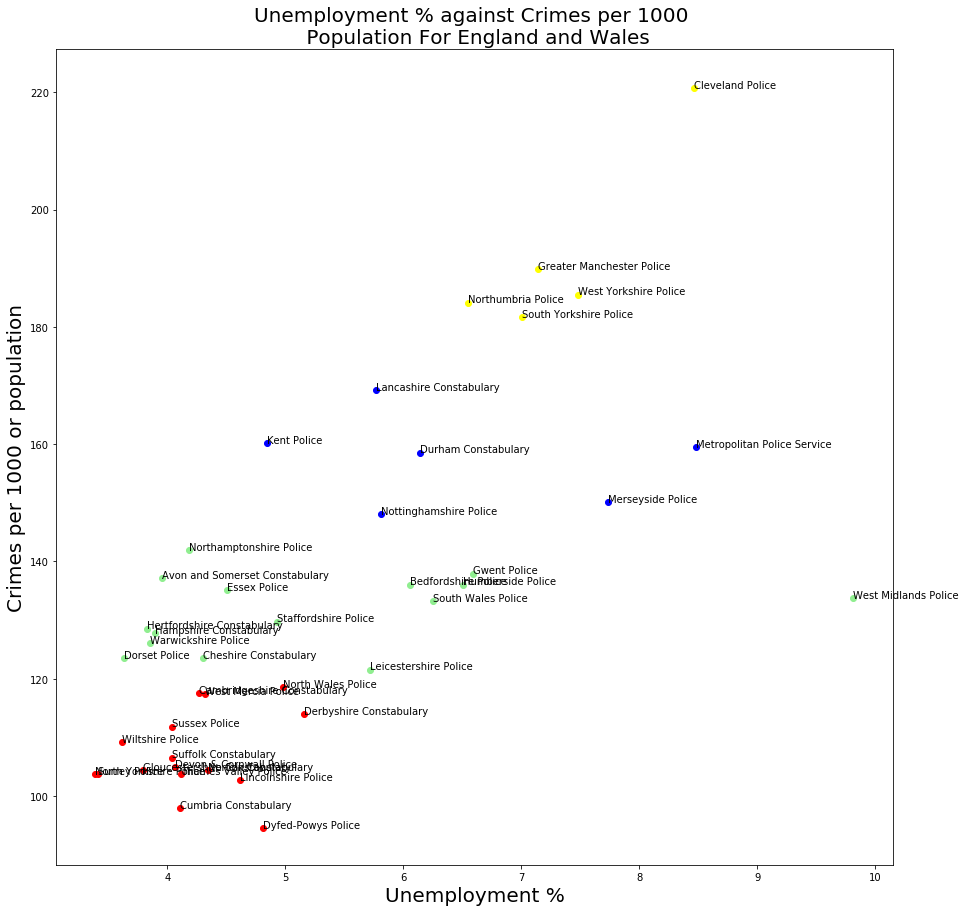

In [308]:
fig = plt.figure(figsize=[15,15])
# Plot the data points which in the cluster labelled '0'
plt.scatter(crimes_df_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==0],
            crimes_df_unemployed['crimes per 1000'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(crimes_df_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==1],
            crimes_df_unemployed['crimes per 1000'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(crimes_df_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==2],
            crimes_df_unemployed['crimes per 1000'][assignedClusters_clust.labels_==2],
            color='lightGreen', marker='o', label='cluster 2')

# Plot the data points which in the cluster labelled '2'
plt.scatter(crimes_df_unemployed['unemployed_percentage'][assignedClusters_clust.labels_==3],
            crimes_df_unemployed['crimes per 1000'][assignedClusters_clust.labels_==3],
            color='Yellow', marker='o', label='cluster 3')

##plt.legend()
## label datapoints
labels = list(crimes_df_unemployed.index)
for i in range(0,len(labels)):
    xy=(crimes_df_unemployed['unemployed_percentage'][i], crimes_df_unemployed['crimes per 1000'][i])
    plt.annotate(labels[i],xy)
    
plt.xlabel('Unemployment %').set_fontsize(20)
plt.ylabel('Crimes per 1000 or population').set_fontsize(20)
plt.title('Unemployment % against Crimes per 1000 \n Population For England and Wales').set_fontsize(20)


plt.savefig('unemployment vs crime rate.png')

In [321]:
clusteringData_df5 = crimes_df_employed[['subsistence_percentage', 'crimes per 1000']]
clusteringData_df5.head()

,subsistence_percentage,crimes per 1000
Reported by,,
Avon and Somerset Constabulary,36.6540098,137.2298651
Bedfordshire Police,38.5103857,136.0516555
Cambridgeshire Constabulary,36.3698458,117.5103068
Cheshire Constabulary,38.5034452,123.4956430
Cleveland Police,50.3746521,220.6859476


In [322]:
# First, create an instance of the clusterer with k=4
kmeans3 = cluster.KMeans(n_clusters=4)

# Then call the fit function on the clusterer to fit the data to the 3 means.
assignedClusters_clust = kmeans3.fit(clusteringData_df5)

# And see how the data points have been assigned to clusters:
assignedClusters_clust.labels_

array([2, 2, 0, 2, 3, 0, 0, 0, 2, 1, 0, 2, 0, 3, 2, 2, 2, 2, 1, 1, 2, 0,
       1, 1, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 0, 0, 0, 2, 0, 2, 3, 0],
      dtype=int32)

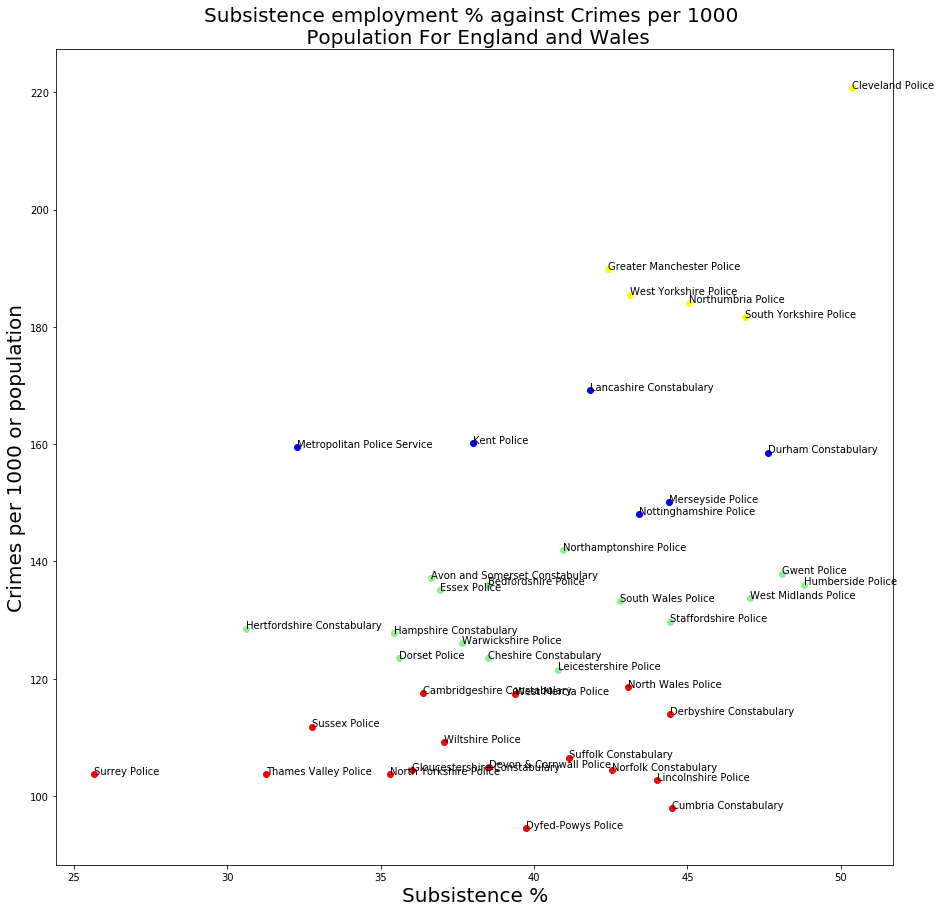

In [323]:
fig = plt.figure(figsize=[15,15])
# Plot the data points which in the cluster labelled '0'
plt.scatter(crimes_df_employed['subsistence_percentage'][assignedClusters_clust.labels_==0],
            crimes_df_employed['crimes per 1000'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(crimes_df_employed['subsistence_percentage'][assignedClusters_clust.labels_==1],
            crimes_df_employed['crimes per 1000'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(crimes_df_employed['subsistence_percentage'][assignedClusters_clust.labels_==2],
            crimes_df_employed['crimes per 1000'][assignedClusters_clust.labels_==2],
            color='lightGreen', marker='o', label='cluster 2')

# Plot the data points which in the cluster labelled '2'
plt.scatter(crimes_df_employed['subsistence_percentage'][assignedClusters_clust.labels_==3],
            crimes_df_employed['crimes per 1000'][assignedClusters_clust.labels_==3],
            color='Yellow', marker='o', label='cluster 3')

##plt.legend()
## label datapoints
labels = list(crimes_df_employed.index)
for i in range(0,len(labels)):
    xy=(crimes_df_employed['subsistence_percentage'][i], crimes_df_employed['crimes per 1000'][i])
    plt.annotate(labels[i],xy)
    
plt.xlabel('Subsistence %').set_fontsize(20)
plt.ylabel('Crimes per 1000 or population').set_fontsize(20)
plt.title('Subsistence employment % against Crimes per 1000 \n Population For England and Wales').set_fontsize(20)


plt.savefig('subsistence vs crime rate.png')

In [318]:
clusteringData_df6 = crimes_df_employed[['gainful_percentage', 'crimes per 1000']]
clusteringData_df6.head()

,gainful_percentage,crimes per 1000
Reported by,,
Avon and Somerset Constabulary,55.0519186,137.2298651
Bedfordshire Police,53.0358294,136.0516555
Cambridgeshire Constabulary,55.0332024,117.5103068
Cheshire Constabulary,55.1594193,123.4956430
Cleveland Police,42.0723268,220.6859476


In [319]:
# First, create an instance of the clusterer with k=4
kmeans3 = cluster.KMeans(n_clusters=4)

# Then call the fit function on the clusterer to fit the data to the 3 means.
assignedClusters_clust = kmeans3.fit(clusteringData_df6)

# And see how the data points have been assigned to clusters:
assignedClusters_clust.labels_

array([2, 2, 0, 2, 1, 0, 0, 0, 2, 3, 0, 2, 0, 1, 2, 2, 2, 2, 3, 3, 2, 0,
       3, 3, 0, 0, 0, 2, 1, 3, 2, 1, 2, 0, 0, 0, 0, 2, 0, 2, 1, 0],
      dtype=int32)

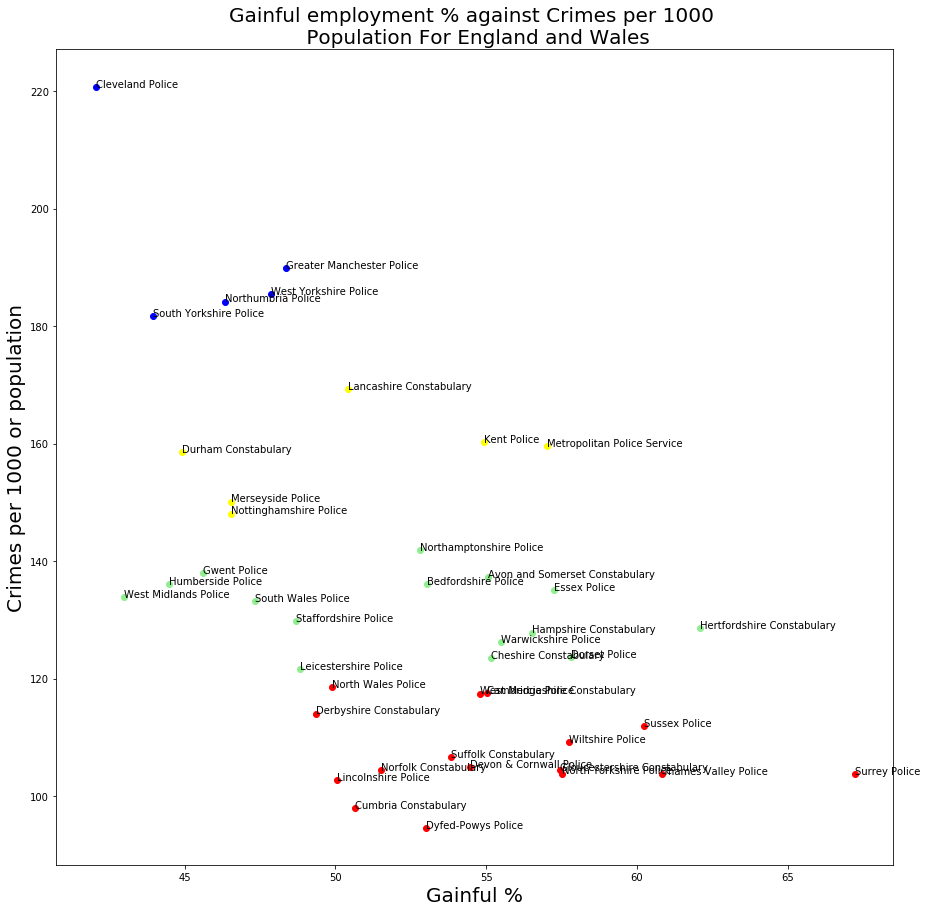

In [320]:
fig = plt.figure(figsize=[15,15])
# Plot the data points which in the cluster labelled '0'
plt.scatter(crimes_df_employed['gainful_percentage'][assignedClusters_clust.labels_==0],
            crimes_df_employed['crimes per 1000'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(crimes_df_employed['gainful_percentage'][assignedClusters_clust.labels_==1],
            crimes_df_employed['crimes per 1000'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(crimes_df_employed['gainful_percentage'][assignedClusters_clust.labels_==2],
            crimes_df_employed['crimes per 1000'][assignedClusters_clust.labels_==2],
            color='lightGreen', marker='o', label='cluster 2')

# Plot the data points which in the cluster labelled '2'
plt.scatter(crimes_df_employed['gainful_percentage'][assignedClusters_clust.labels_==3],
            crimes_df_employed['crimes per 1000'][assignedClusters_clust.labels_==3],
            color='Yellow', marker='o', label='cluster 3')

##plt.legend()
## label datapoints
labels = list(crimes_df_employed.index)
for i in range(0,len(labels)):
    xy=(crimes_df_employed['gainful_percentage'][i], crimes_df_employed['crimes per 1000'][i])
    plt.annotate(labels[i],xy)
    
plt.xlabel('Gainful %').set_fontsize(20)
plt.ylabel('Crimes per 1000 or population').set_fontsize(20)
plt.title('Gainful employment % against Crimes per 1000 \n Population For England and Wales').set_fontsize(20)


plt.savefig('gainful vs crime rate.png')

In [317]:
clusteringData_df6 = crimes_df_employed[['total_population', 'crimes per 1000']]
clusteringData_df6.head()

,total_population,crimes per 1000
Reported by,,
Avon and Somerset Constabulary,1310225.0,137.2298651
Bedfordshire Police,486918.0,136.0516555
Cambridgeshire Constabulary,652964.0,117.5103068
Cheshire Constabulary,840143.0,123.4956430
Cleveland Police,450151.0,220.6859476


In [324]:
# First, create an instance of the clusterer with k=4
kmeans3 = cluster.KMeans(n_clusters=4)

# Then call the fit function on the clusterer to fit the data to the 3 means.
assignedClusters_clust = kmeans3.fit(clusteringData_df6)

# And see how the data points have been assigned to clusters:
assignedClusters_clust.labels_

array([3, 3, 0, 3, 2, 0, 0, 0, 3, 1, 0, 3, 0, 2, 3, 3, 3, 3, 1, 1, 3, 0,
       1, 1, 0, 3, 0, 3, 2, 1, 3, 2, 3, 0, 0, 0, 0, 3, 0, 3, 2, 0],
      dtype=int32)

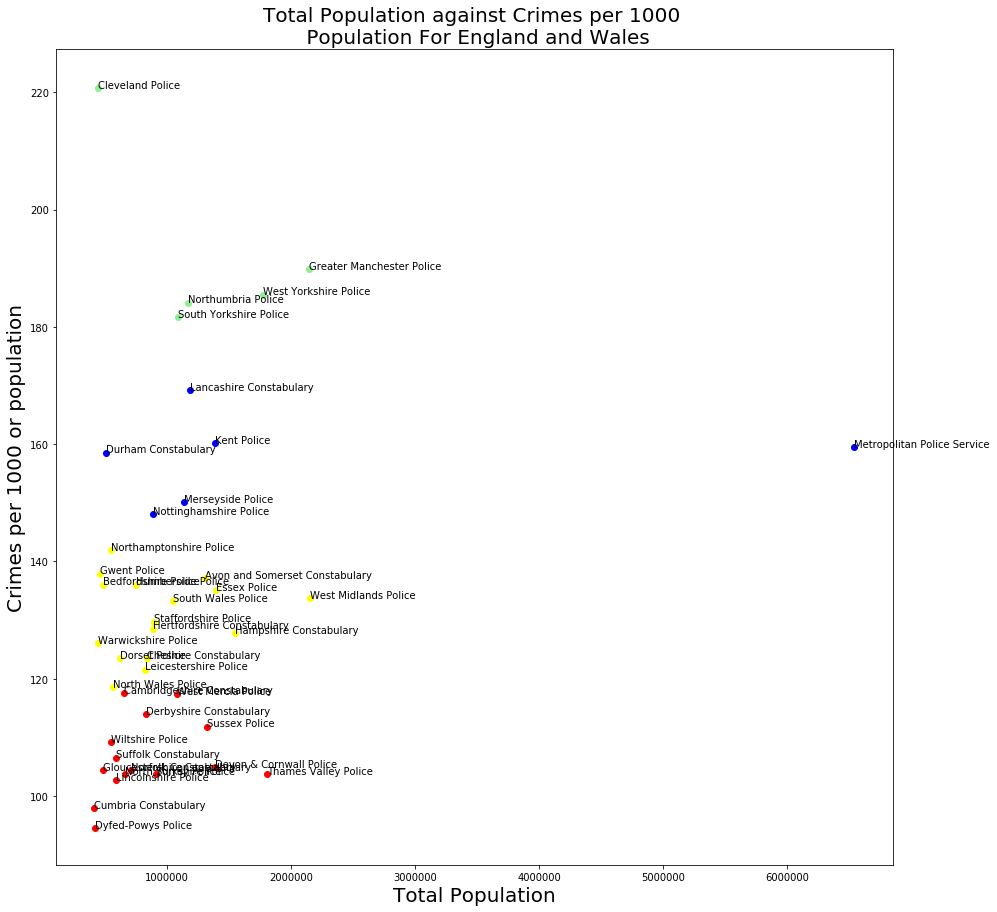

In [326]:
fig = plt.figure(figsize=[15,15])
# Plot the data points which in the cluster labelled '0'
plt.scatter(crimes_df_employed['total_population'][assignedClusters_clust.labels_==0],
            crimes_df_employed['crimes per 1000'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(crimes_df_employed['total_population'][assignedClusters_clust.labels_==1],
            crimes_df_employed['crimes per 1000'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(crimes_df_employed['total_population'][assignedClusters_clust.labels_==2],
            crimes_df_employed['crimes per 1000'][assignedClusters_clust.labels_==2],
            color='lightGreen', marker='o', label='cluster 2')

# Plot the data points which in the cluster labelled '2'
plt.scatter(crimes_df_employed['total_population'][assignedClusters_clust.labels_==3],
            crimes_df_employed['crimes per 1000'][assignedClusters_clust.labels_==3],
            color='Yellow', marker='o', label='cluster 3')

##plt.legend()
## label datapoints
labels = list(crimes_df_employed.index)
for i in range(0,len(labels)):
    xy=(crimes_df_employed['total_population'][i], crimes_df_employed['crimes per 1000'][i])
    plt.annotate(labels[i],xy)
    
plt.xlabel('Total Population').set_fontsize(20)
plt.ylabel('Crimes per 1000 or population').set_fontsize(20)
plt.title('Total Population against Crimes per 1000 \n Population For England and Wales').set_fontsize(20)


plt.savefig('population vs crime rate.png')

In [328]:
clusteringData_df7 = crimes_df_employed[['gainful_percentage', 'subsistence_percentage']]
clusteringData_df7.head()

,gainful_percentage,subsistence_percentage
Reported by,,
Avon and Somerset Constabulary,55.0519186,36.6540098
Bedfordshire Police,53.0358294,38.5103857
Cambridgeshire Constabulary,55.0332024,36.3698458
Cheshire Constabulary,55.1594193,38.5034452
Cleveland Police,42.0723268,50.3746521


In [329]:
# First, create an instance of the clusterer with k=4
kmeans3 = cluster.KMeans(n_clusters=4)

# Then call the fit function on the clusterer to fit the data to the 3 means.
assignedClusters_clust = kmeans3.fit(clusteringData_df7)

# And see how the data points have been assigned to clusters:
assignedClusters_clust.labels_

array([0, 0, 0, 0, 1, 3, 3, 0, 0, 1, 0, 0, 0, 3, 1, 0, 2, 1, 0, 3, 3, 3,
       3, 2, 3, 3, 0, 0, 3, 3, 3, 1, 3, 0, 2, 2, 2, 0, 0, 1, 3, 0],
      dtype=int32)

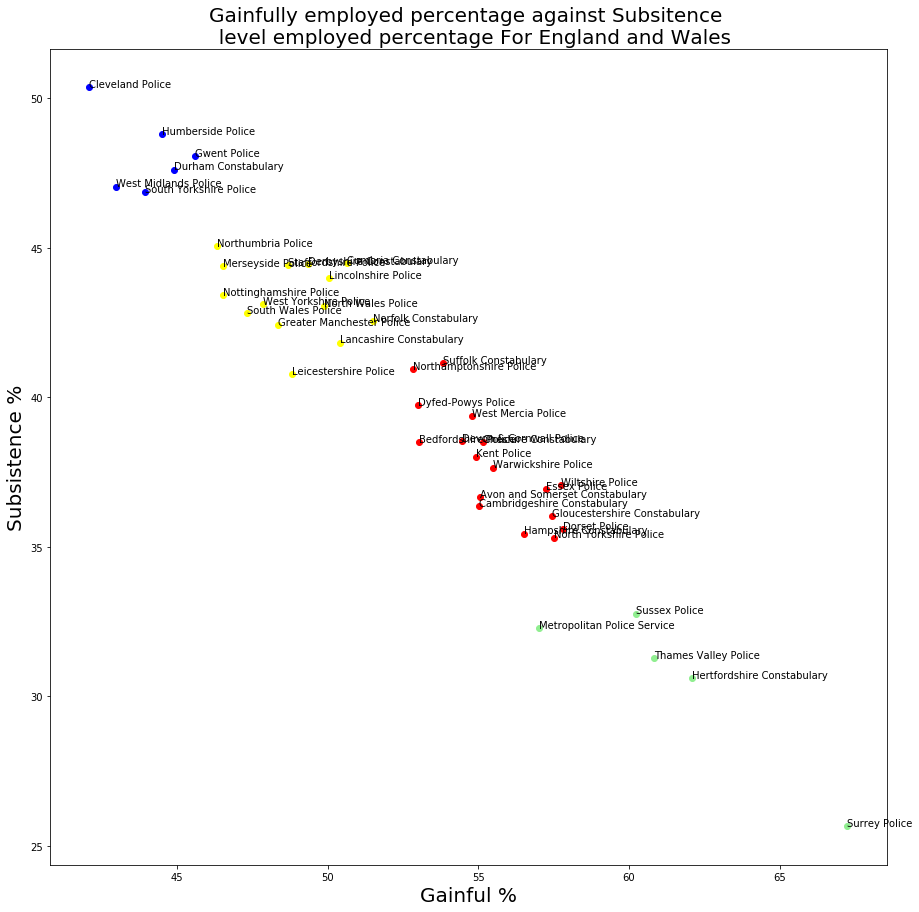

In [330]:
fig = plt.figure(figsize=[15,15])
# Plot the data points which in the cluster labelled '0'
plt.scatter(crimes_df_employed['gainful_percentage'][assignedClusters_clust.labels_==0],
            crimes_df_employed['subsistence_percentage'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(crimes_df_employed['gainful_percentage'][assignedClusters_clust.labels_==1],
            crimes_df_employed['subsistence_percentage'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(crimes_df_employed['gainful_percentage'][assignedClusters_clust.labels_==2],
            crimes_df_employed['subsistence_percentage'][assignedClusters_clust.labels_==2],
            color='lightGreen', marker='o', label='cluster 2')

# Plot the data points which in the cluster labelled '2'
plt.scatter(crimes_df_employed['gainful_percentage'][assignedClusters_clust.labels_==3],
            crimes_df_employed['subsistence_percentage'][assignedClusters_clust.labels_==3],
            color='Yellow', marker='o', label='cluster 3')

##plt.legend()
## label datapoints
labels = list(crimes_df_employed.index)
for i in range(0,len(labels)):
    xy=(crimes_df_employed['gainful_percentage'][i], crimes_df_employed['subsistence_percentage'][i])
    plt.annotate(labels[i],xy)
    
plt.xlabel('Gainful %').set_fontsize(20)
plt.ylabel('Subsistence %').set_fontsize(20)
plt.title('Gainfully employed percentage against Subsitence \n  level employed percentage For England and Wales').set_fontsize(20)


plt.savefig('subsistence vs gainful.png')